# Exercise 3: Time series with ARIMA

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically. 
* Failure to comply with the following instructions will result in a significant penalty. 
* Appeals regarding your failure to read these instructions will be denied. 
* Kind reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
---

## Please sign that you have read and understood the instructions: 

316492776
318900016

---
---


In [ ]:
!pip3 install statsmodels
!pip3 install seaborn
!pip3 install numpy
!pip3 install pandas
!pip3 install tqdm
!pip3 install scikit-learn
!pip3 install yfinance

In [349]:
# Import necessary libraries
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
import numpy as np
import seaborn as sns
import itertools
from matplotlib.colors import ListedColormap
from numpy import log
from sklearn.datasets import load_iris, make_classification
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from tqdm.auto import tqdm
import pandas as pd
import yfinance as yf

sns.set_theme()
np.random.seed(42)

# Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

In [377]:
class ArimaCustom: ## Change it to Arima algorithm
    def __init__(self, T: int = 50, verbose: bool = True):
        self.T = T
        self.alphas = []
        self.estimators_ = []  # to match with sklearn so functions can work on both
        self.verbose = verbose

    def fit(self, X: np.ndarray, y: np.ndarray):
        w = np.ones_like(y) / len(y)
        for t in tqdm(range(self.T), disable=not self.verbose, desc="t"):
            if self.verbose:
                print(f"After {t} models, Z=loss(H)={self.Z(X,y)}")
            h = DecisionTreeClassifier(max_depth=1)
            h.fit(X=X, y=y, sample_weight=w)
            epsilon = (w * (h.predict(X=X) != y)).sum()
            if epsilon >= 0.5:
                if self.verbose:
                    print(f"Stopping eraly! h is not better than random. {epsilon=}")
                return self
            alpha = 0.5 * (np.log(1 - epsilon) - np.log(epsilon))
            # update alphas, models and w
            self.estimators_.append(h)
            self.alphas.append(alpha)
            w *= np.exp(-alpha * h.predict(X) * y)
            w /= 2 * (epsilon * (1 - epsilon)) ** 0.5
        return self

    def H(self, X: np.ndarray) -> np.ndarray:
        return np.array(
            [
                alpha * model.predict(X)
                for alpha, model in zip(self.alphas, self.estimators_)
            ]
        ).sum(axis=0)

    def Z(self, X: np.ndarray, y: np.ndarray) -> float:
        return np.exp(-y * self.H(X)).sum()

    def predict(self, X: np.ndarray) -> np.ndarray:
        predictions = np.sign(self.H(X))
        return predictions

# Generate data
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

For the data generation. We chose to use the IRIS dataset
The IRIS Flower dataset is a well known dataset that works well with boosting algorithms, easy to classify and it contains 4 features:
1. Sepal length
2. Sepal width
3. Petal length
4. Petal width

And 3 classes (labels): Setosa, Versicolor, Virginica that marked as 0, 1, 2

For sampling our implementation, we disabled one of the classes of IRIS in order to handle a binary-labeled dataset

In [76]:
path = './sample_dataset.csv'

sample_dataset = pd.read_csv(path)

sample_dataset.head()

date     value
0  1991-07-01  3.526591
1  1991-08-01  3.180891
2  1991-09-01  3.252221
3  1991-10-01  3.611003
4  1991-11-01  3.565869

In [77]:
date_filter = sample_dataset['date'].loc[df['date'].str.endswith('01-01')]
date_filter

6      1992-01-01
18     1993-01-01
30     1994-01-01
42     1995-01-01
54     1996-01-01
66     1997-01-01
78     1998-01-01
90     1999-01-01
102    2000-01-01
114    2001-01-01
126    2002-01-01
138    2003-01-01
150    2004-01-01
162    2005-01-01
174    2006-01-01
186    2007-01-01
198    2008-01-01
Name: date, dtype: object

In [78]:
result = adfuller(sample_dataset.value.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: 3.145185689306743
p-value: 1.0


In [134]:
def plot_acf(values, title):
    plt.rcParams.update({'figure.figsize':(20, 16), 'figure.dpi':120})
    
    # Create subplot for ACF
    fig, axes = plt.subplots(3, 3, sharex=True)
    
    # Original Series ACF
    axes[0, 0].plot(values); axes[0, 0].set_title(title)
    tsaplots.plot_acf(values, ax=axes[0, 1])
    tsaplots.plot_pacf(values, ax=axes[0, 2])
    
    # 1st Differencing ACF
    axes[1, 0].plot(values.diff()); axes[1, 0].set_title(f'{title} - 1st Order Differencing')
    tsaplots.plot_acf(values.diff().dropna(), ax=axes[1, 1])
    tsaplots.plot_pacf(values.diff().dropna(), ax=axes[1, 2])

    
    # 2nd Differencing ACF
    axes[2, 0].plot(values.diff().diff()); axes[2, 0].set_title(f'{title} - 2nd Order Differencing')
    tsaplots.plot_acf(values.diff().diff().dropna(), ax=axes[2, 1])
    tsaplots.plot_pacf(values.diff().diff().dropna(), ax=axes[2, 2])
    
    plt.show()

# Arima demonstration 
Demonstrate your Arima implementation.

Add plots and figures. 

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the statsmodels implementation. Hint: you can look at the documentation.

In order to demonstrate our result, we chose to use the following comparisons:
1. Comparison between the methods:
   * We made a comparison between the SKLearn Model and the Custom Model, while comparing the true labels / predicted labels of each one of the models using a confusion matrix, and also compare between their accuracies (In the bottom of the notebook, a comparison of all our experiments)
   * The accuracies are compared both for train set and both for test set
   * Since IRIS dataset is a well known dataset exact for these models, we've found a very high accuracy for both models
3. Comparison between the features:
   * The IRIS dataset has 4 features, and we compared the accuracy between all the possible feature pairs
   * Also, we built a boundry graph for each one of the pairs (A boundry graph can be built just for 2 features)
   * We found that the best combination are when one feature is Sepal and the other is Petal

In [246]:
def run_arima(dataset, param, date_label):
    print("Training based on:")

    date_label
    
    for k, v in param.items():
        print(f"{k} -> {v}")
    model = ARIMA(dataset.value, order=param["order"])
    model_fit = model.fit()
    print(model_fit.summary())

    plt.rcParams.update({'figure.figsize':(20, 5), 'figure.dpi':120})
    residuals = pd.DataFrame(model_fit.resid)
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()

    forecast = model_fit.predict()
    forecast_df = pd.DataFrame({'date':dataset['date'], 'value':forecast.values})
    print(type(forecast))
    plt.plot(list(dataset['date']), list(forecast), label = "forecast")
    plt.plot(list(dataset['date']), list(dataset['value']), label = "actual")
    plt.xticks(date_label, rotation=75)
    plt.legend()
    plt.title('Actual vs forecast')
    plt.show()

    return forecast_df

ACF / PACF of original data


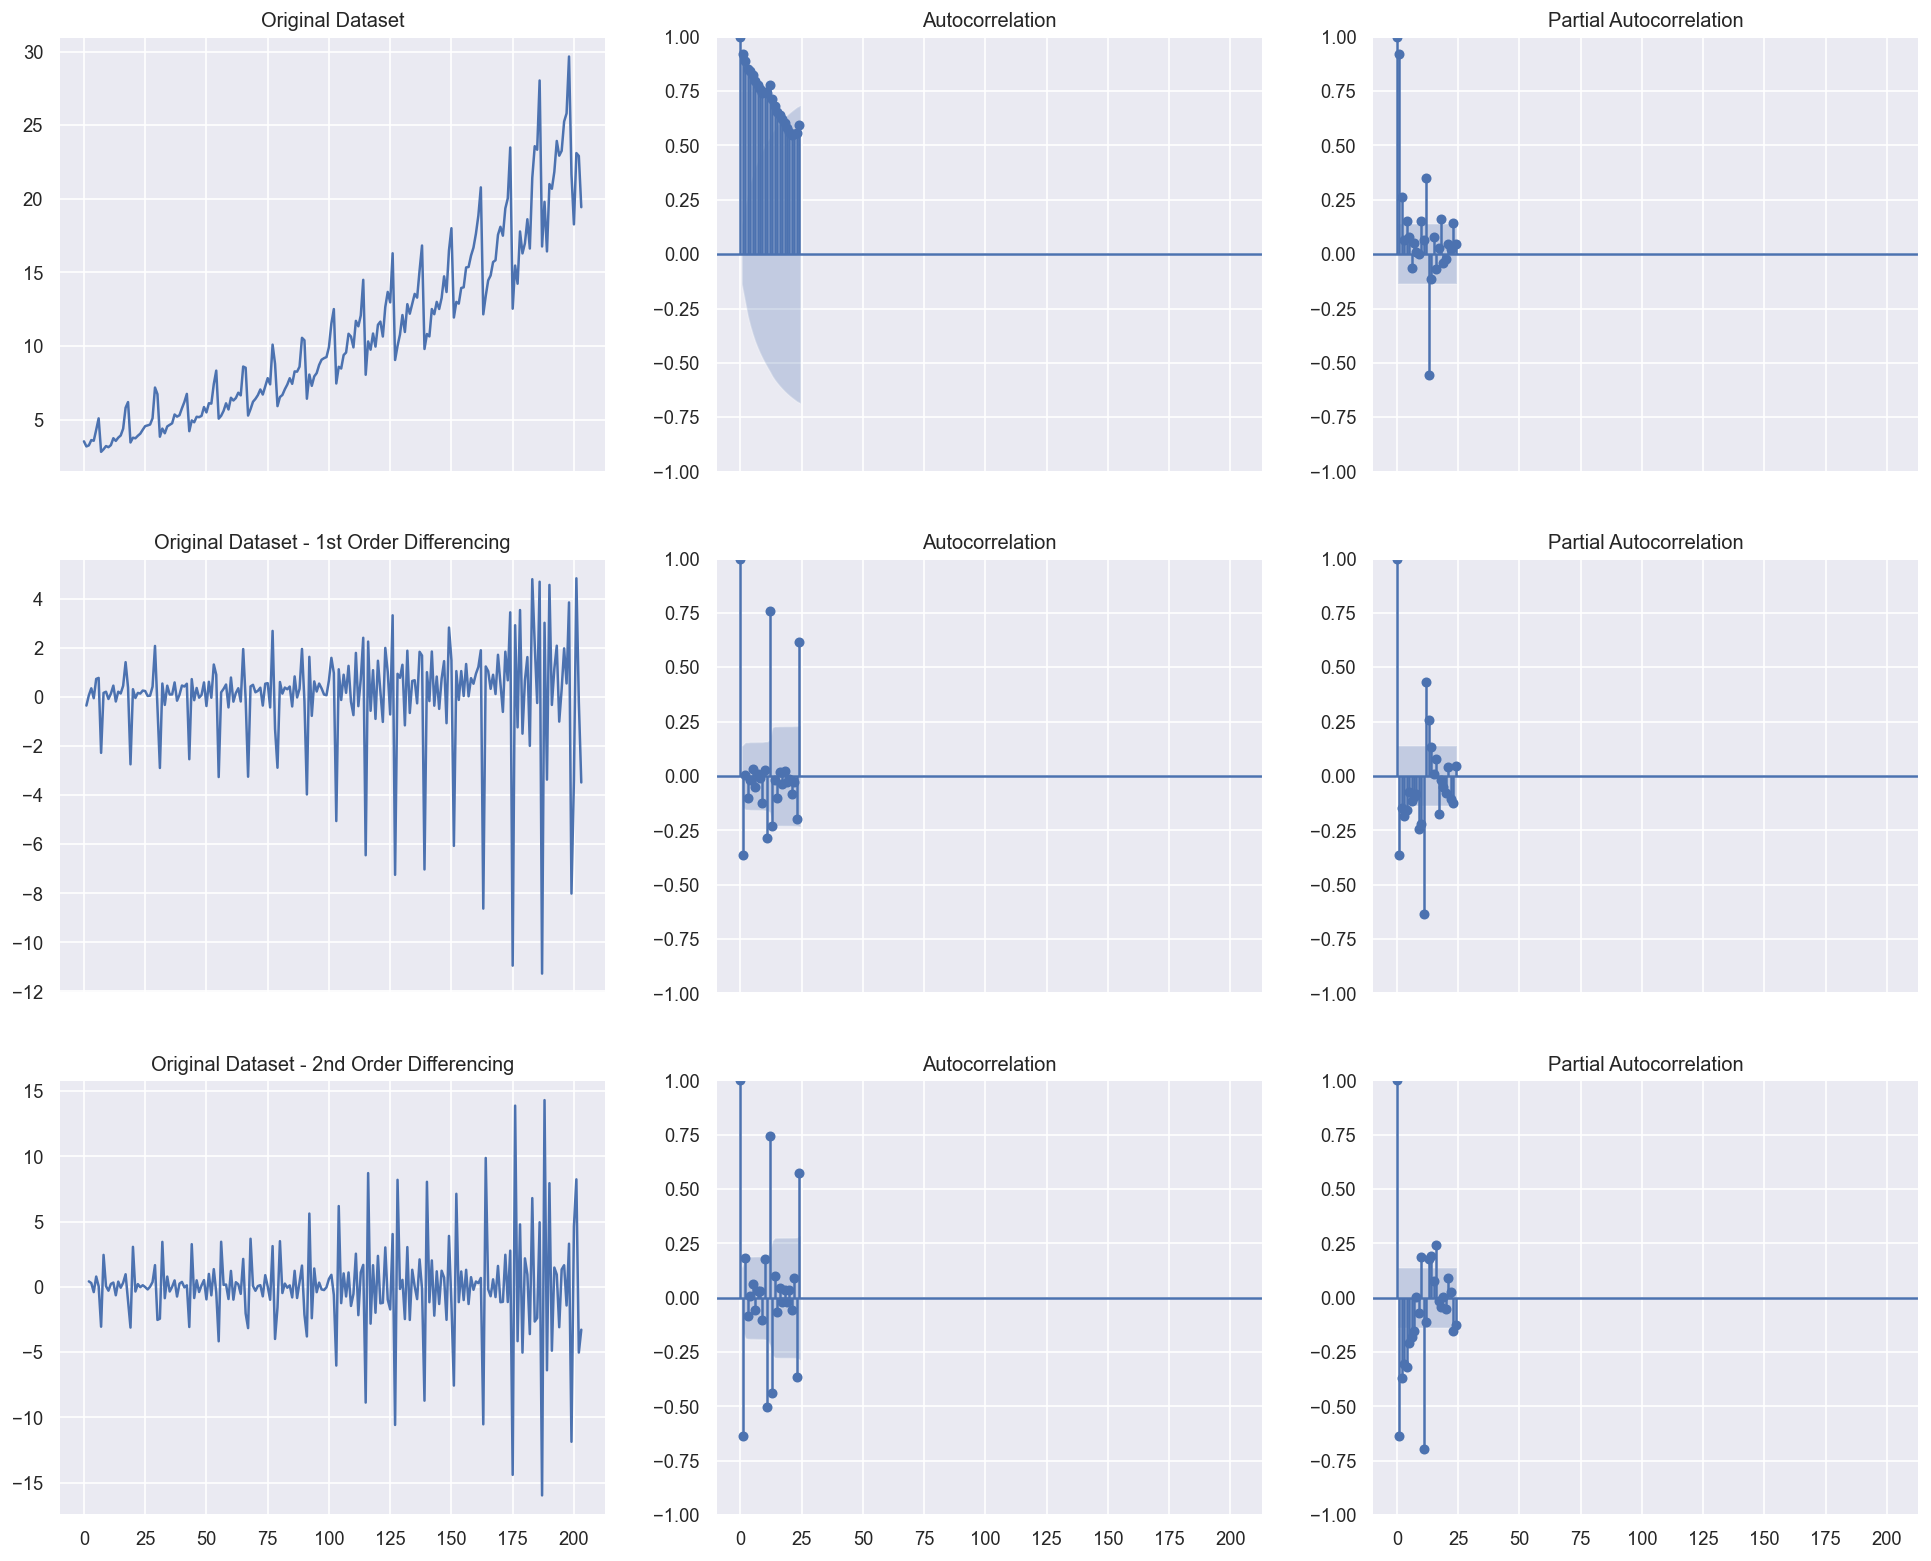

6      1992-01-01
18     1993-01-01
30     1994-01-01
42     1995-01-01
54     1996-01-01
66     1997-01-01
78     1998-01-01
90     1999-01-01
102    2000-01-01
114    2001-01-01
126    2002-01-01
138    2003-01-01
150    2004-01-01
162    2005-01-01
174    2006-01-01
186    2007-01-01
198    2008-01-01
Name: date, dtype: object
Training based on:
order -> (1, 1, 2)
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -424.570
Date:                Sat, 08 Mar 2025   AIC                            857.140
Time:                        18:09:28   BIC                            870.393
Sample:                             0   HQIC                           862.502
                                - 204                                         
Covariance Type:                  opg                                        

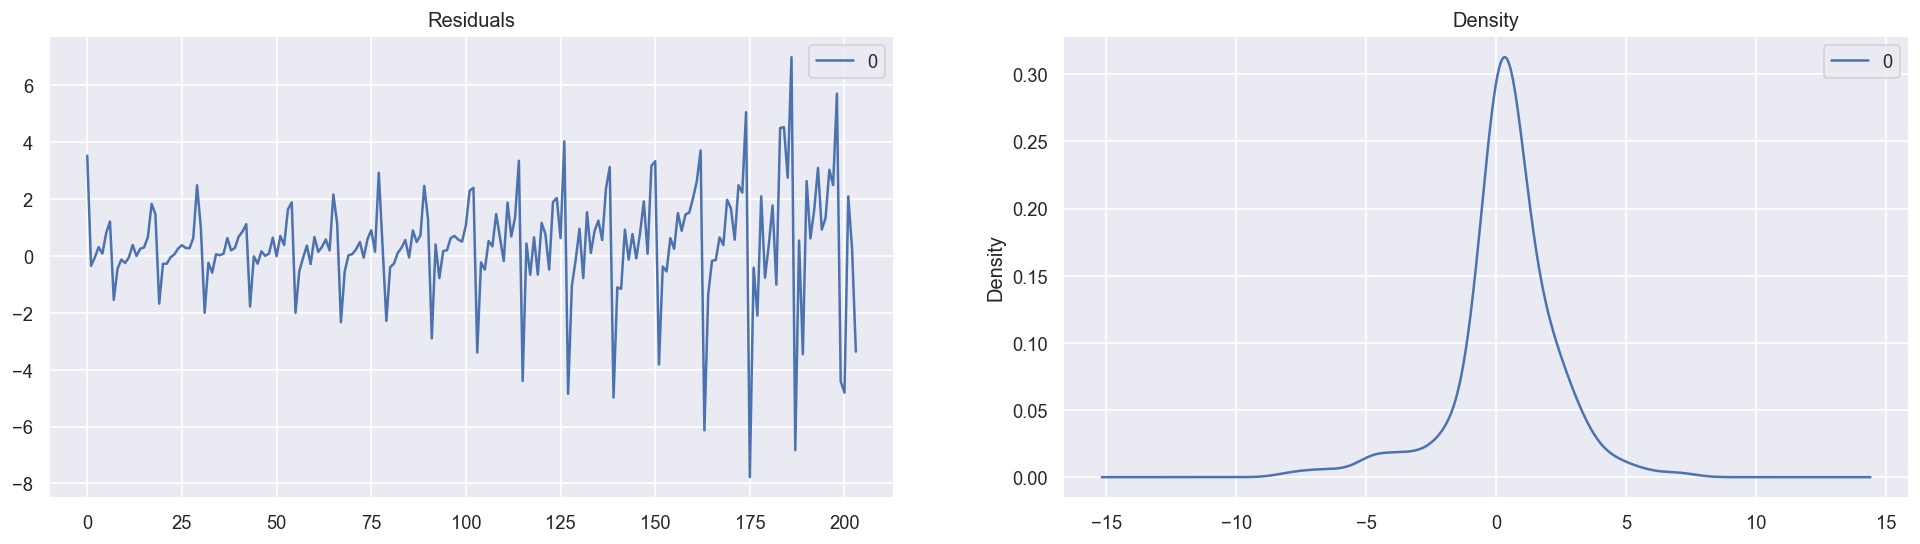

<class 'pandas.core.series.Series'>


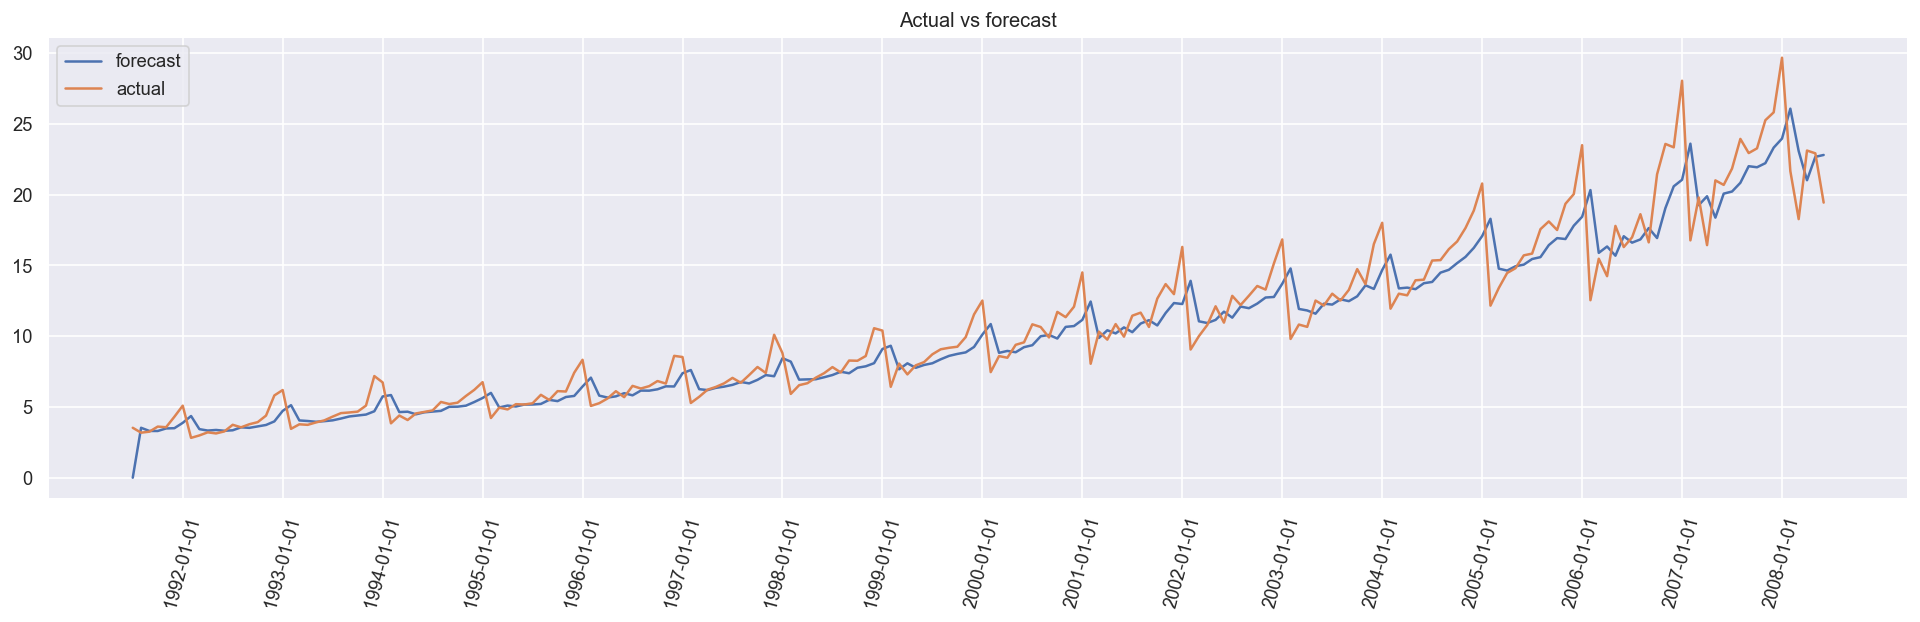

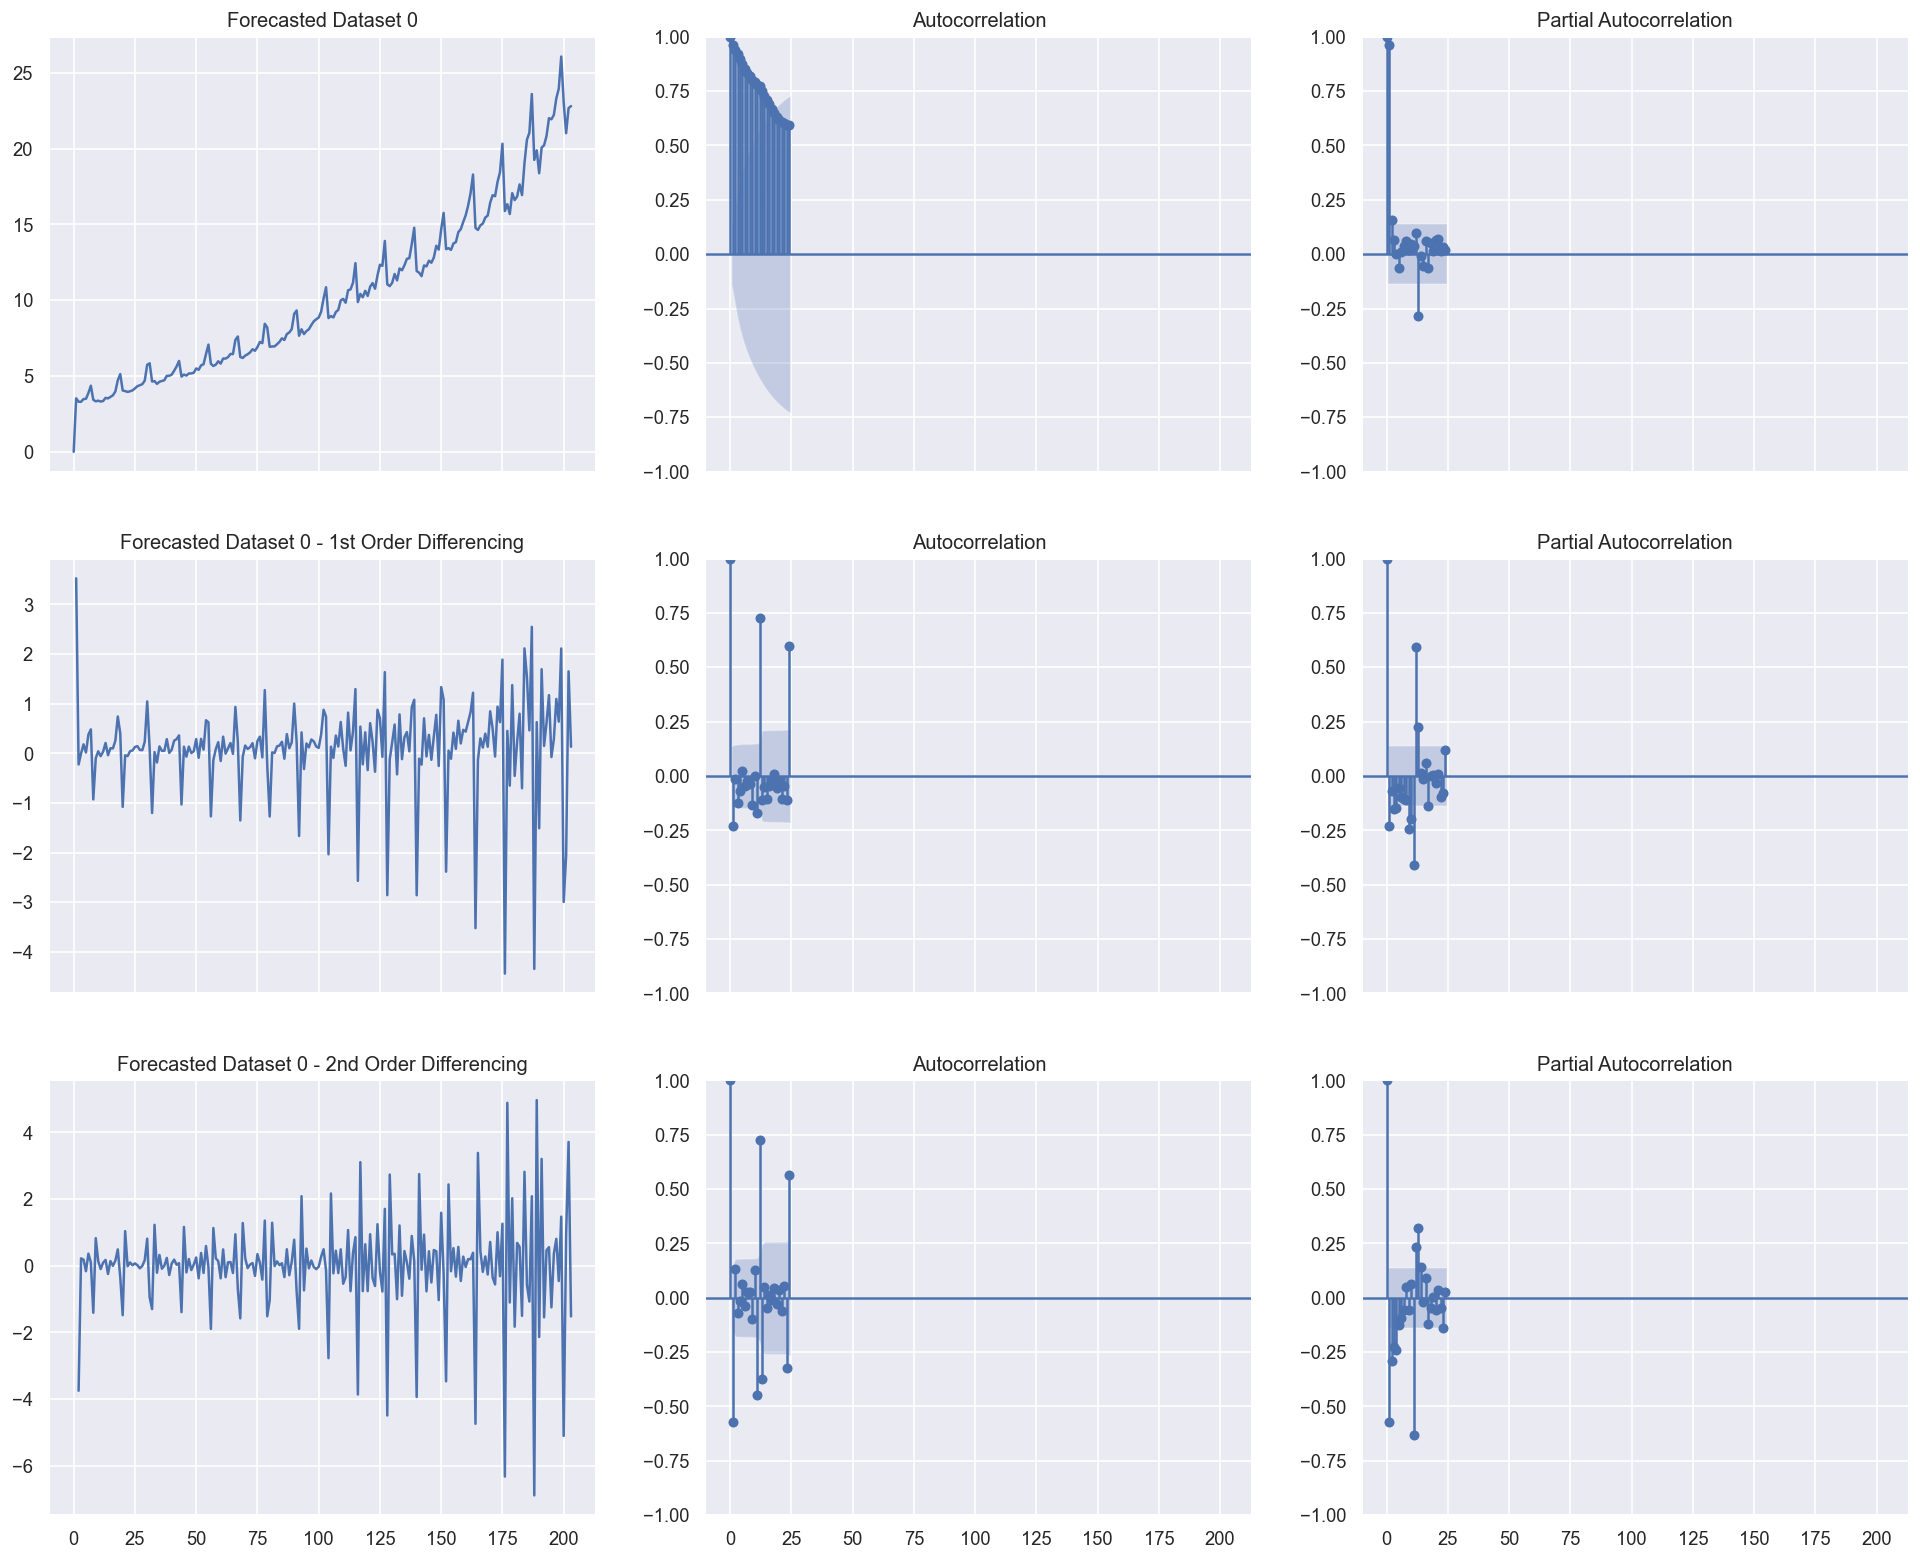

Training based on:
order -> (1, 1, 1)
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -424.762
Date:                Sat, 08 Mar 2025   AIC                            855.524
Time:                        18:09:29   BIC                            865.463
Sample:                             0   HQIC                           859.545
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3009      0.094      3.195      0.001       0.116       0.485
ma.L1         -0.8300      0.048    -17.204      0.000      -0.925      -0.735
sigma2        

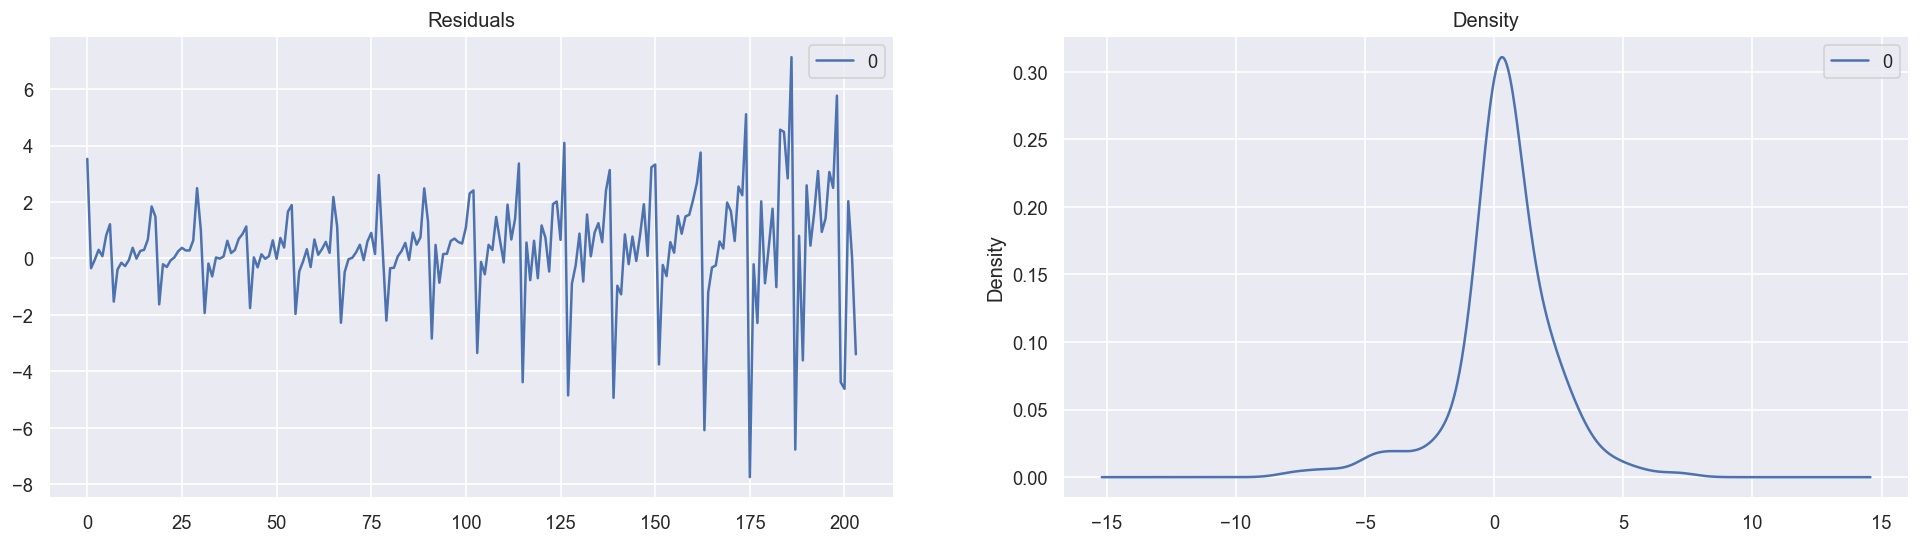

<class 'pandas.core.series.Series'>


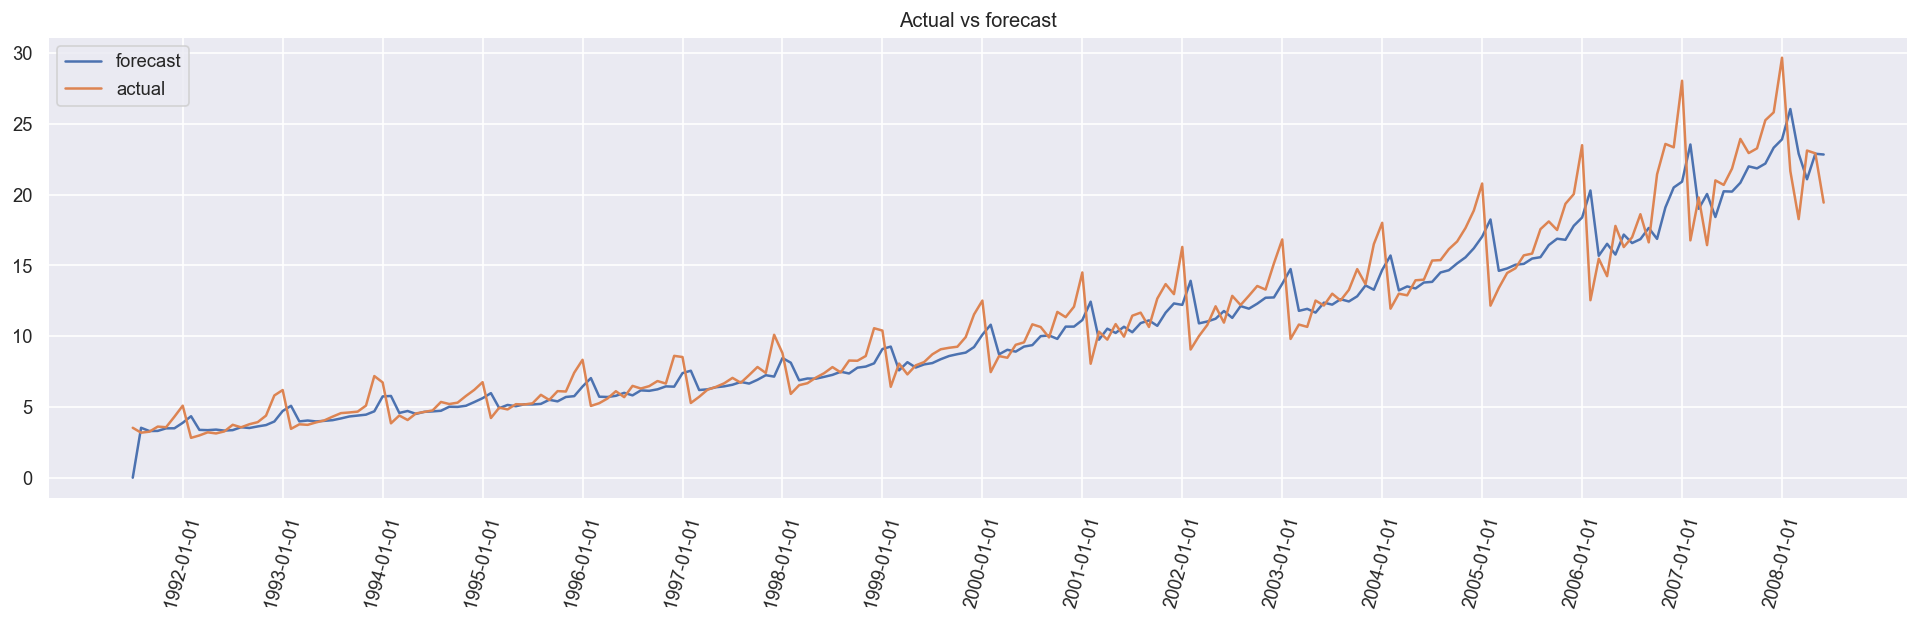

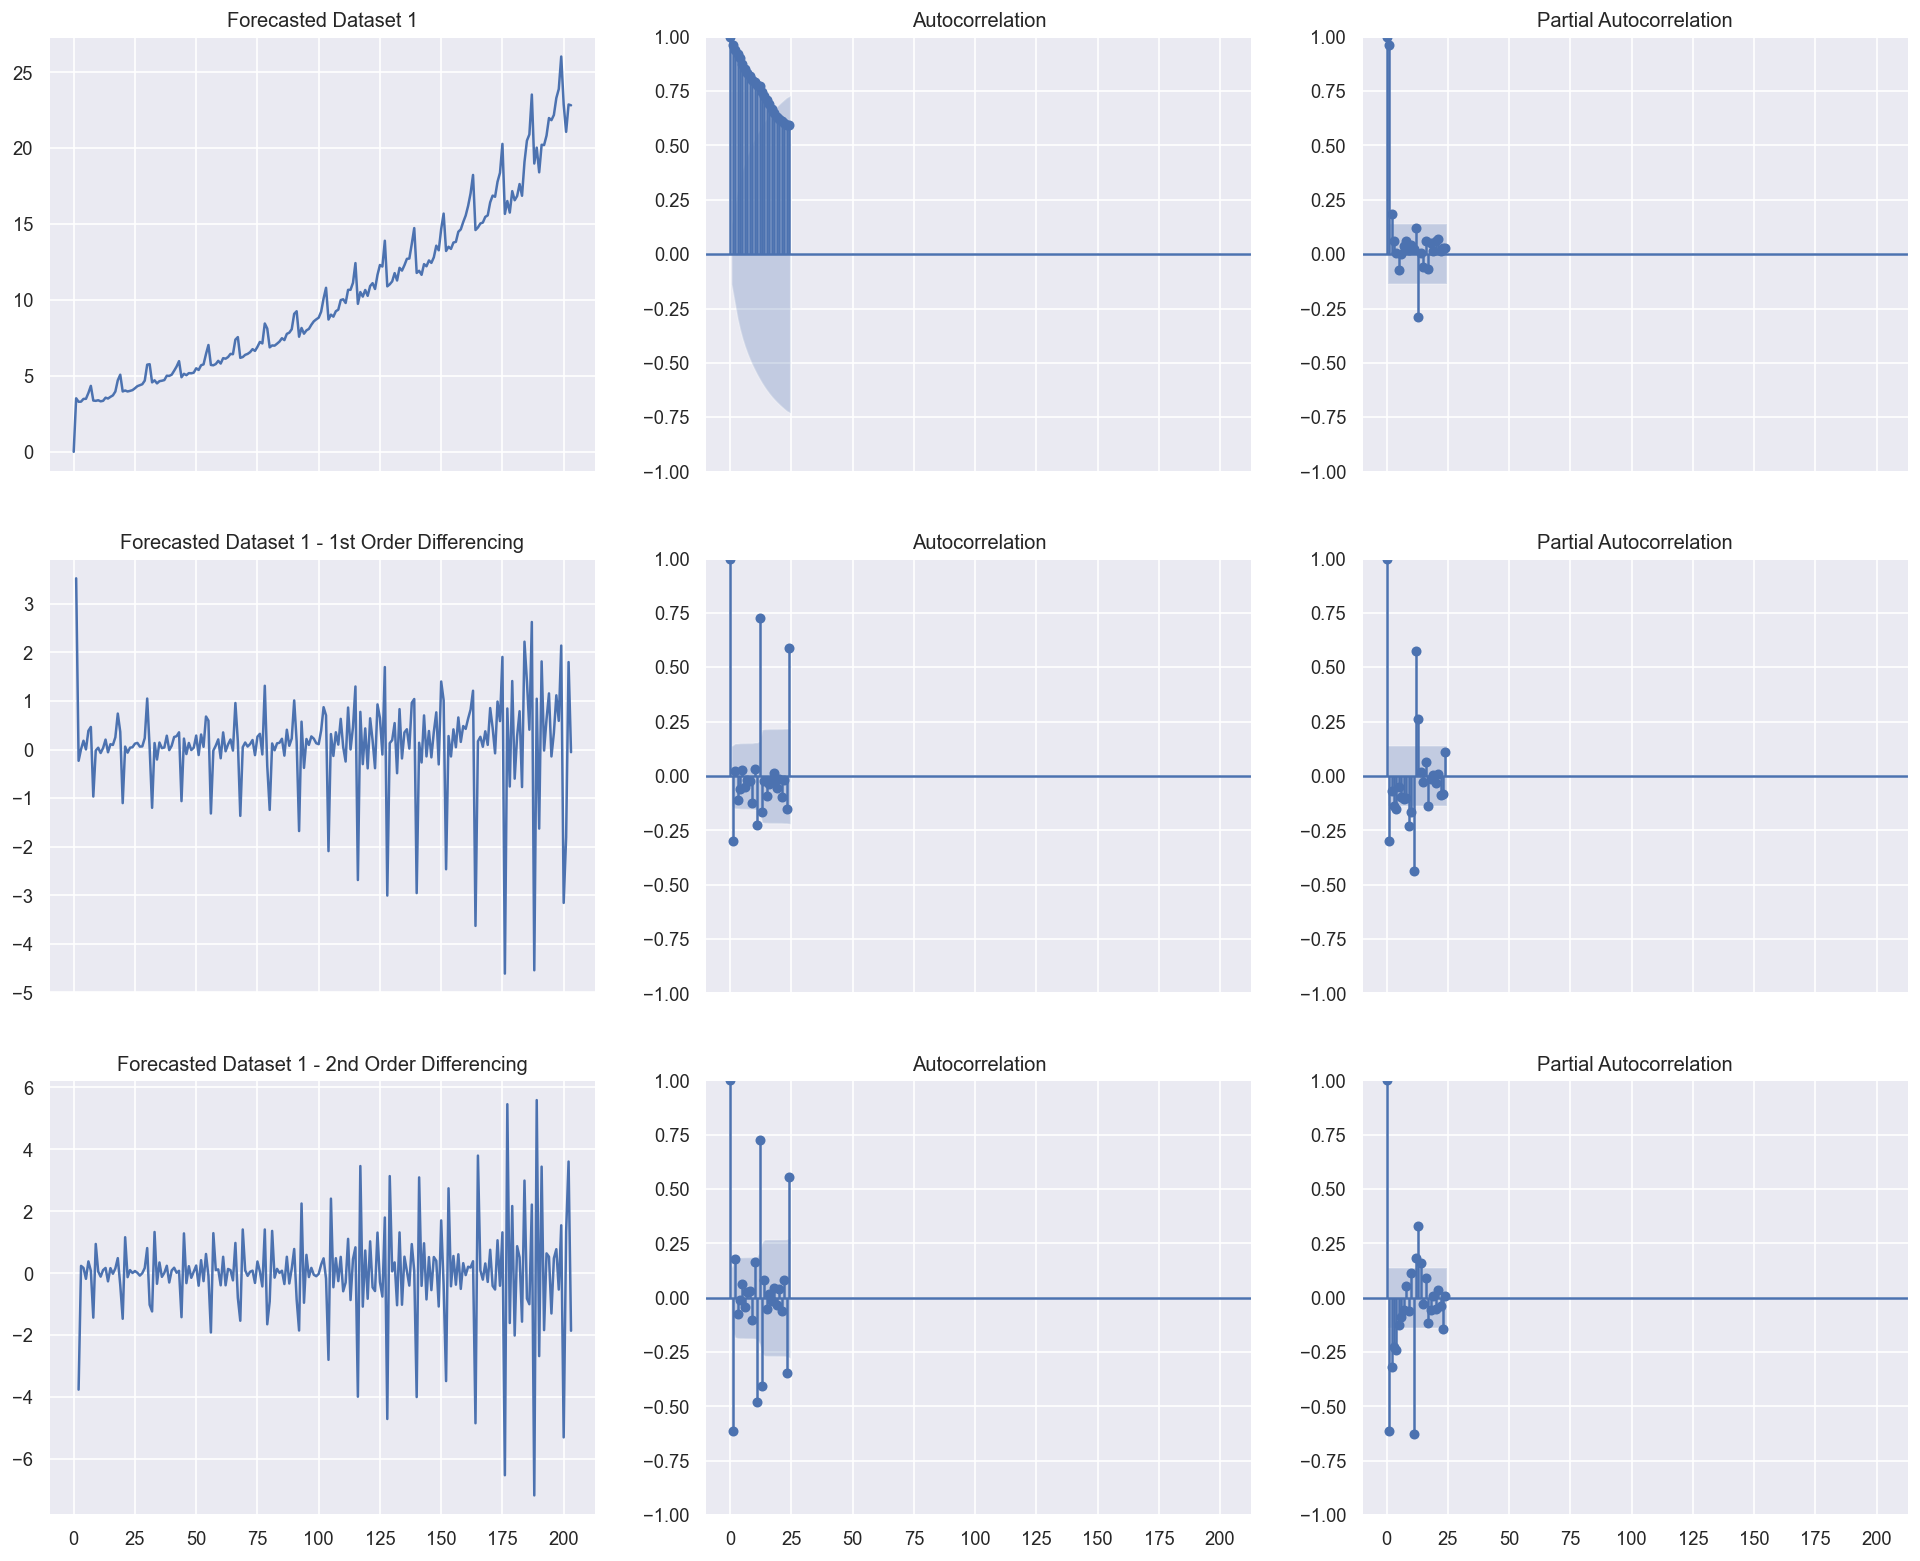

In [264]:
hyperparams = [{
    "order": (1, 1, 2)
},{
    "order": (1, 1, 1)
}]

print("ACF / PACF of original data")
plot_acf(sample_dataset.value, "Original Dataset")

date_label = sample_dataset['date'].loc[sample_dataset['date'].str.endswith('01-01')]

print(date_label)
for idx, param in enumerate(hyperparams):
    predicted_dataset = run_arima(sample_dataset, param, date_label)
    plot_acf(predicted_dataset.value, f"Forecasted Dataset {idx}")
    print("==================================================================================================")

# AMZN Dataset

In [399]:
path = './AMZN_data_1999_2022.csv'

amzn_dataset_original = pd.read_csv(path)

amzn_dataset_original.head()

Date      Open      High       Low     Close  Adj Close      Volume
0  1999-01-04  2.730729  2.966667  2.665625  2.957813   2.957813   785844000
1  1999-01-05  2.739063  3.243750  2.662500  3.112500   3.112500  1257464000
2  1999-01-06  3.409375  3.509375  3.350000  3.450000   3.450000   723532000
3  1999-01-07  3.428125  4.006250  3.325000  3.971875   3.971875   945492000
4  1999-01-08  4.606250  4.978125  3.800000  4.006250   4.006250  1333244000

In [423]:
ticker = yf.Ticker('AMZN')

amzn_dataset_original = ticker.history(period="max").reset_index() 
amzn_dataset_original['Date'] = amzn_dataset_original['Date'].astype(str)
amzn_dataset_original['Date'] = amzn_dataset_original['Date'].str.split().str[0]

amzn_dataset_original.head()

Date      Open      High       Low     Close      Volume  Dividends  \
0  1997-05-15  0.121875  0.125000  0.096354  0.097917  1443120000        0.0   
1  1997-05-16  0.098438  0.098958  0.085417  0.086458   294000000        0.0   
2  1997-05-19  0.088021  0.088542  0.081250  0.085417   122136000        0.0   
3  1997-05-20  0.086458  0.087500  0.081771  0.081771   109344000        0.0   
4  1997-05-21  0.081771  0.082292  0.068750  0.071354   377064000        0.0   

   Stock Splits  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0

In [424]:
mean_list = np.mean( np.array([ amzn_dataset_original['Low'], amzn_dataset_original['High'] ]), axis=0 )
datasets = {
    'open': pd.DataFrame({'date':amzn_dataset_original['Date'], 'value':amzn_dataset_original['Open']}),
    'close': pd.DataFrame({'date':amzn_dataset_original['Date'], 'value':amzn_dataset_original['Close']}),
    'high': pd.DataFrame({'date':amzn_dataset_original['Date'], 'value':amzn_dataset_original['High']}),
    'low': pd.DataFrame({'date':amzn_dataset_original['Date'], 'value':amzn_dataset_original['Low']}),
    'mean': pd.DataFrame({'date':amzn_dataset_original['Date'], 'value':mean_list}),
    'volume': pd.DataFrame({'date':amzn_dataset_original['Date'], 'value':amzn_dataset_original['Volume']})
}

In [425]:
def get_date_labels_amzn(dataset):
    date_filter = dataset.loc[dataset['date'].str.endswith('01-02') ^ dataset['date'].str.endswith('01-03') ^ dataset['date'].str.endswith('01-04')]
    date_filter['year'] = date_filter['date'].str.split('-').str[0]
    date_filter.loc[0] = dataset.iloc[0]
    date_filter.at[0, 'year'] = 'first'
    date_filter.loc[len(dataset)-1] = dataset.iloc[-1]
    date_filter.at[len(dataset)-1, 'year'] = 'last'
    date_filter = date_filter.drop_duplicates(subset=['year'], keep='first')
    date_filter = date_filter.loc[:, 'date']
    date_filter = date_filter.sort_index()
    
    return date_filter

/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_filter['year'] = date_filter['date'].str.split('-').str[0]
/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_filter.loc[0] = dataset.iloc[0]
/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

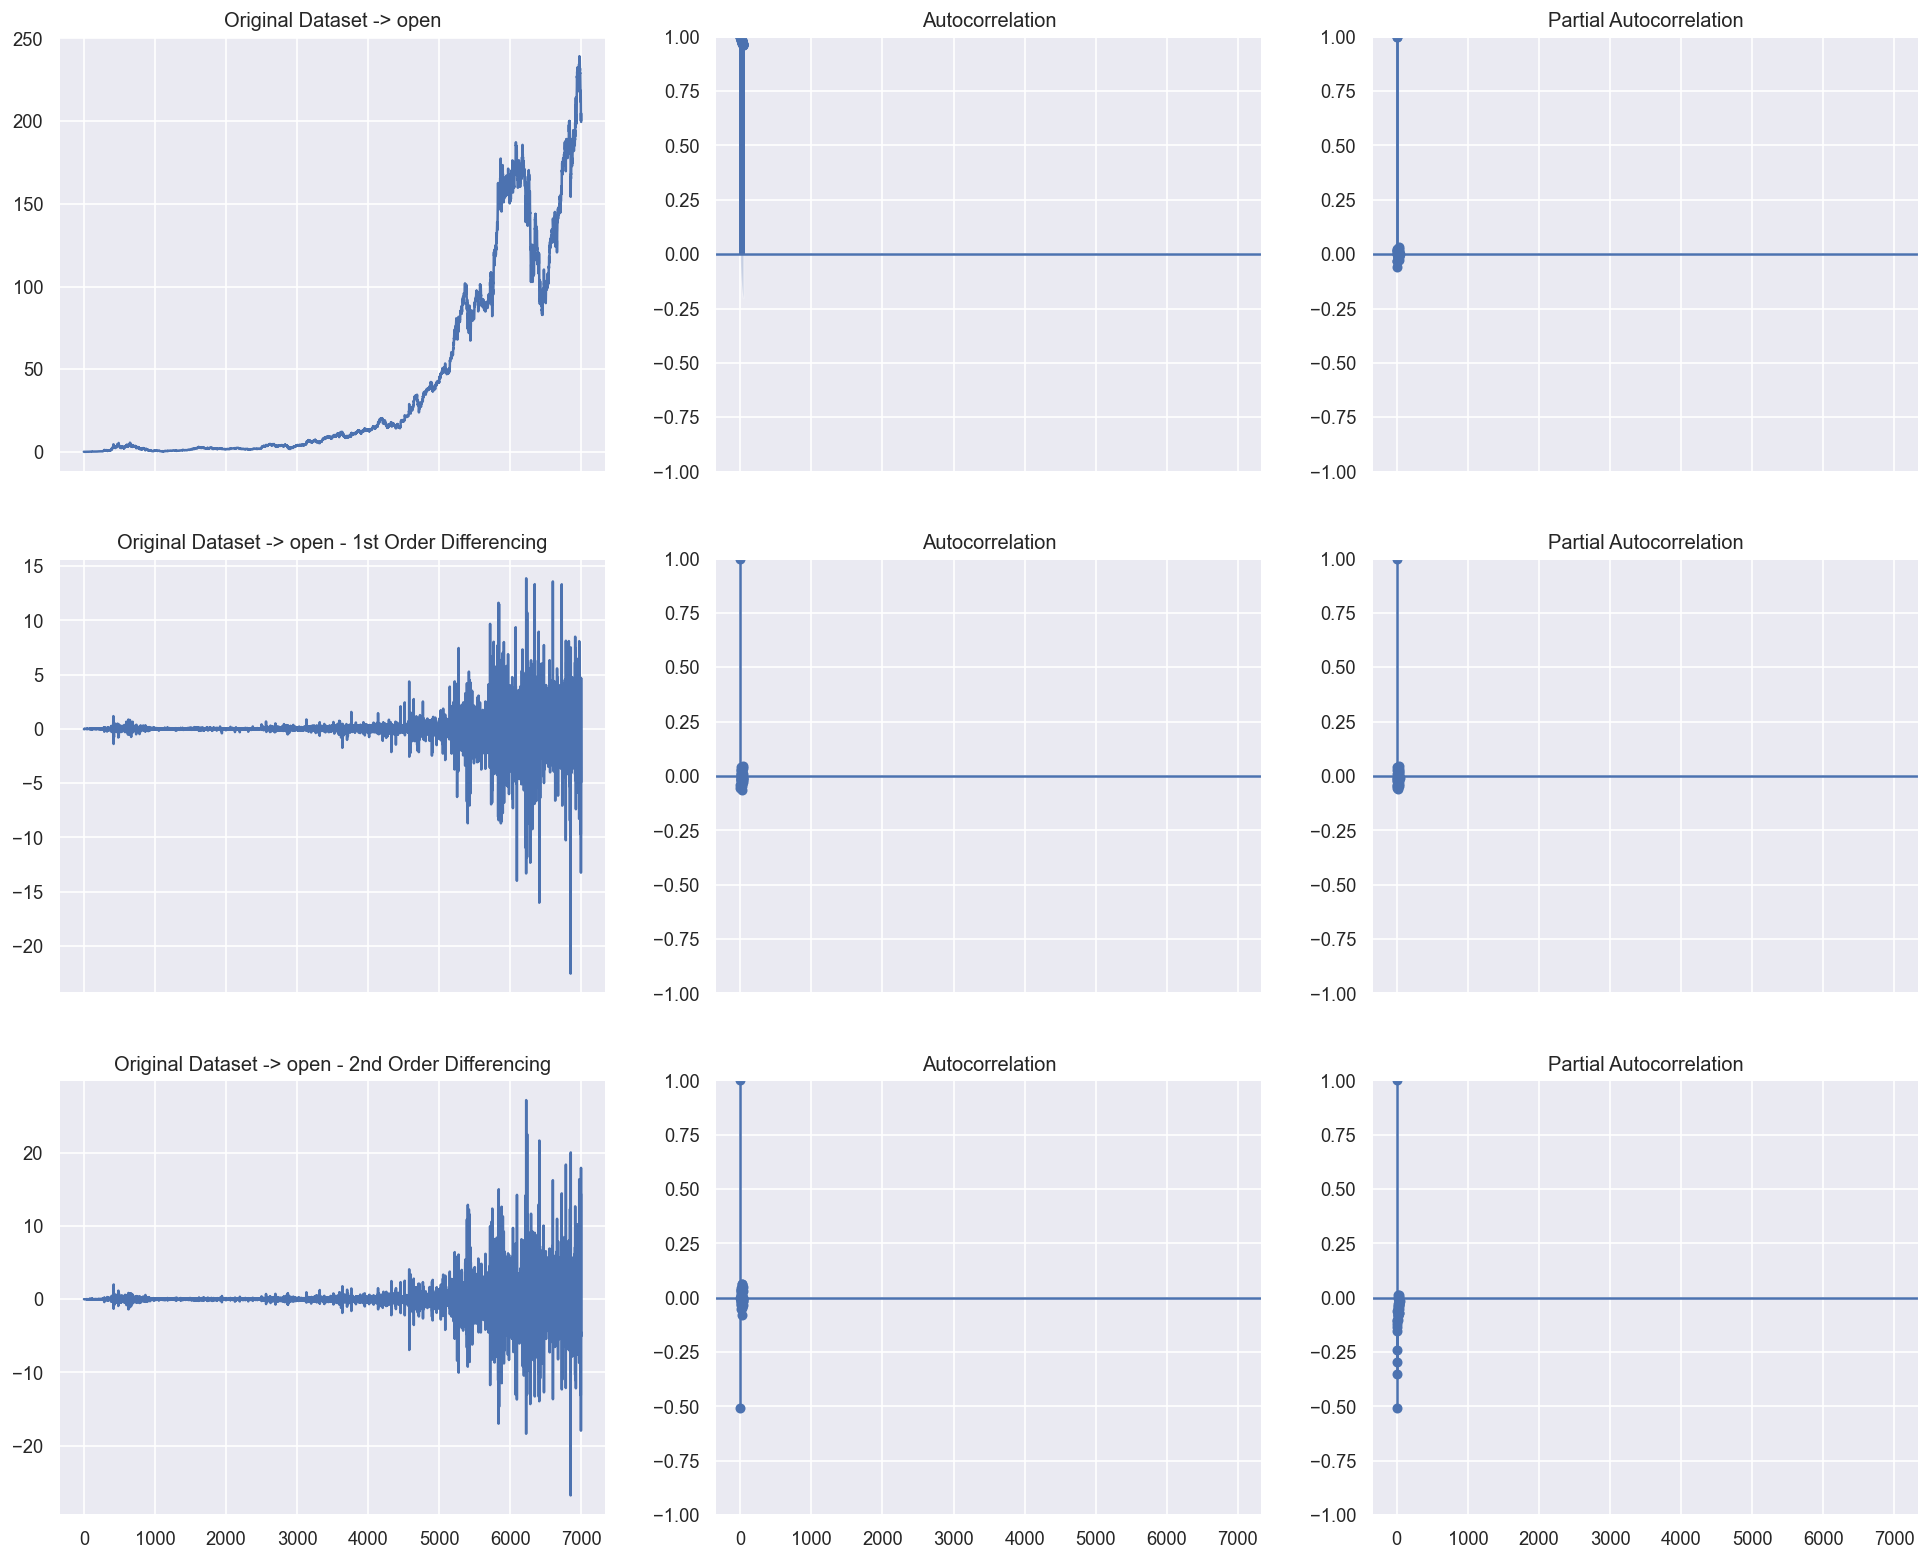

Training based on:
order -> (1, 1, 2)
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 6997
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -12773.865
Date:                Sat, 08 Mar 2025   AIC                          25555.731
Time:                        19:43:06   BIC                          25583.143
Sample:                             0   HQIC                         25565.177
                               - 6997                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0948      0.132      0.720      0.472      -0.163       0.353
ma.L1         -0.1516      0.132     -1.150      0.250      -0.410       0.107
ma.L2         

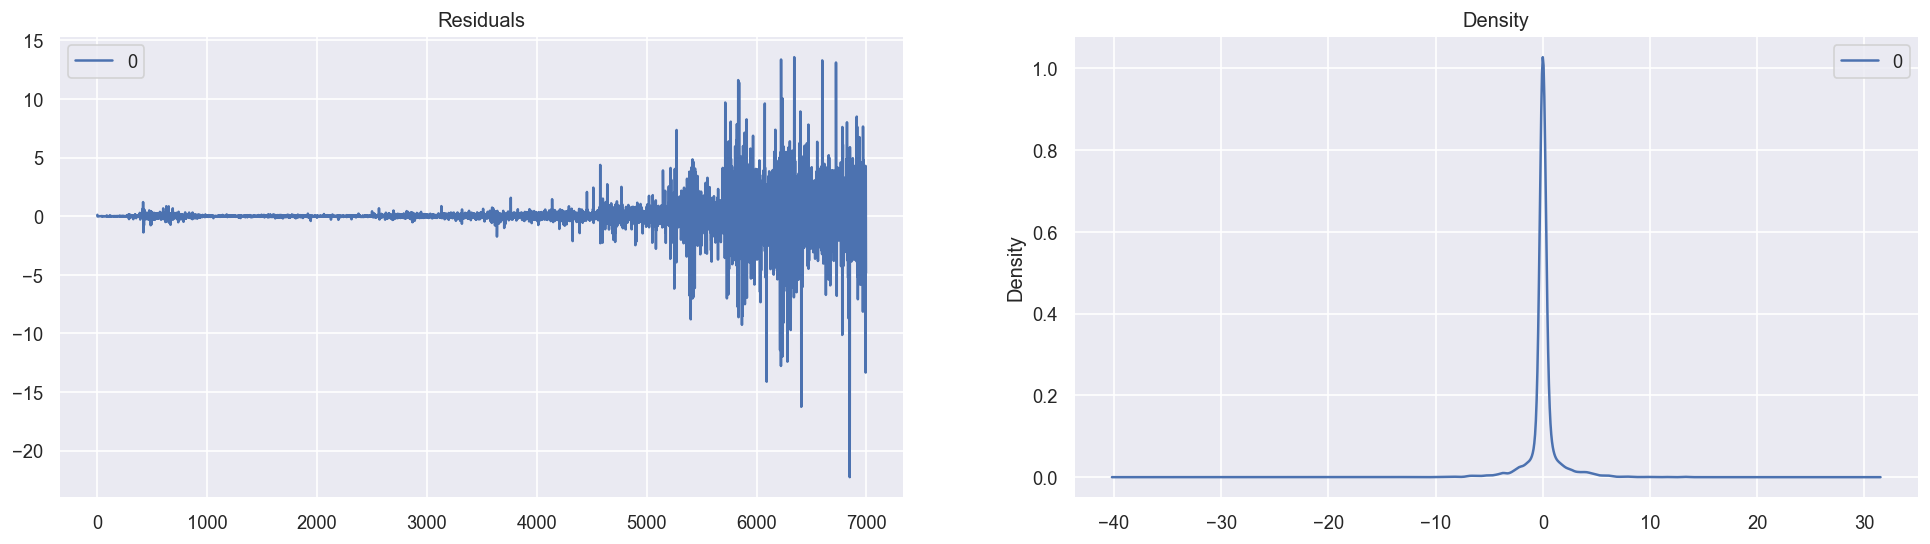

<class 'pandas.core.series.Series'>


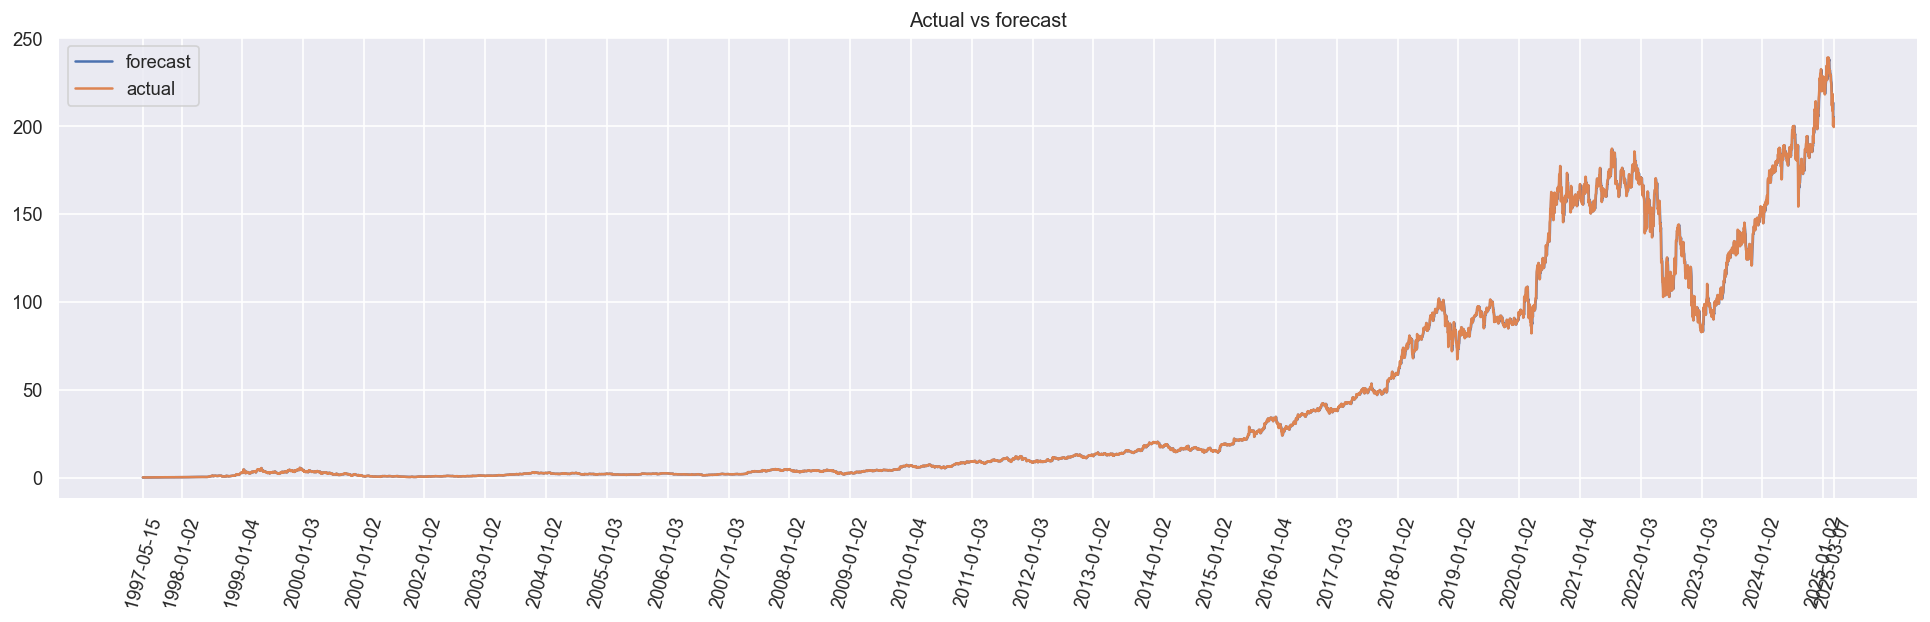

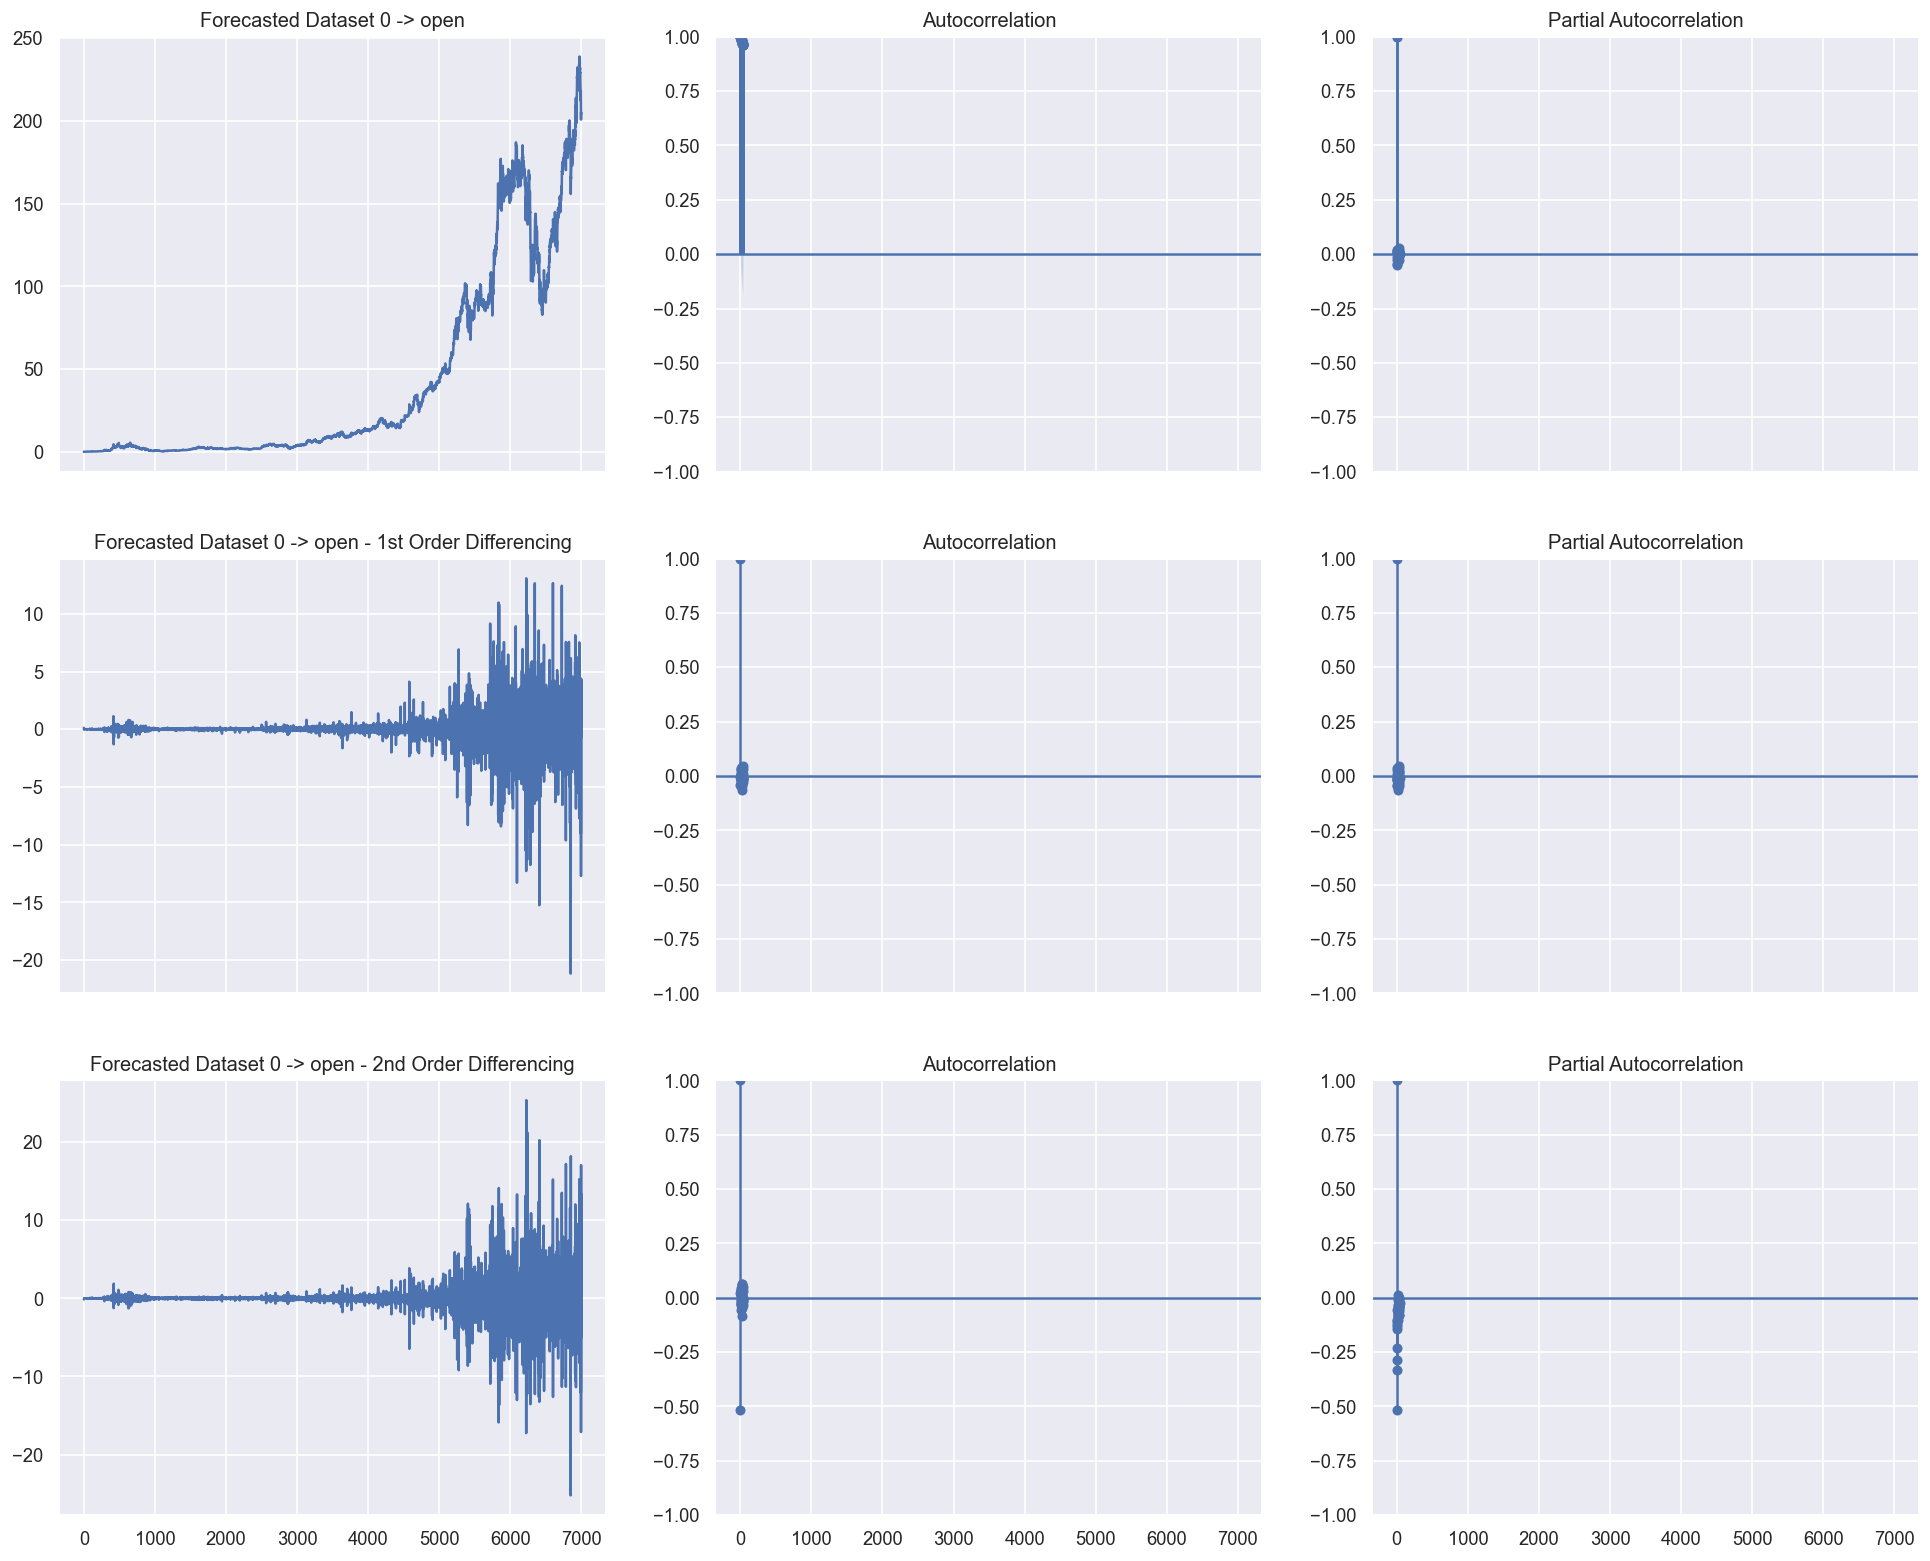

Training based on:
order -> (1, 1, 1)
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 6997
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -12775.455
Date:                Sat, 08 Mar 2025   AIC                          25556.911
Time:                        19:43:08   BIC                          25577.470
Sample:                             0   HQIC                         25563.995
                               - 6997                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3602      0.062      5.763      0.000       0.238       0.483
ma.L1         -0.4215      0.062     -6.827      0.000      -0.542      -0.300
sigma2        

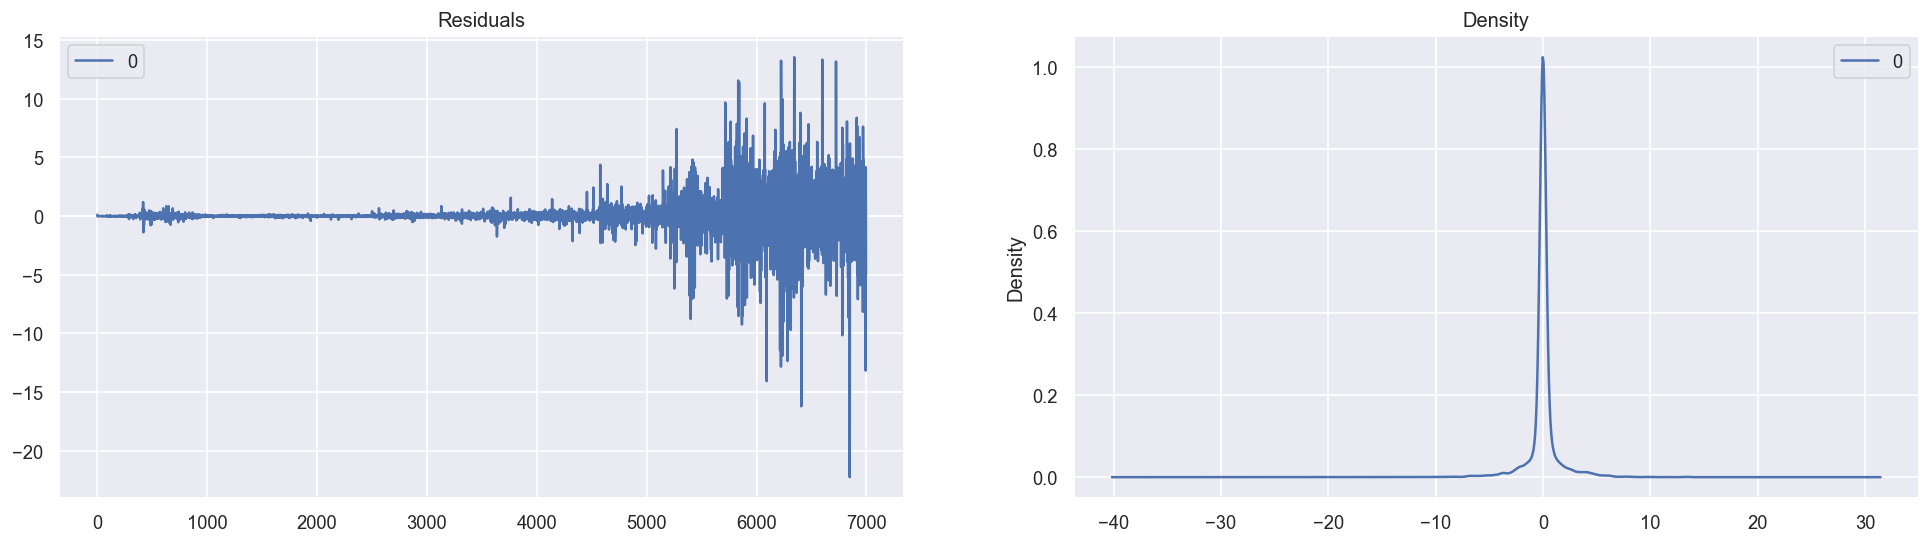

<class 'pandas.core.series.Series'>


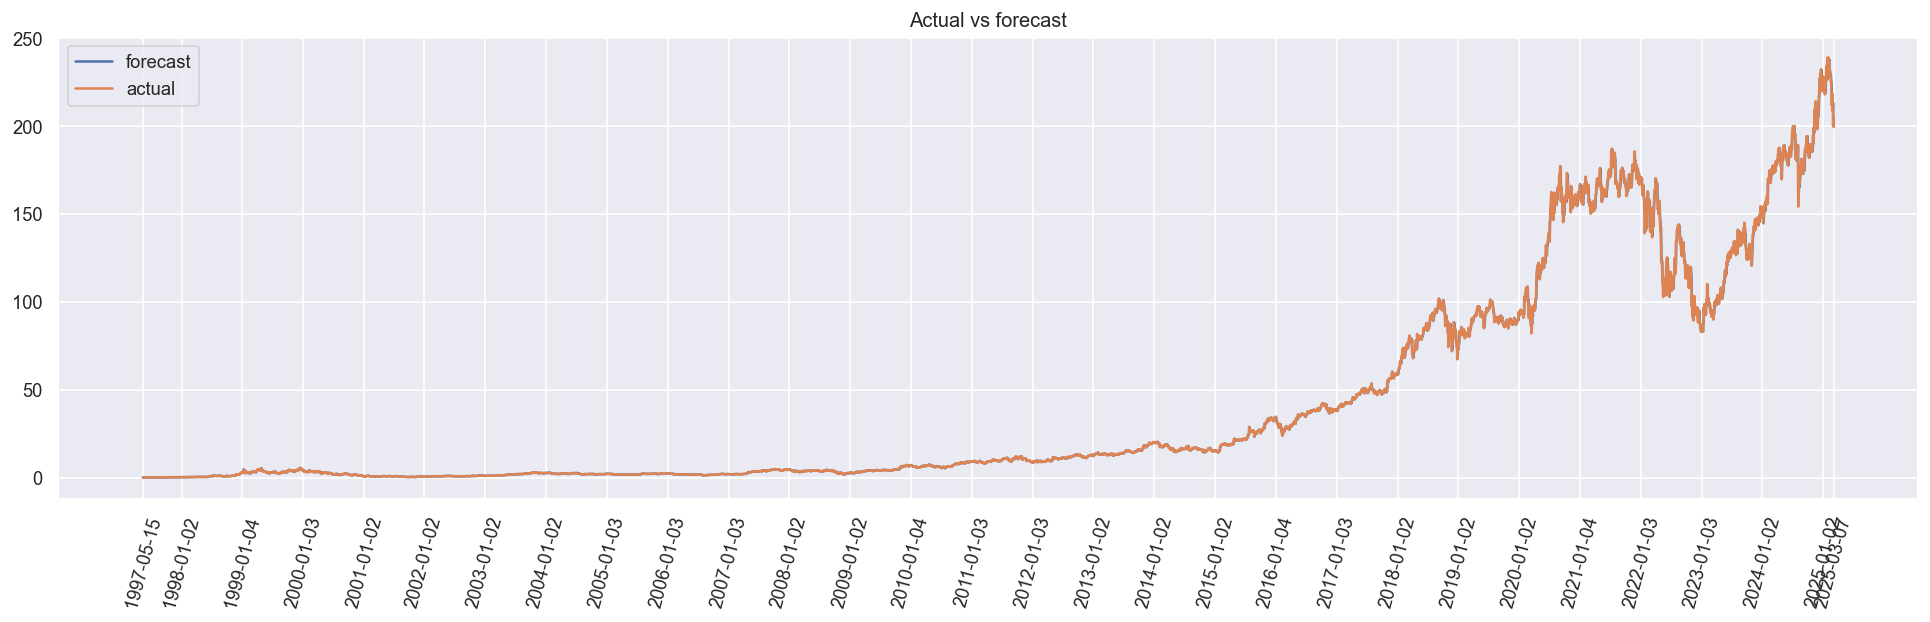

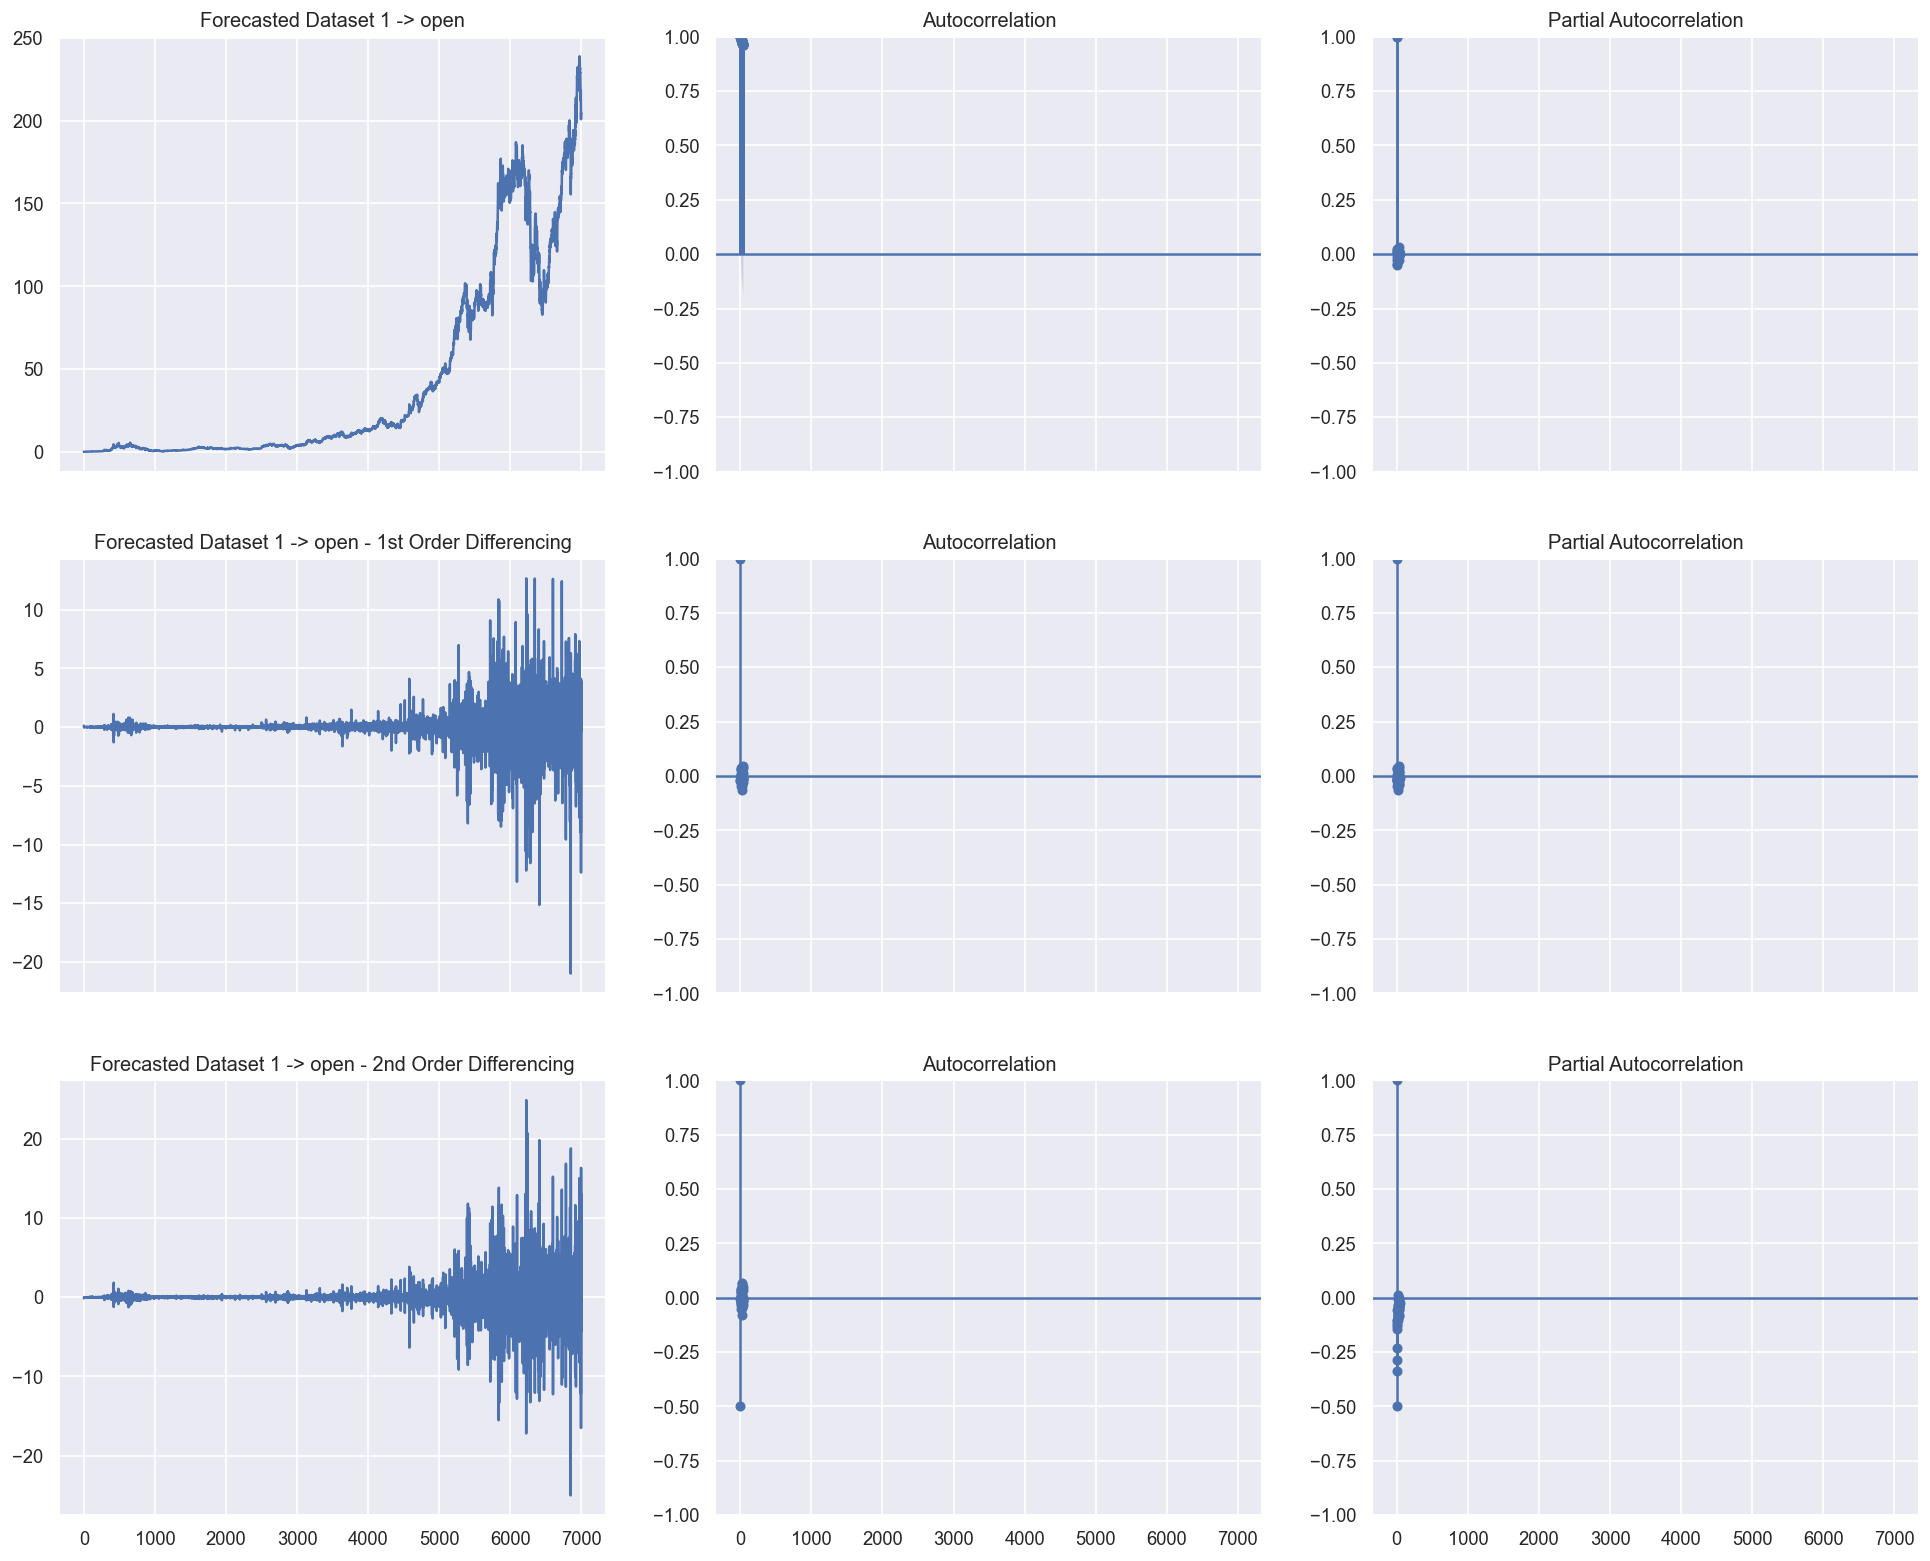

/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_filter['year'] = date_filter['date'].str.split('-').str[0]
/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_filter.loc[0] = dataset.iloc[0]
/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

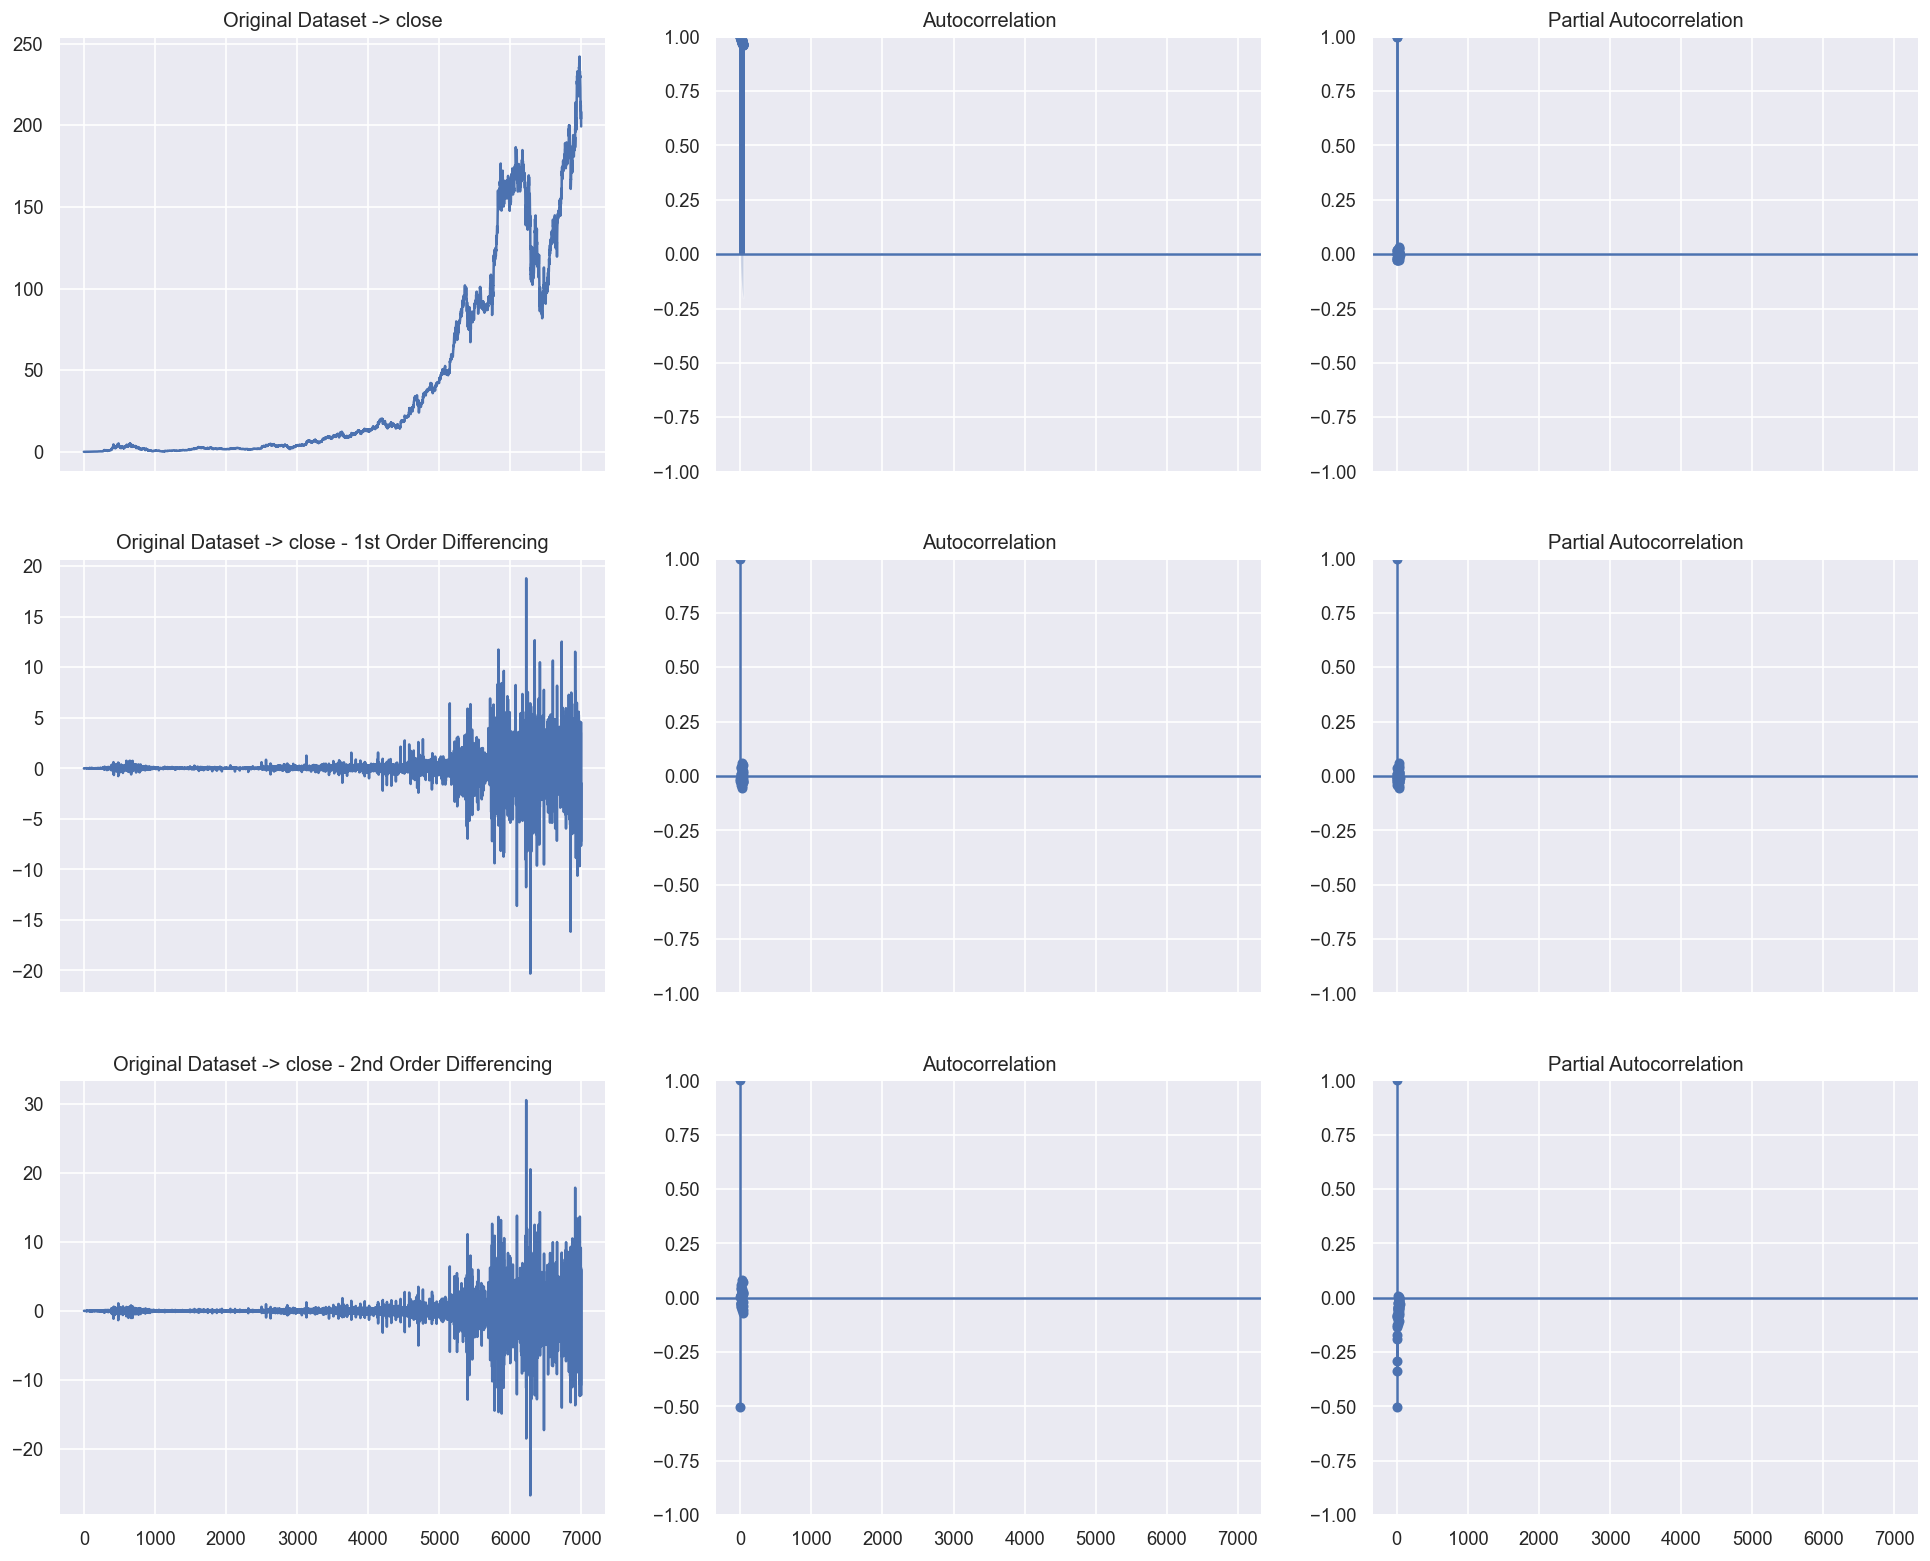

Training based on:
order -> (1, 1, 2)
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 6997
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -12501.366
Date:                Sat, 08 Mar 2025   AIC                          25010.731
Time:                        19:43:11   BIC                          25038.144
Sample:                             0   HQIC                         25020.177
                               - 6997                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1165      0.370      0.315      0.753      -0.608       0.841
ma.L1         -0.1391      0.370     -0.376      0.707      -0.865       0.587
ma.L2         

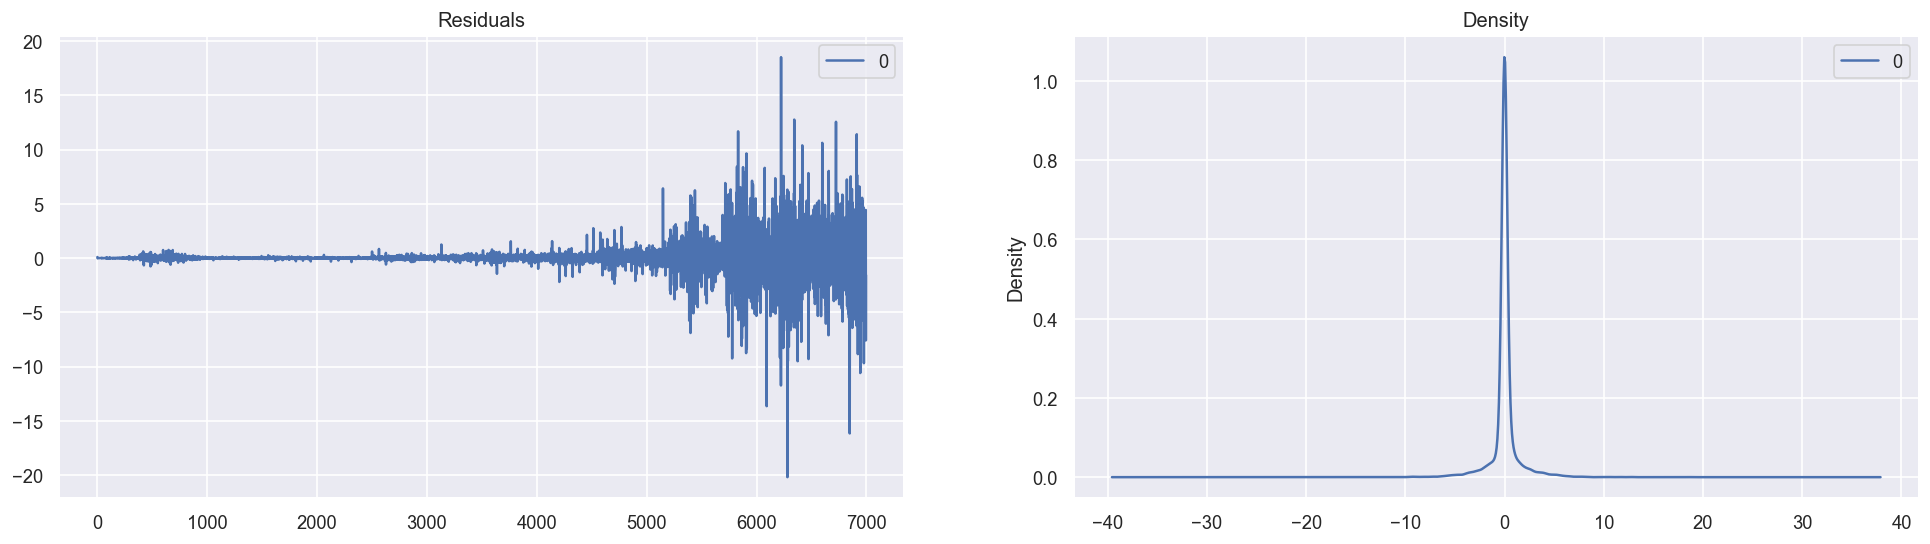

<class 'pandas.core.series.Series'>


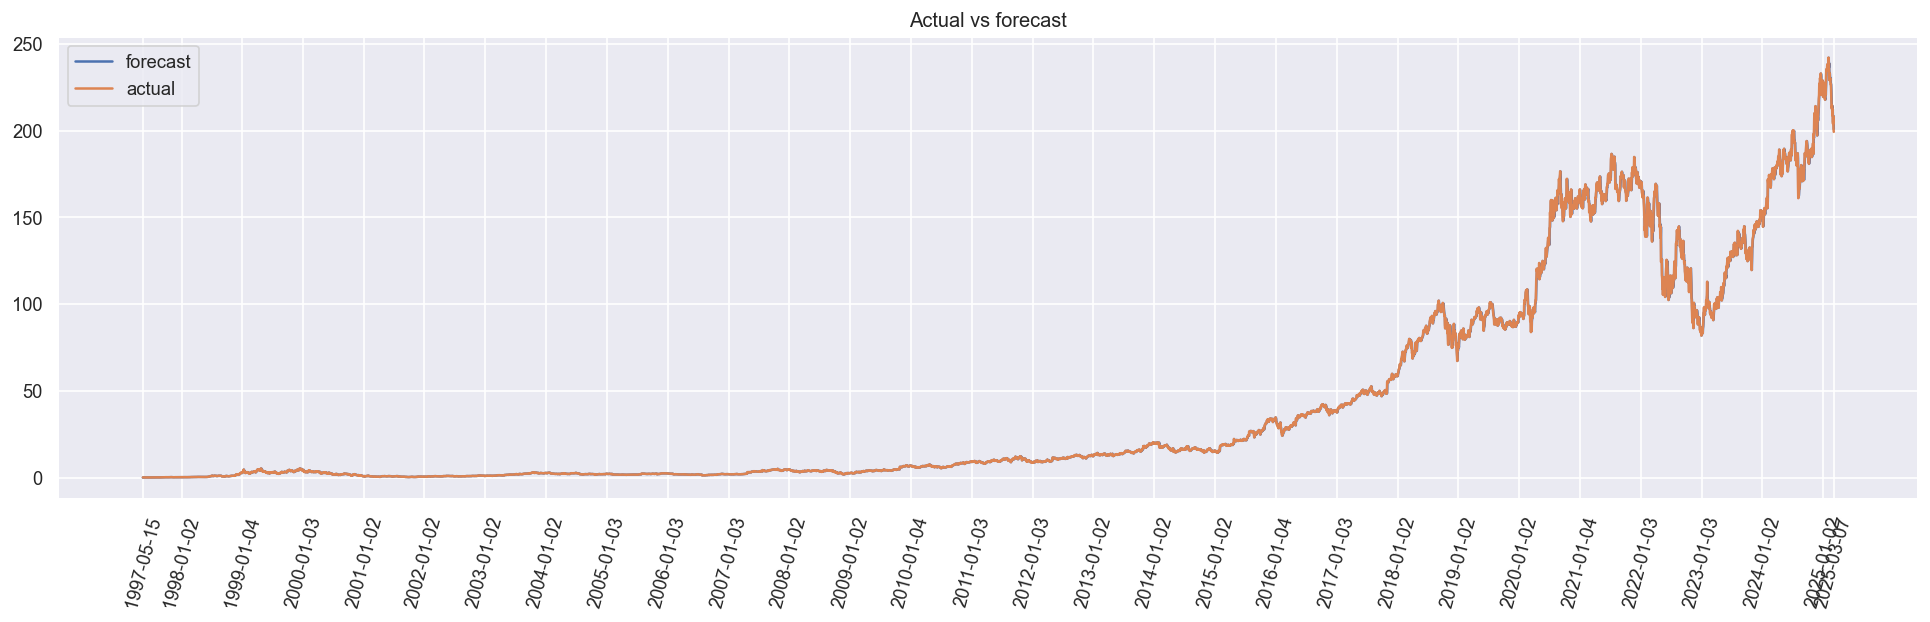

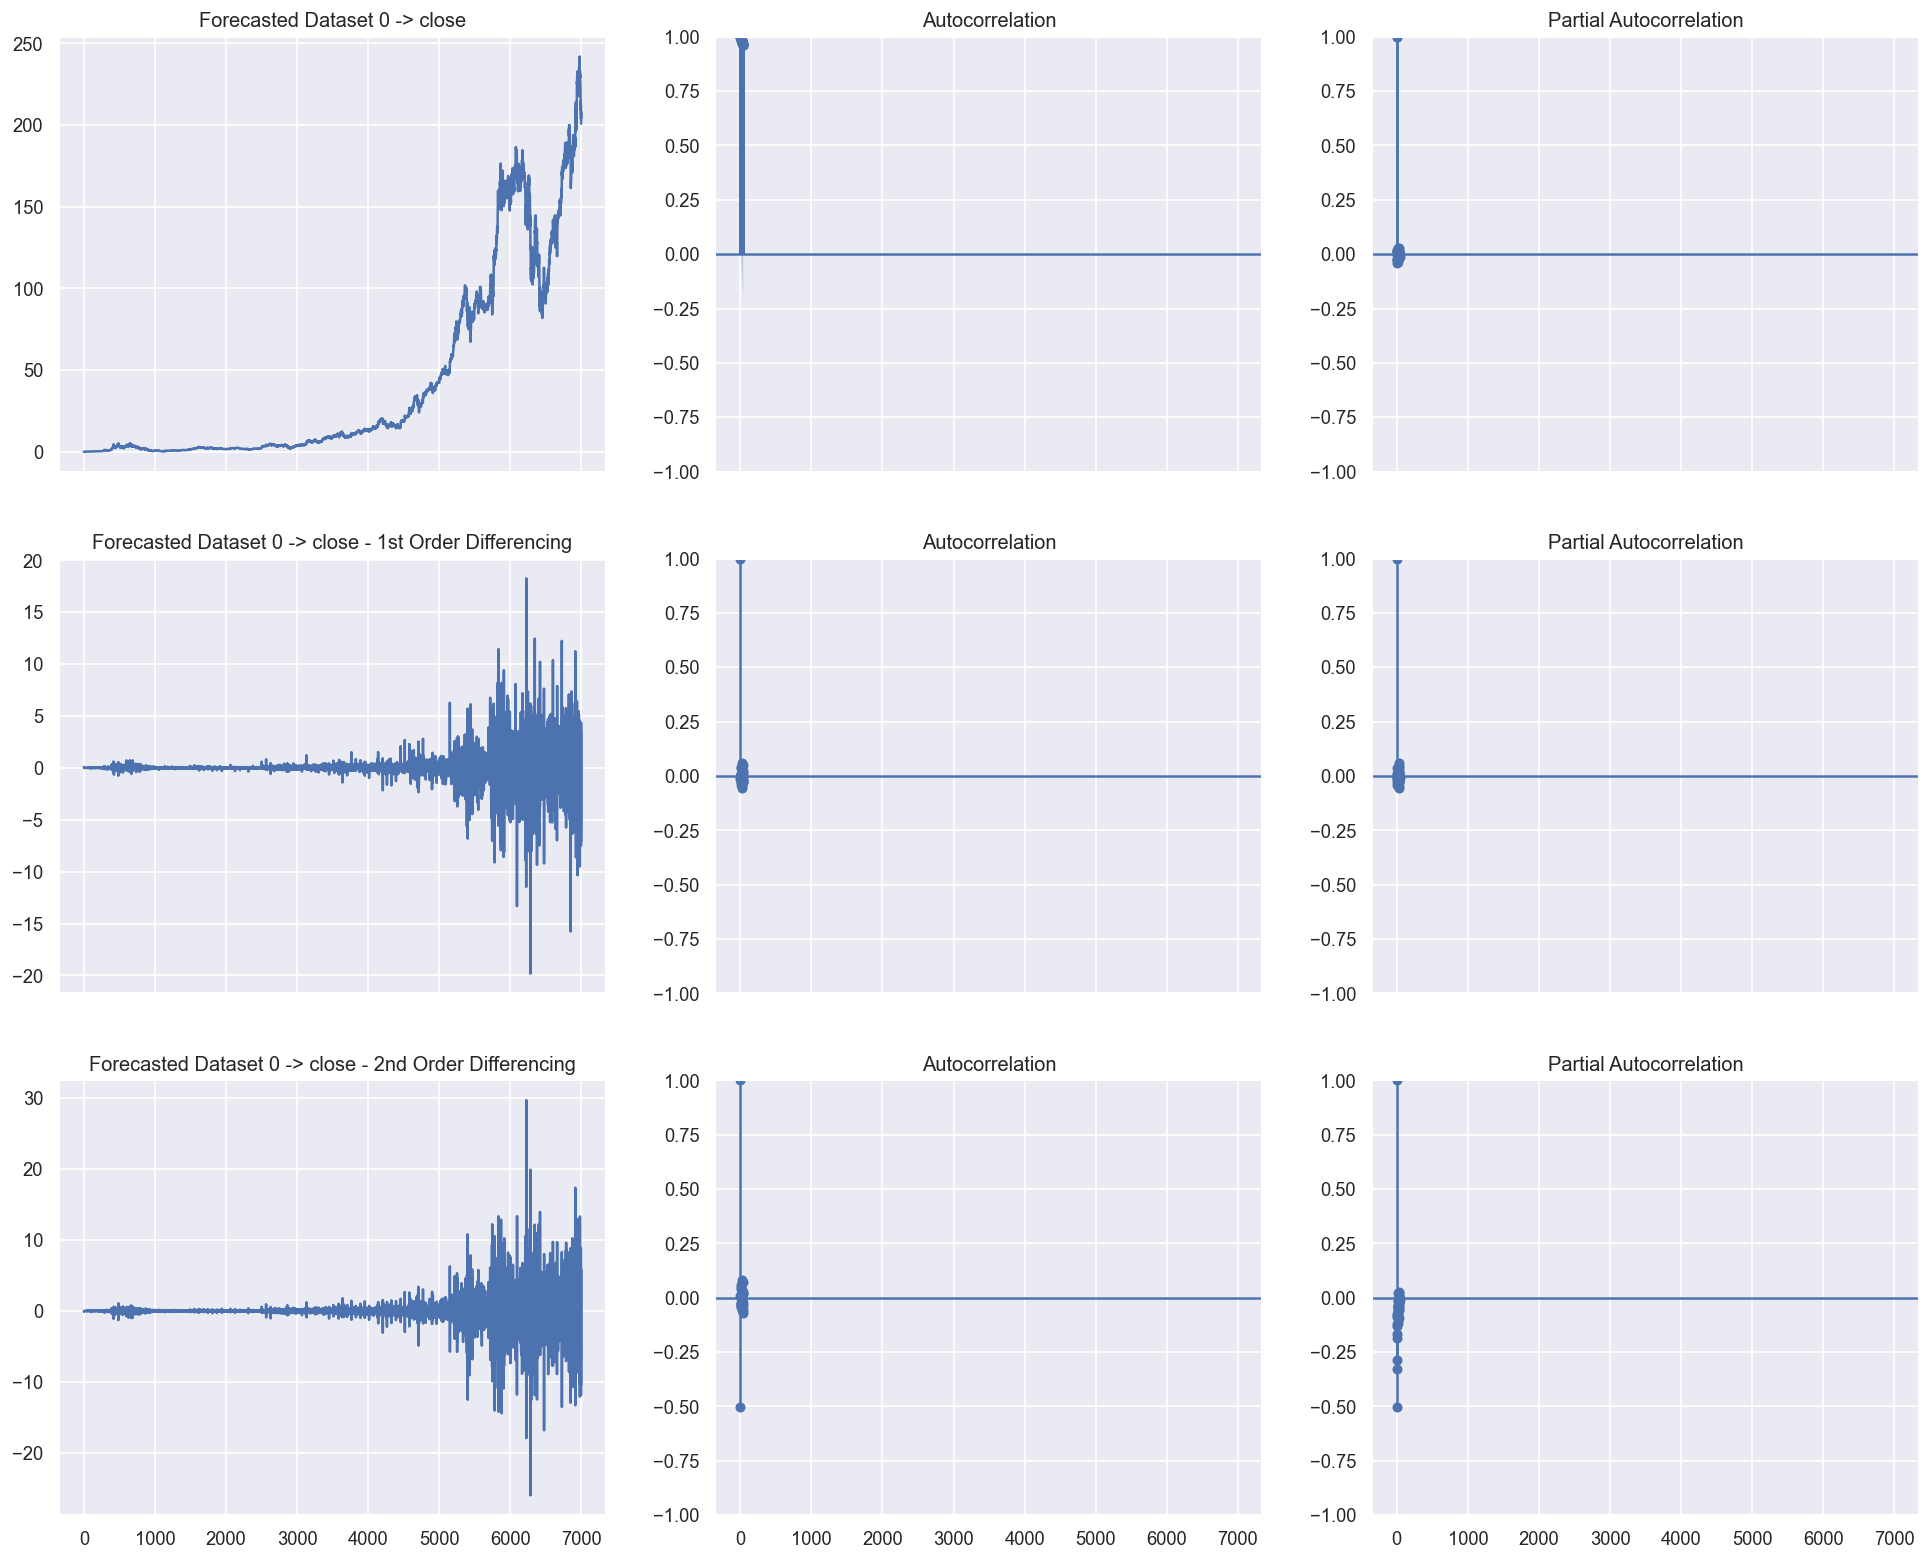

Training based on:
order -> (1, 1, 1)
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 6997
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -12501.569
Date:                Sat, 08 Mar 2025   AIC                          25009.138
Time:                        19:43:13   BIC                          25029.697
Sample:                             0   HQIC                         25016.223
                               - 6997                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3120      0.177      1.767      0.077      -0.034       0.658
ma.L1         -0.3359      0.176     -1.909      0.056      -0.681       0.009
sigma2        

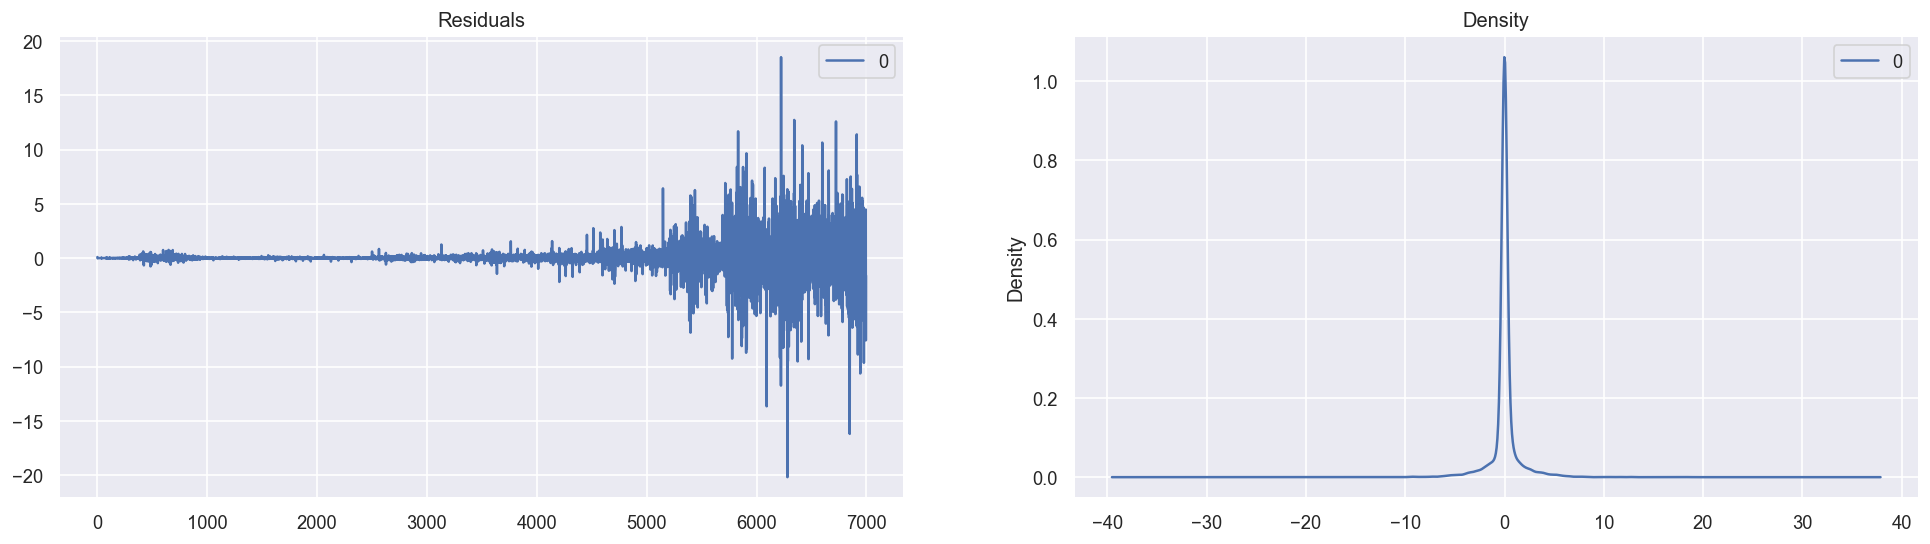

<class 'pandas.core.series.Series'>


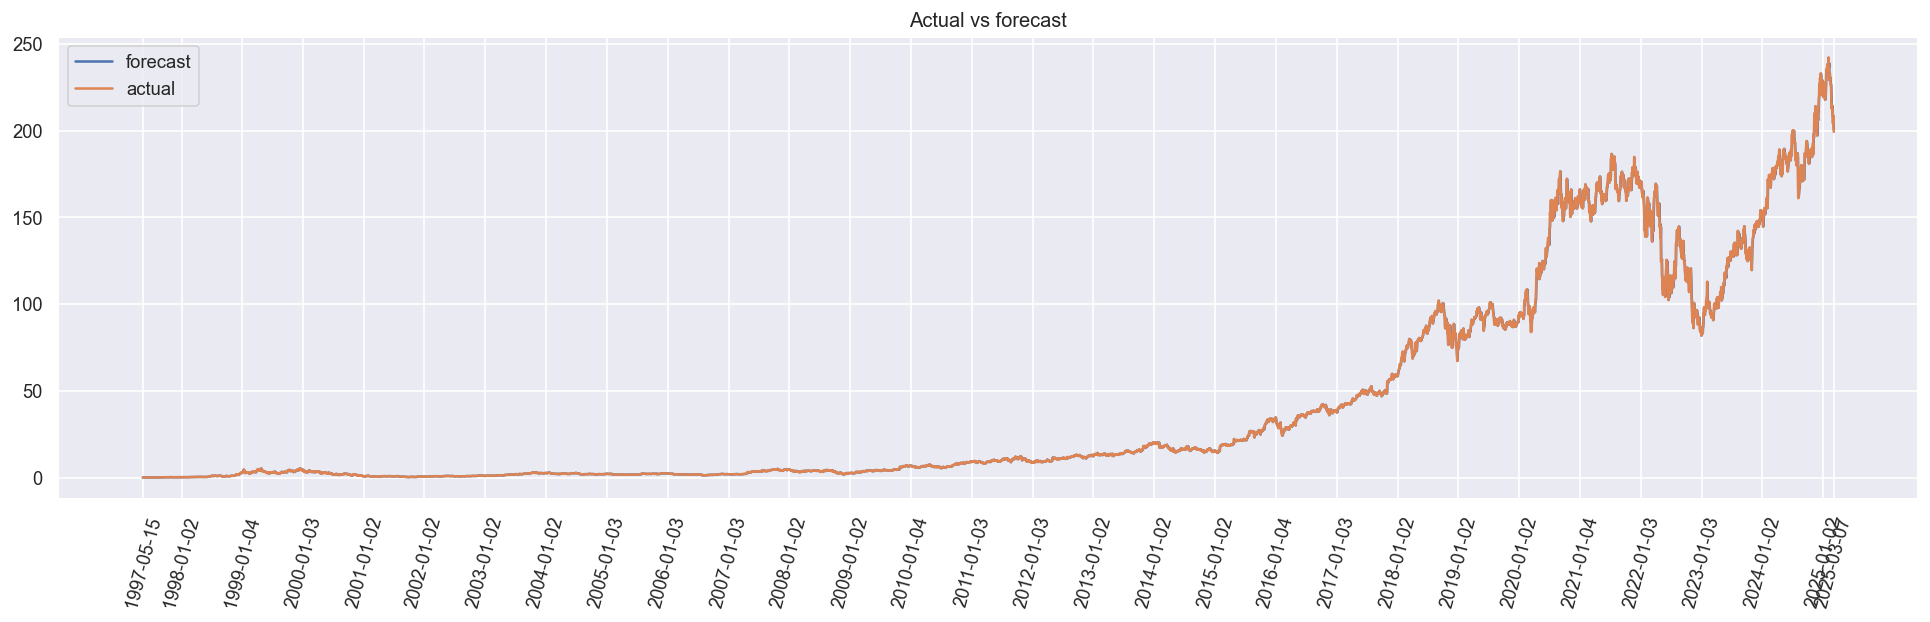

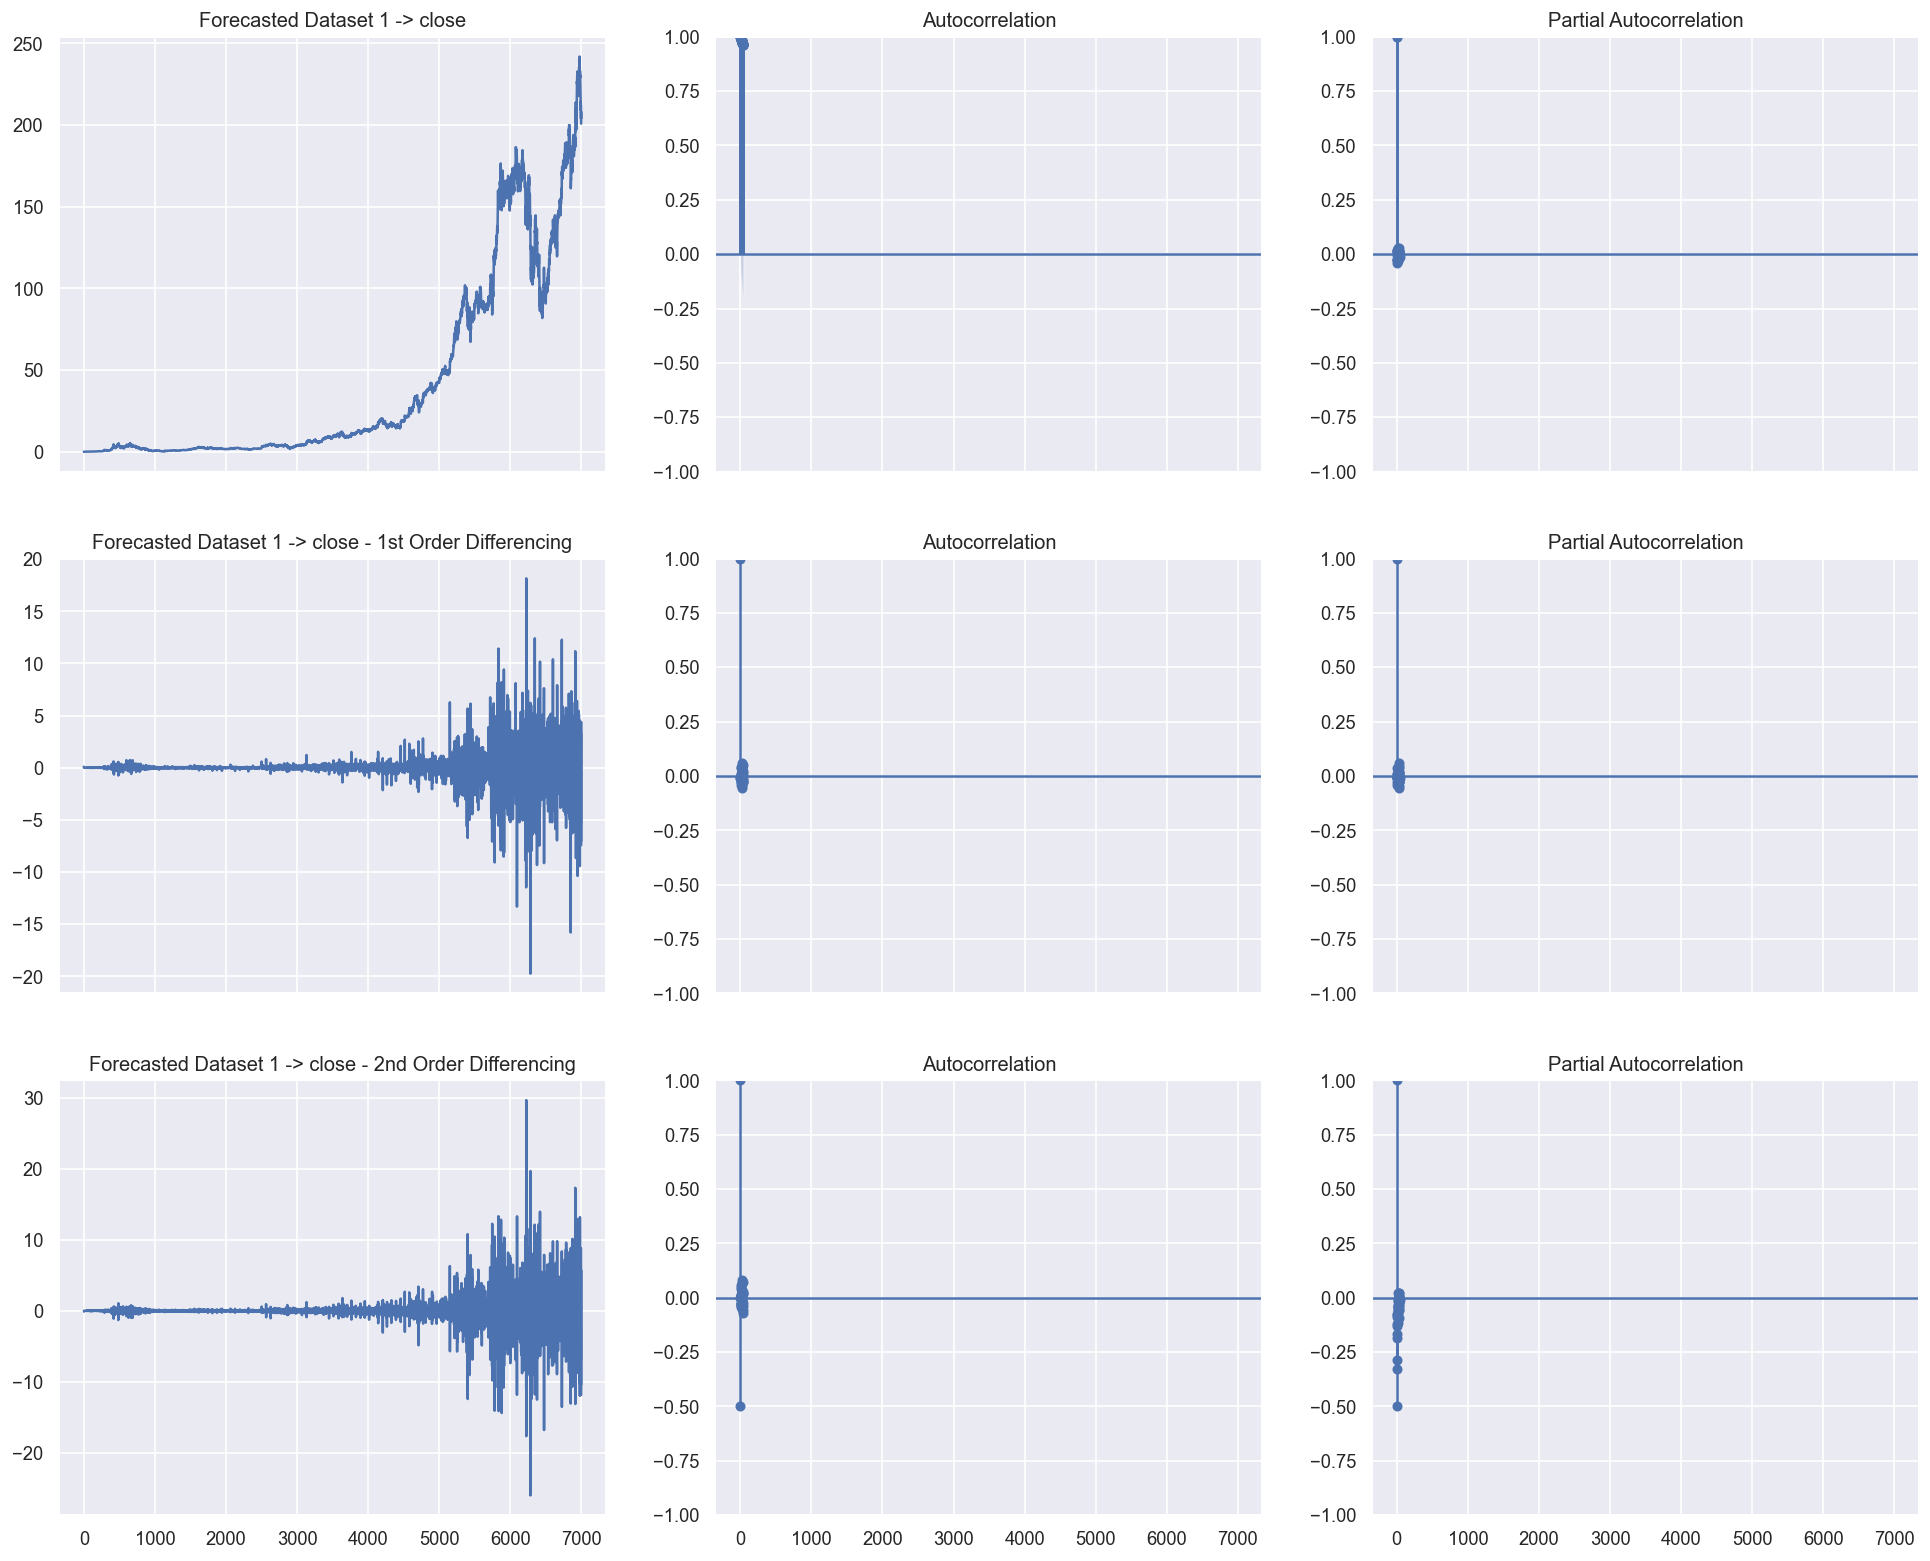

/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_filter['year'] = date_filter['date'].str.split('-').str[0]
/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_filter.loc[0] = dataset.iloc[0]
/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

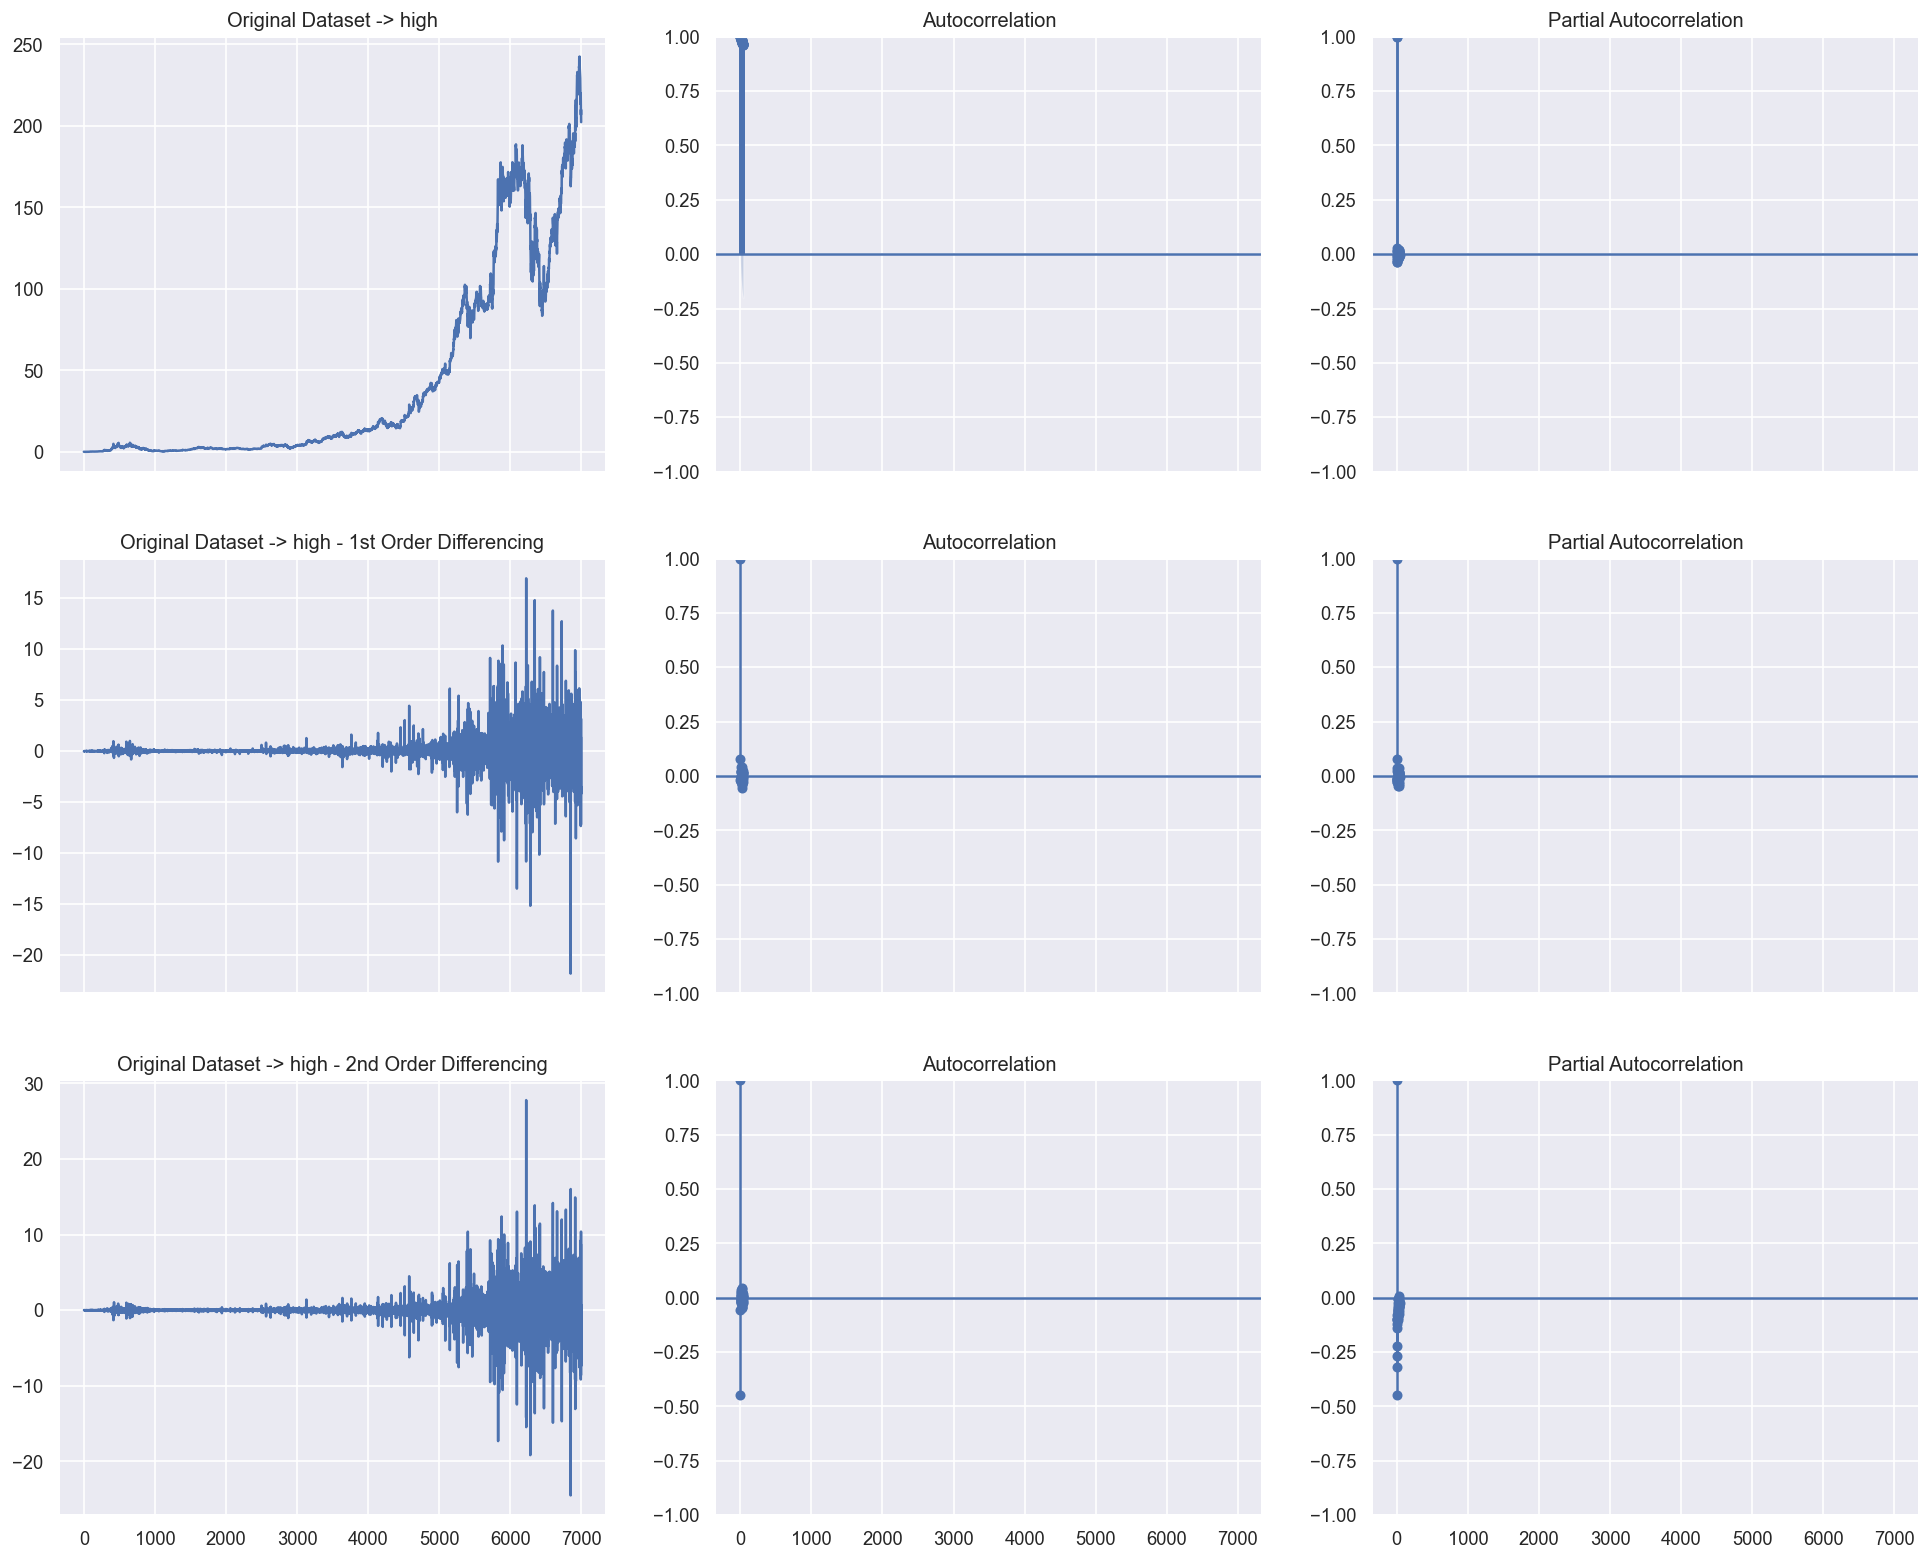

Training based on:
order -> (1, 1, 2)
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 6997
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -11765.981
Date:                Sat, 08 Mar 2025   AIC                          23539.962
Time:                        19:43:16   BIC                          23567.374
Sample:                             0   HQIC                         23549.408
                               - 6997                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9249      0.060     15.536      0.000       0.808       1.042
ma.L1         -0.8439      0.059    -14.351      0.000      -0.959      -0.729
ma.L2         

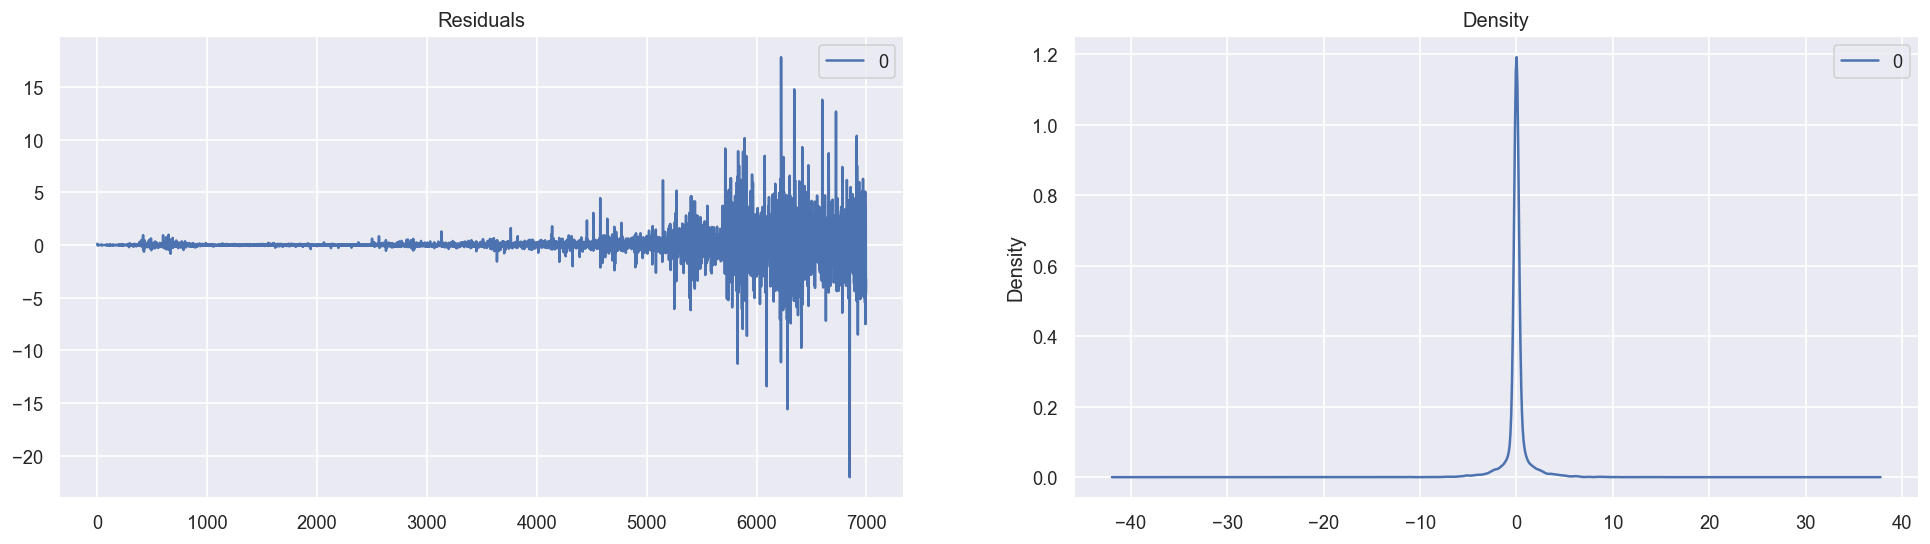

<class 'pandas.core.series.Series'>


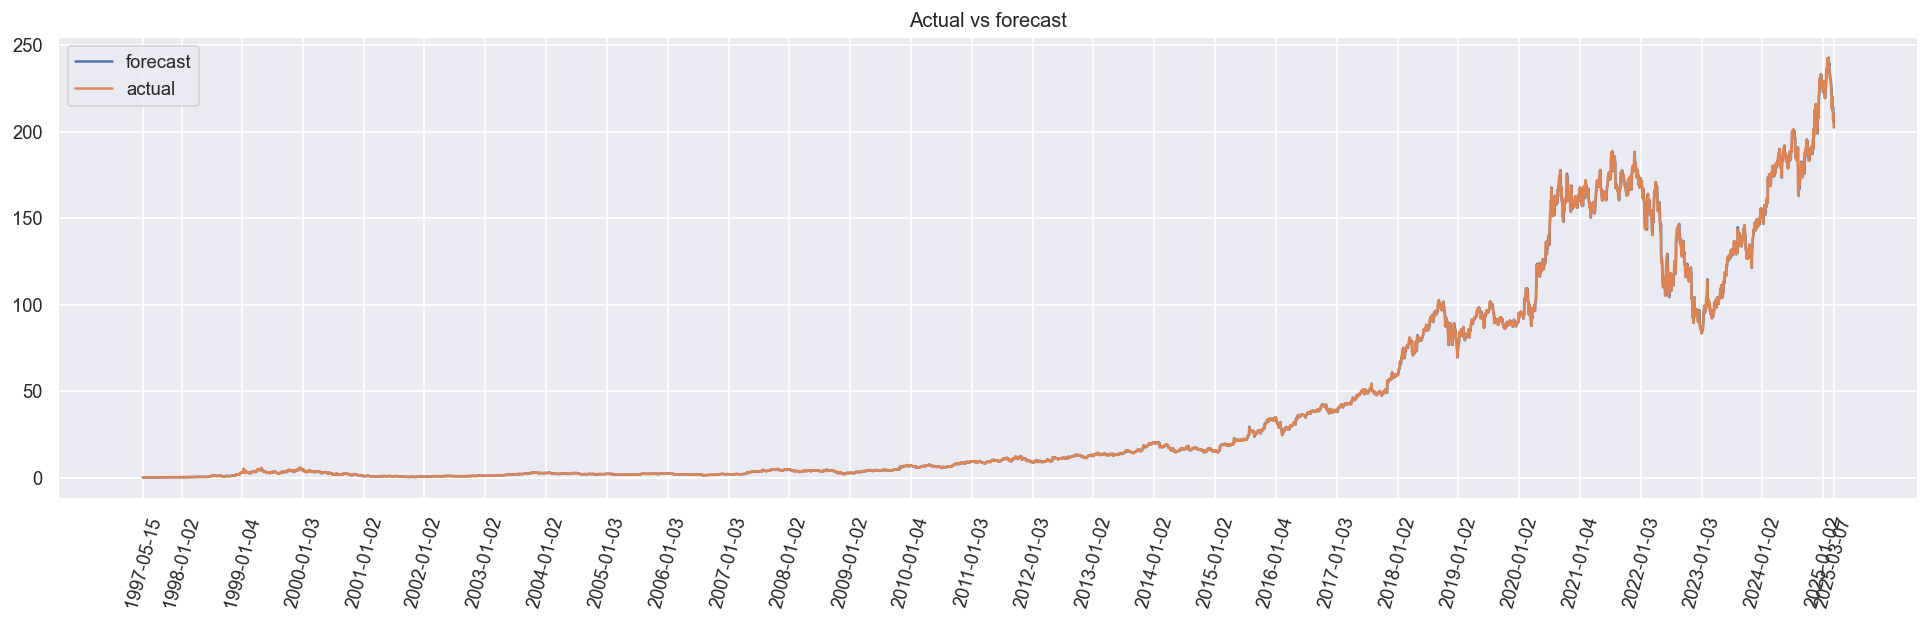

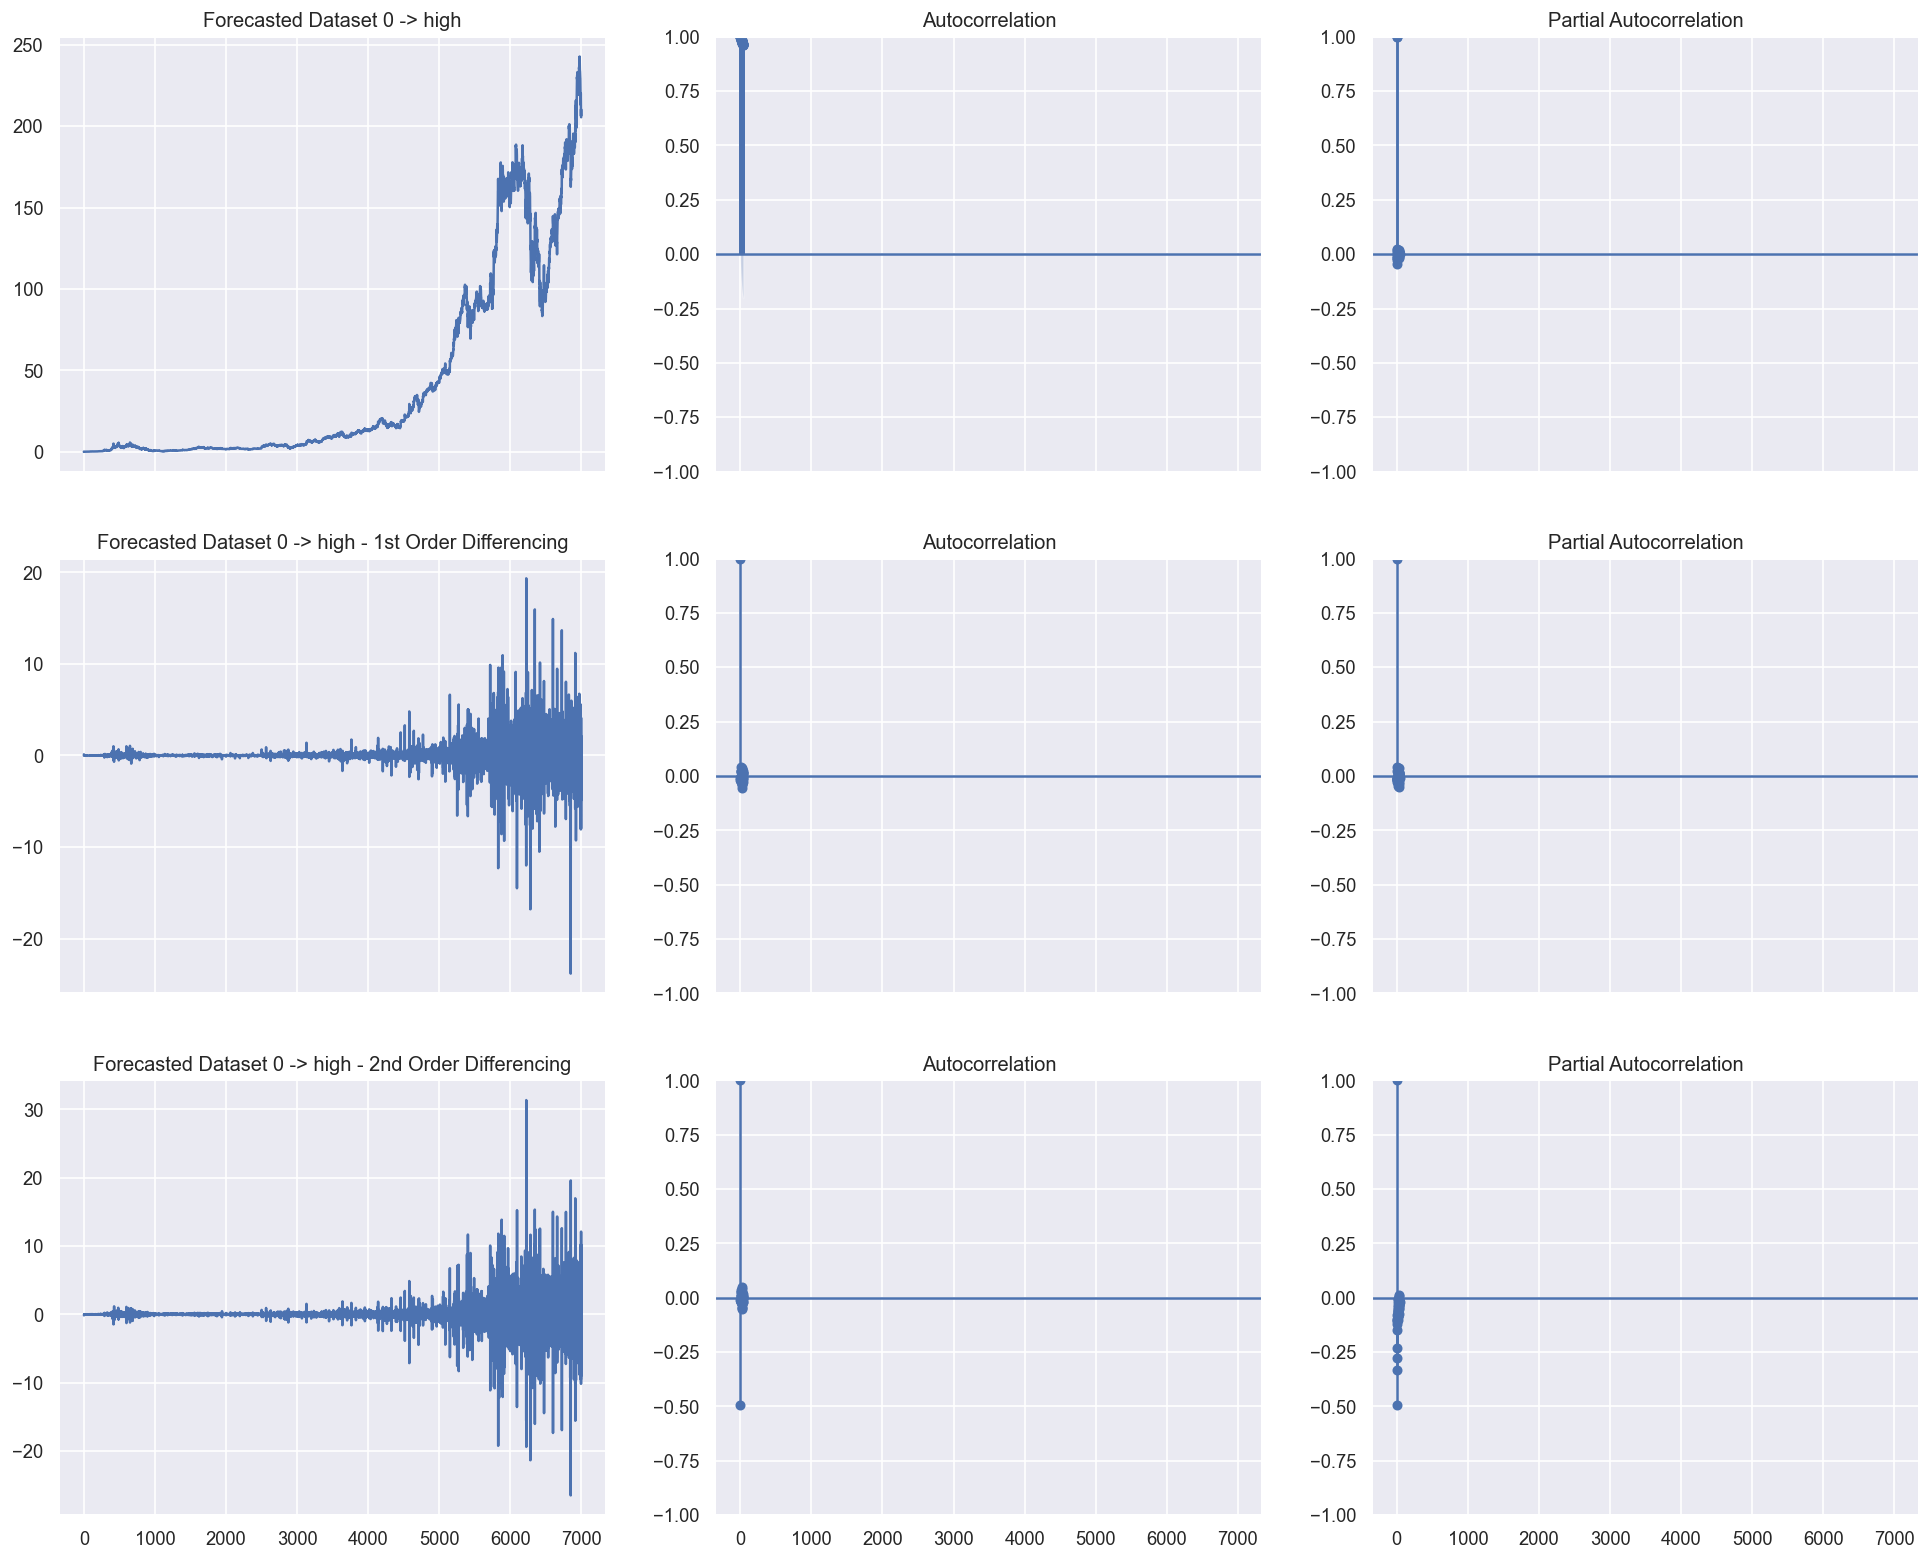

Training based on:
order -> (1, 1, 1)
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 6997
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11765.770
Date:                Sat, 08 Mar 2025   AIC                          23537.540
Time:                        19:43:18   BIC                          23558.099
Sample:                             0   HQIC                         23544.624
                               - 6997                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1507      0.067     -2.247      0.025      -0.282      -0.019
ma.L1          0.2311      0.066      3.514      0.000       0.102       0.360
sigma2        

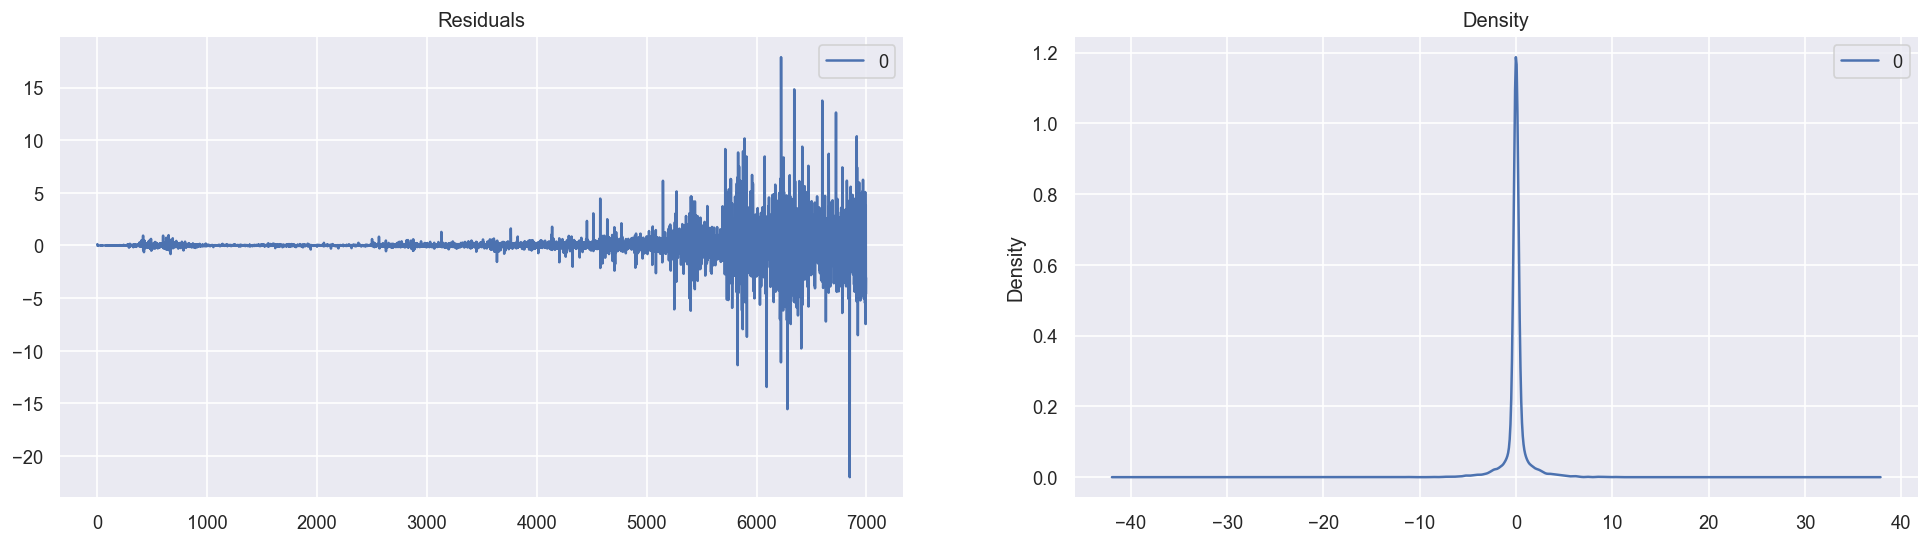

<class 'pandas.core.series.Series'>


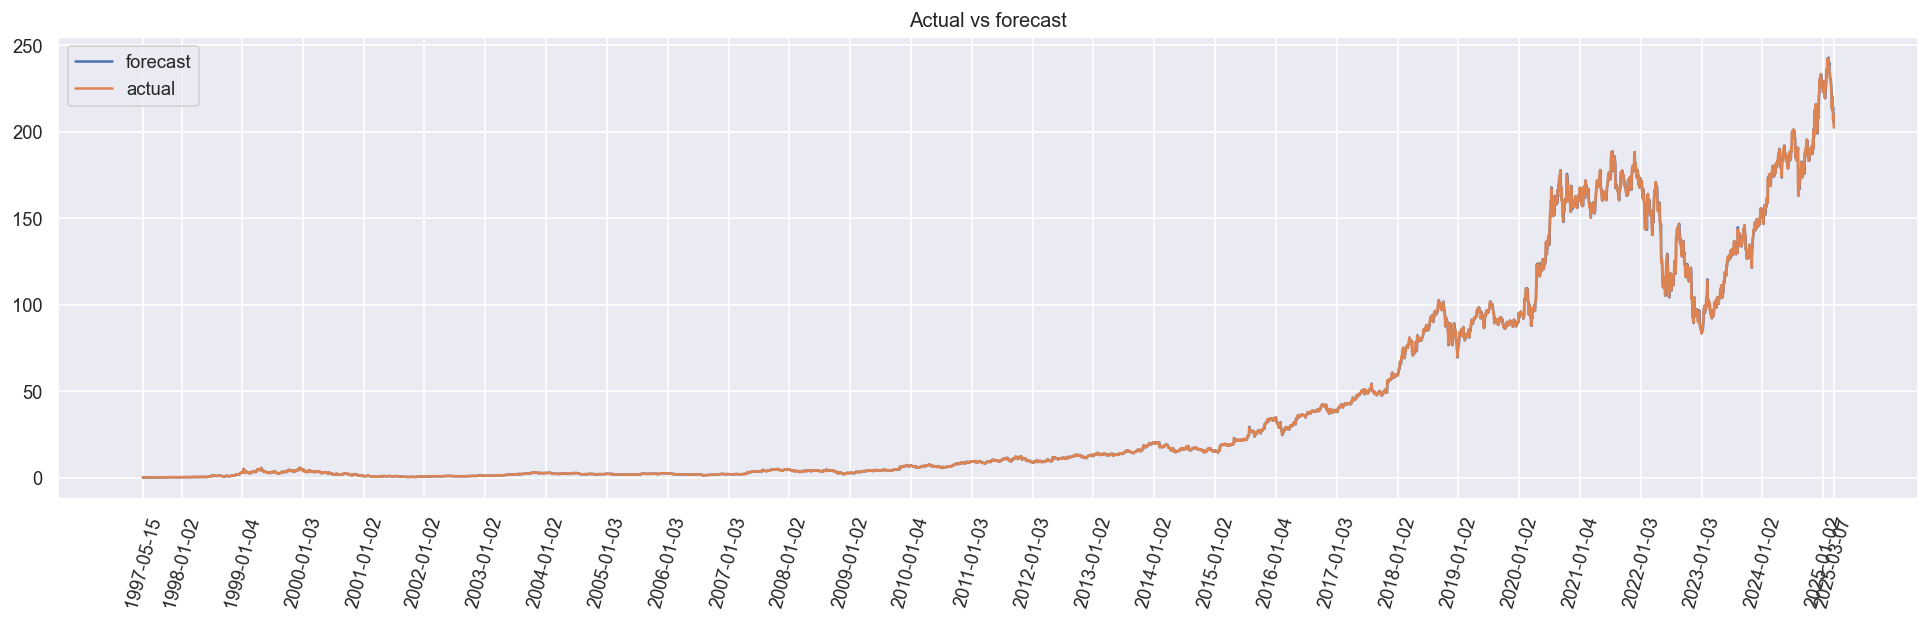

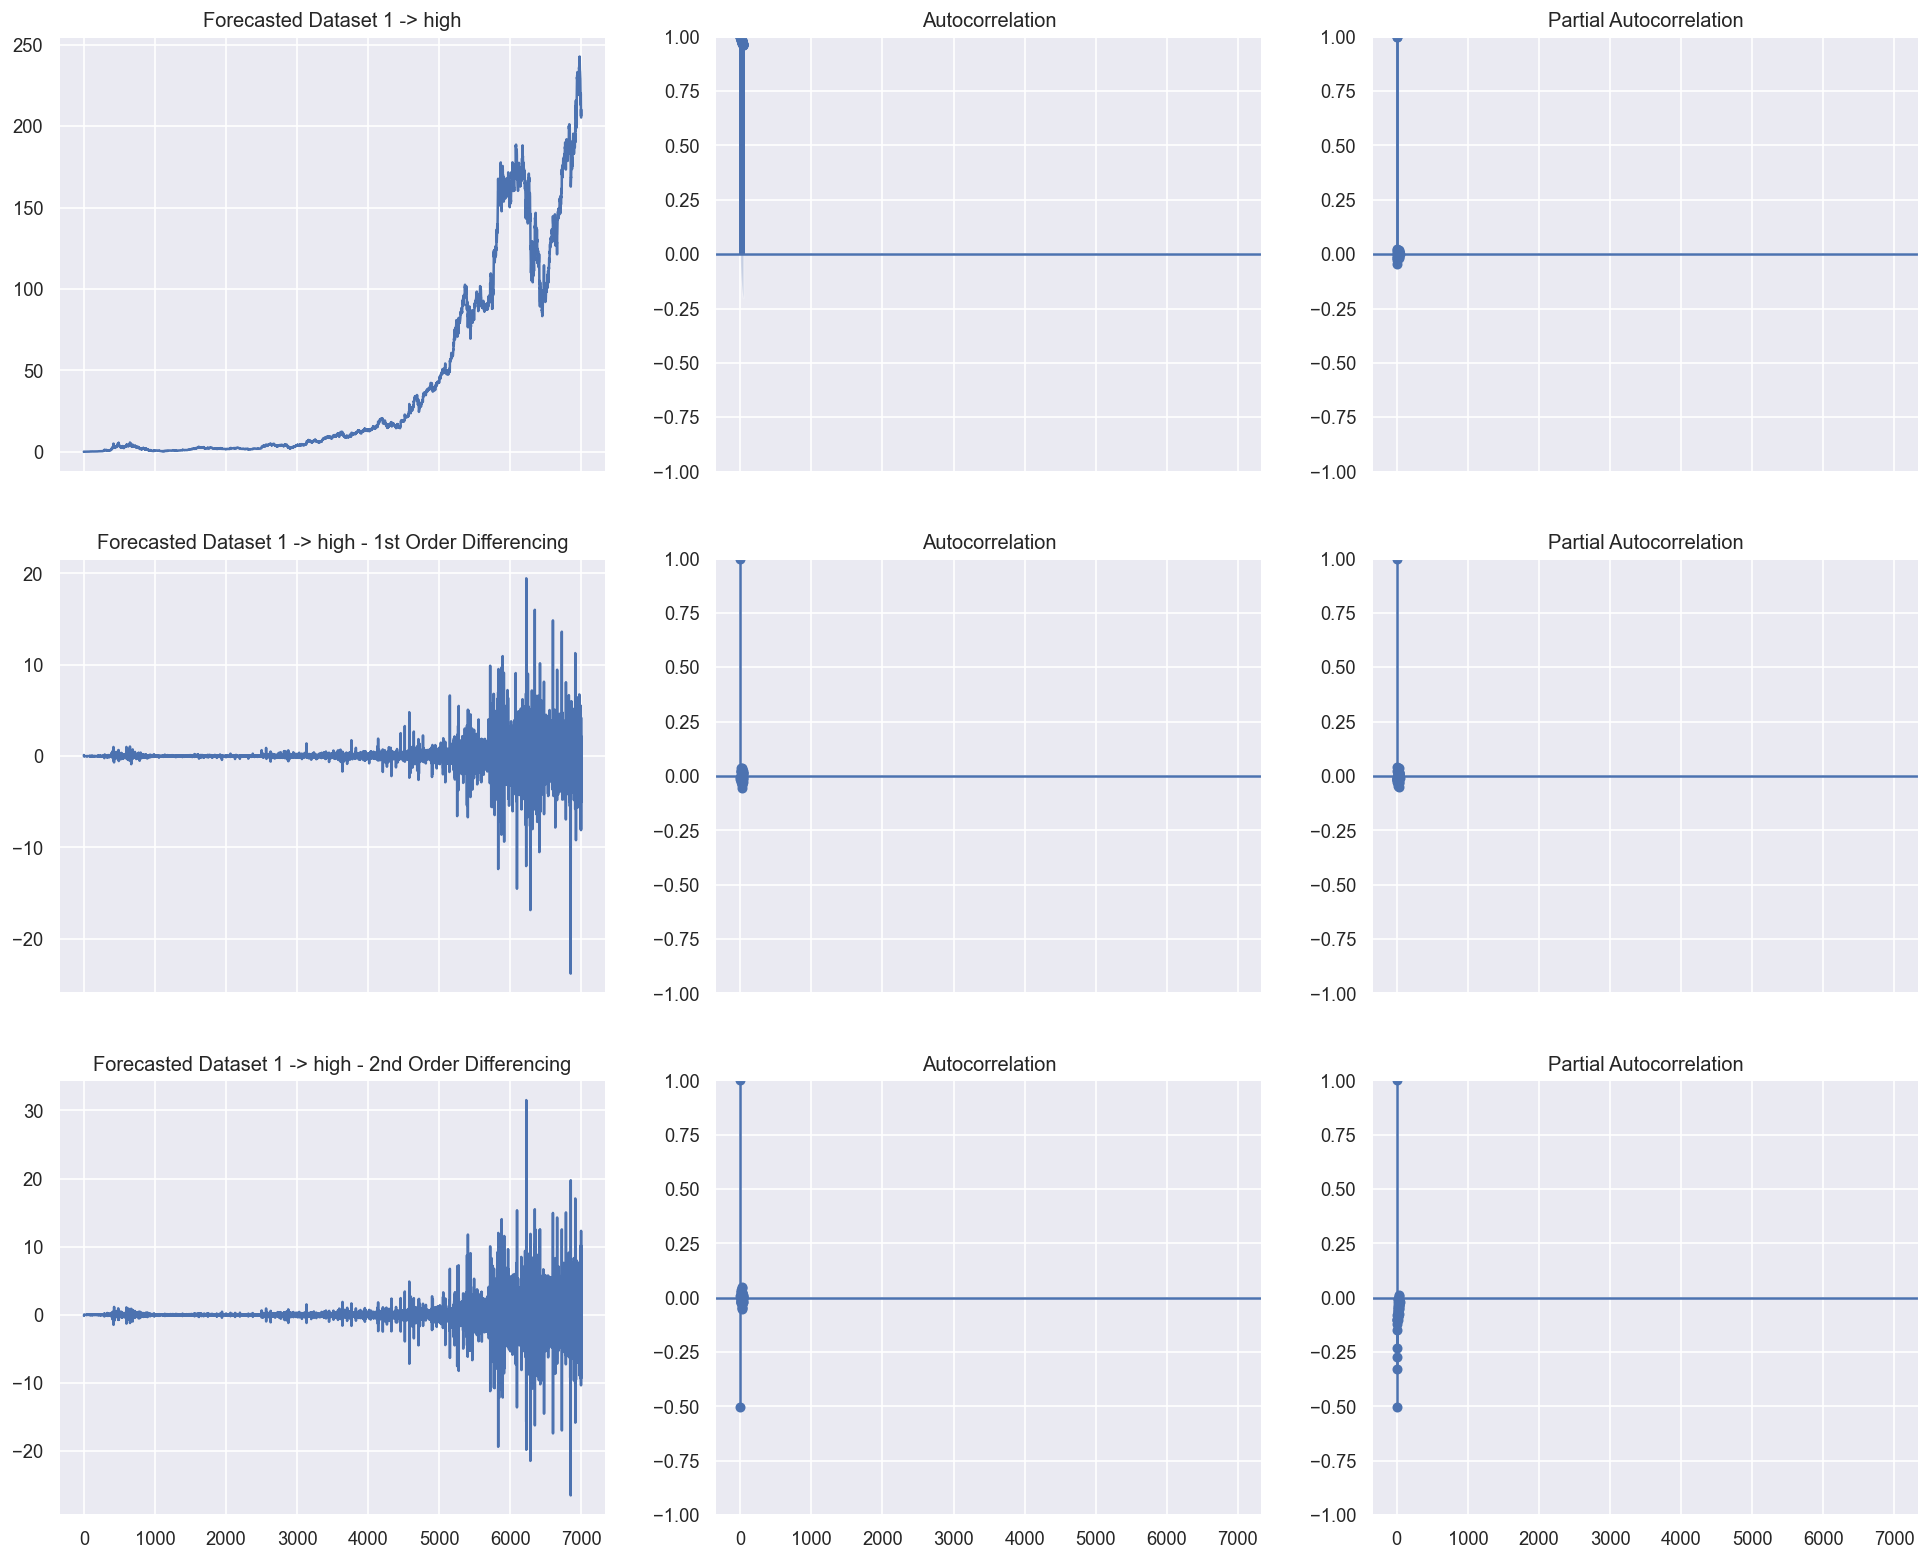

/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_filter['year'] = date_filter['date'].str.split('-').str[0]
/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_filter.loc[0] = dataset.iloc[0]
/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

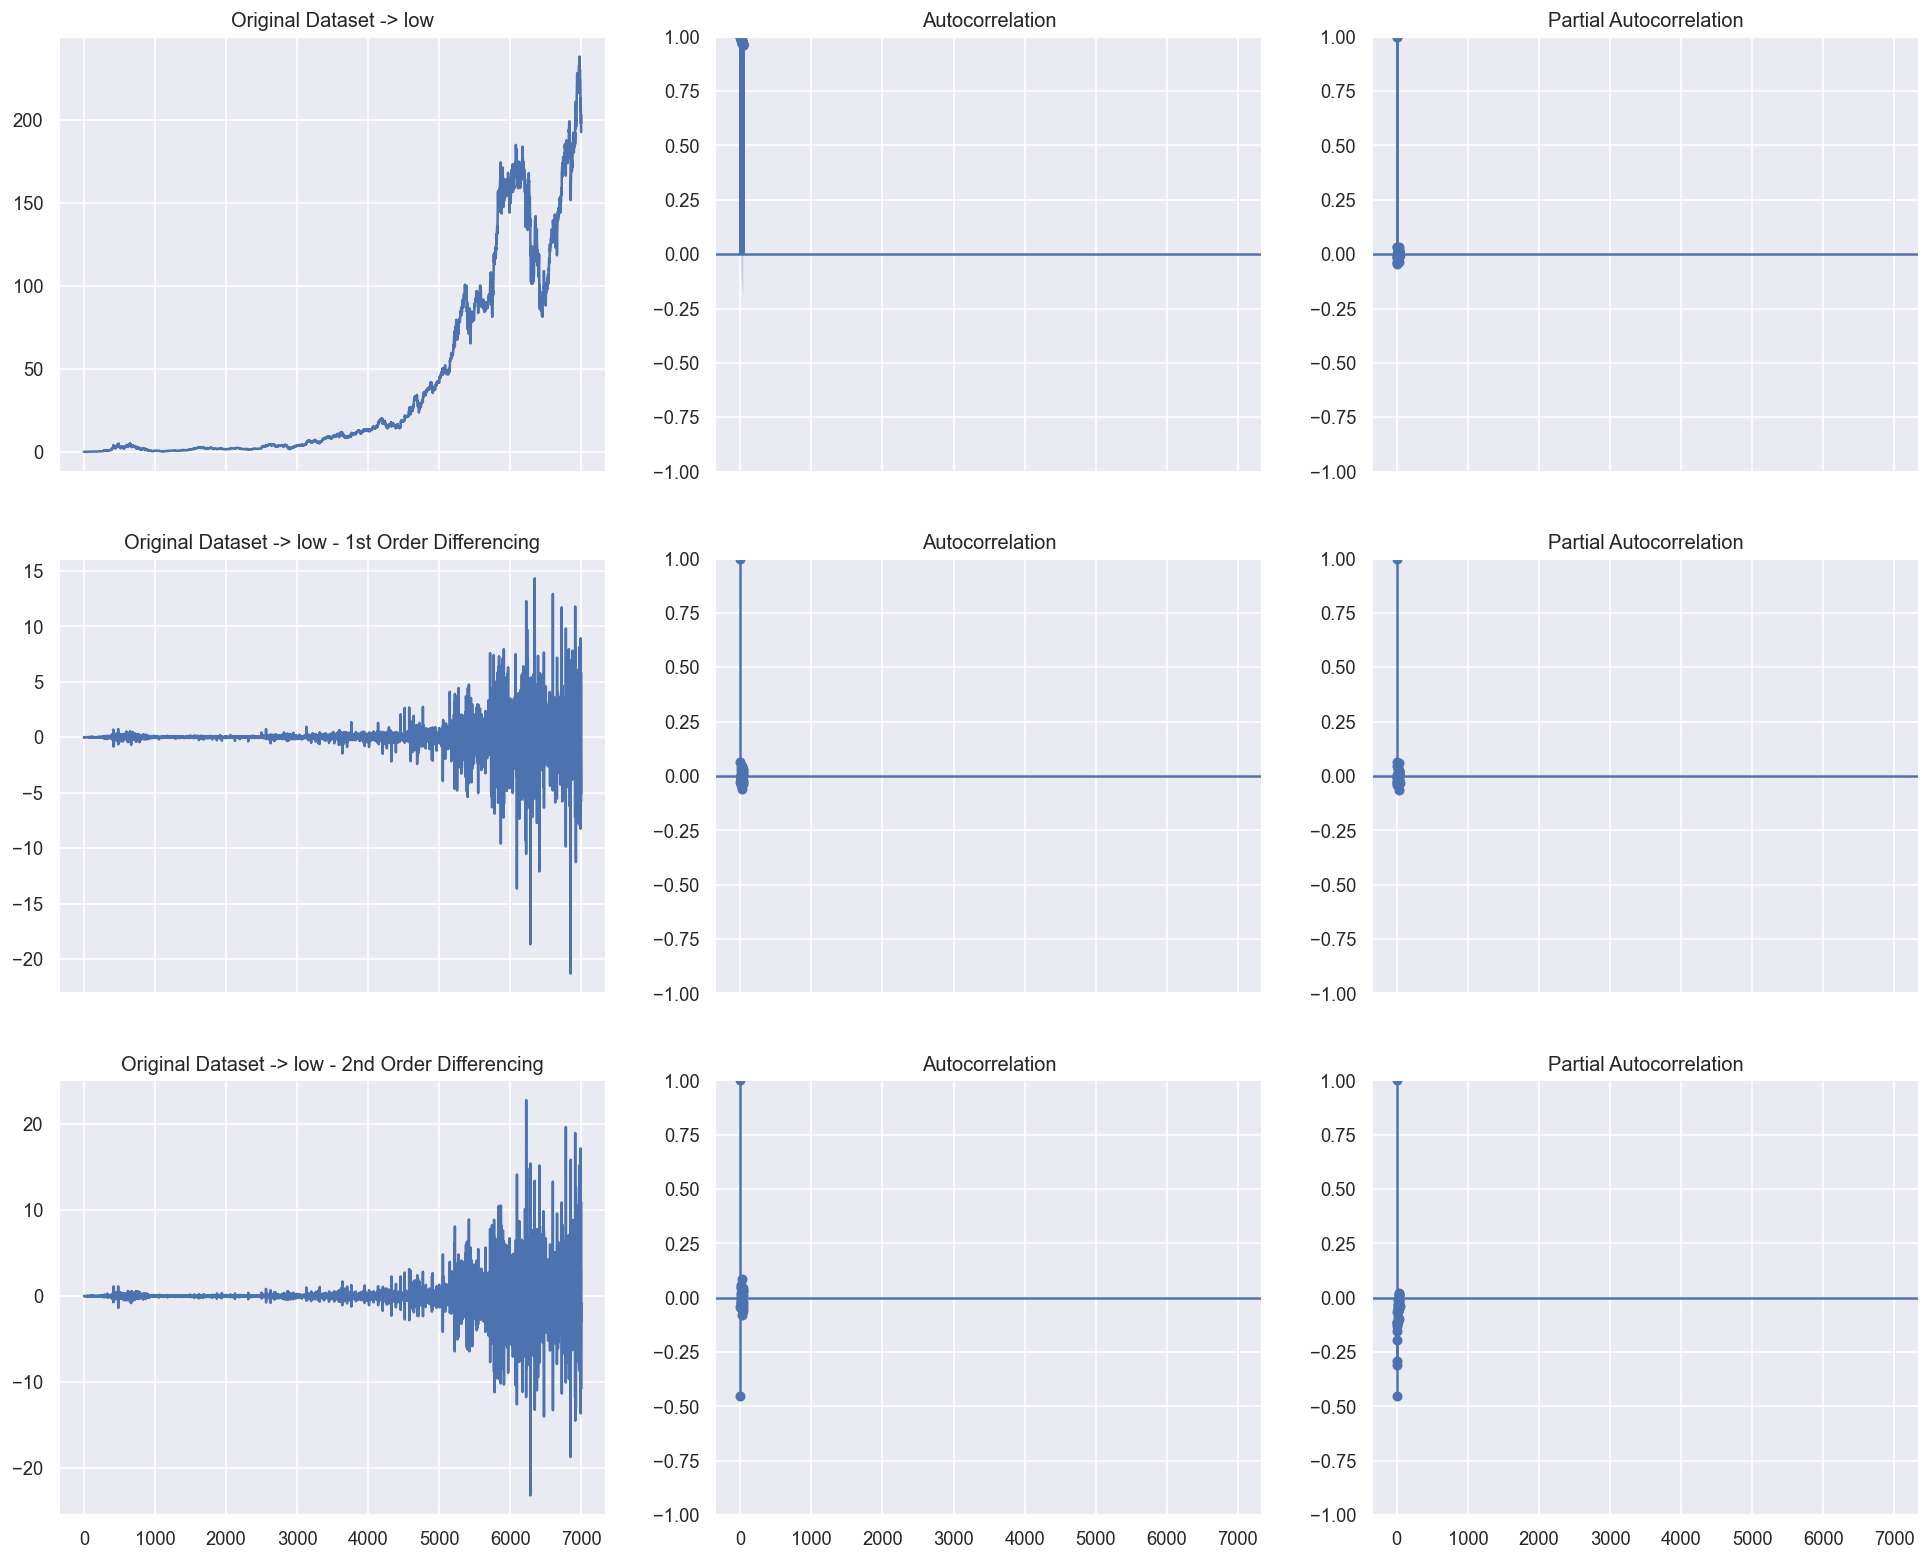

Training based on:
order -> (1, 1, 2)
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 6997
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -12112.284
Date:                Sat, 08 Mar 2025   AIC                          24232.569
Time:                        19:43:21   BIC                          24259.981
Sample:                             0   HQIC                         24242.015
                               - 6997                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3350      0.186      1.801      0.072      -0.030       0.700
ma.L1         -0.2673      0.186     -1.435      0.151      -0.632       0.098
ma.L2         

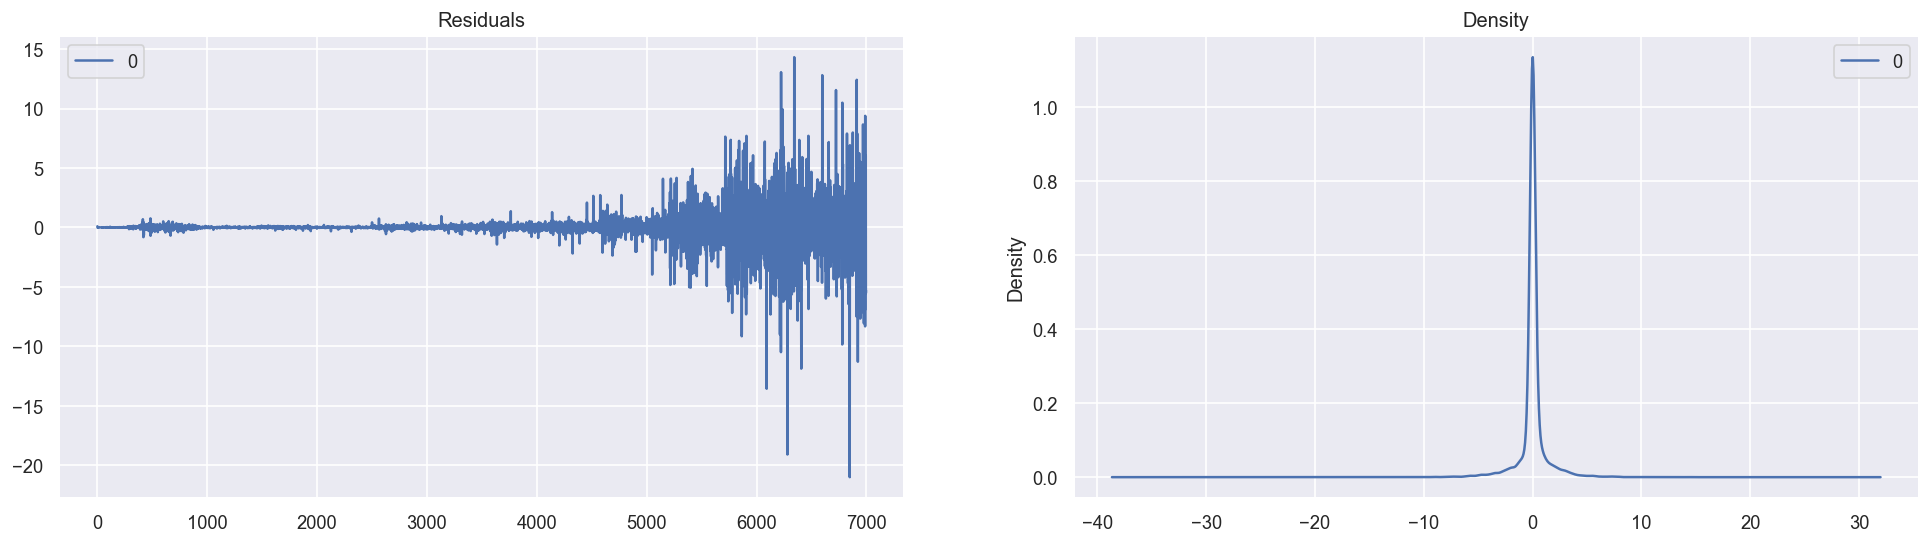

<class 'pandas.core.series.Series'>


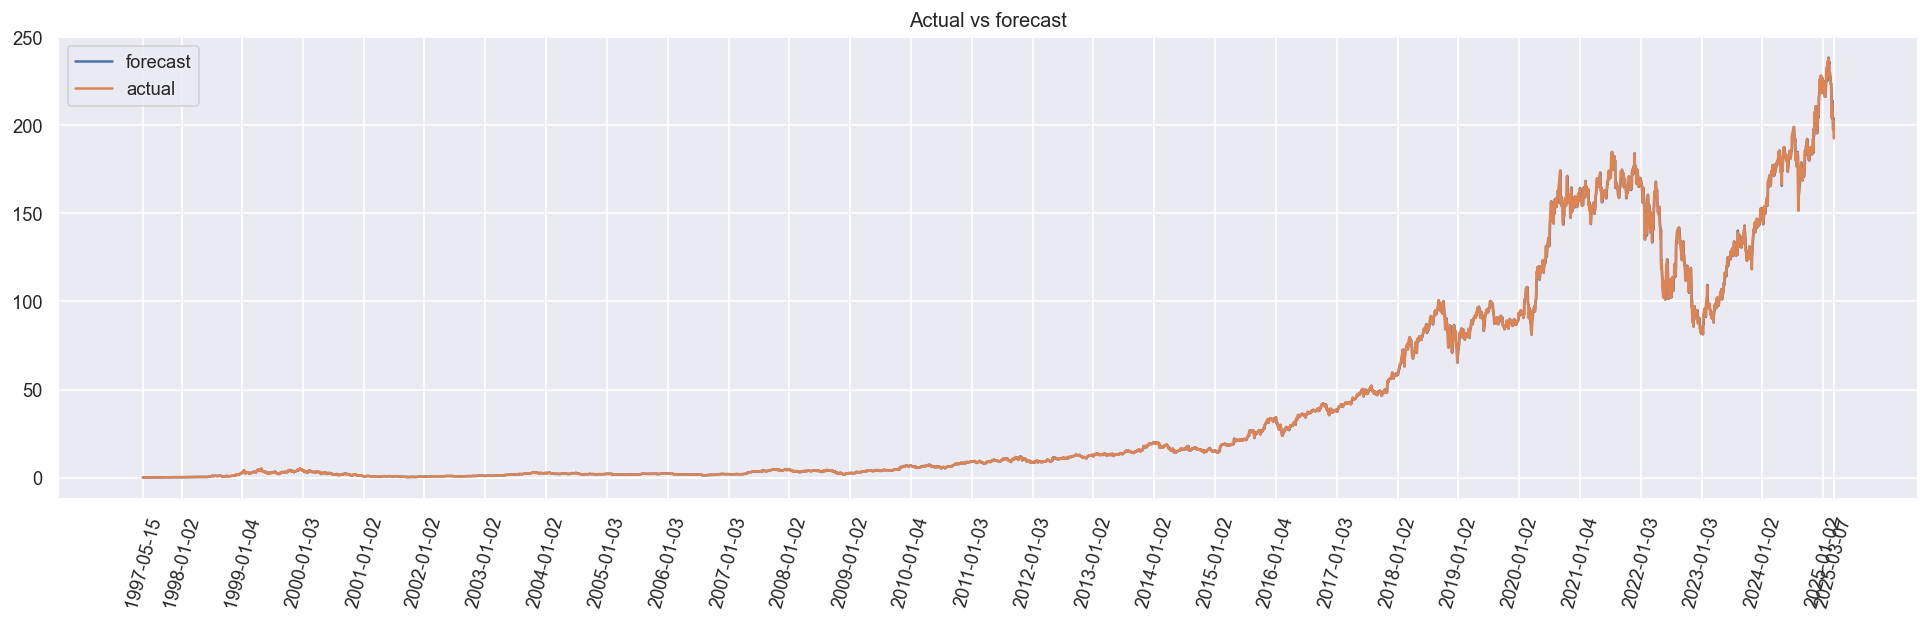

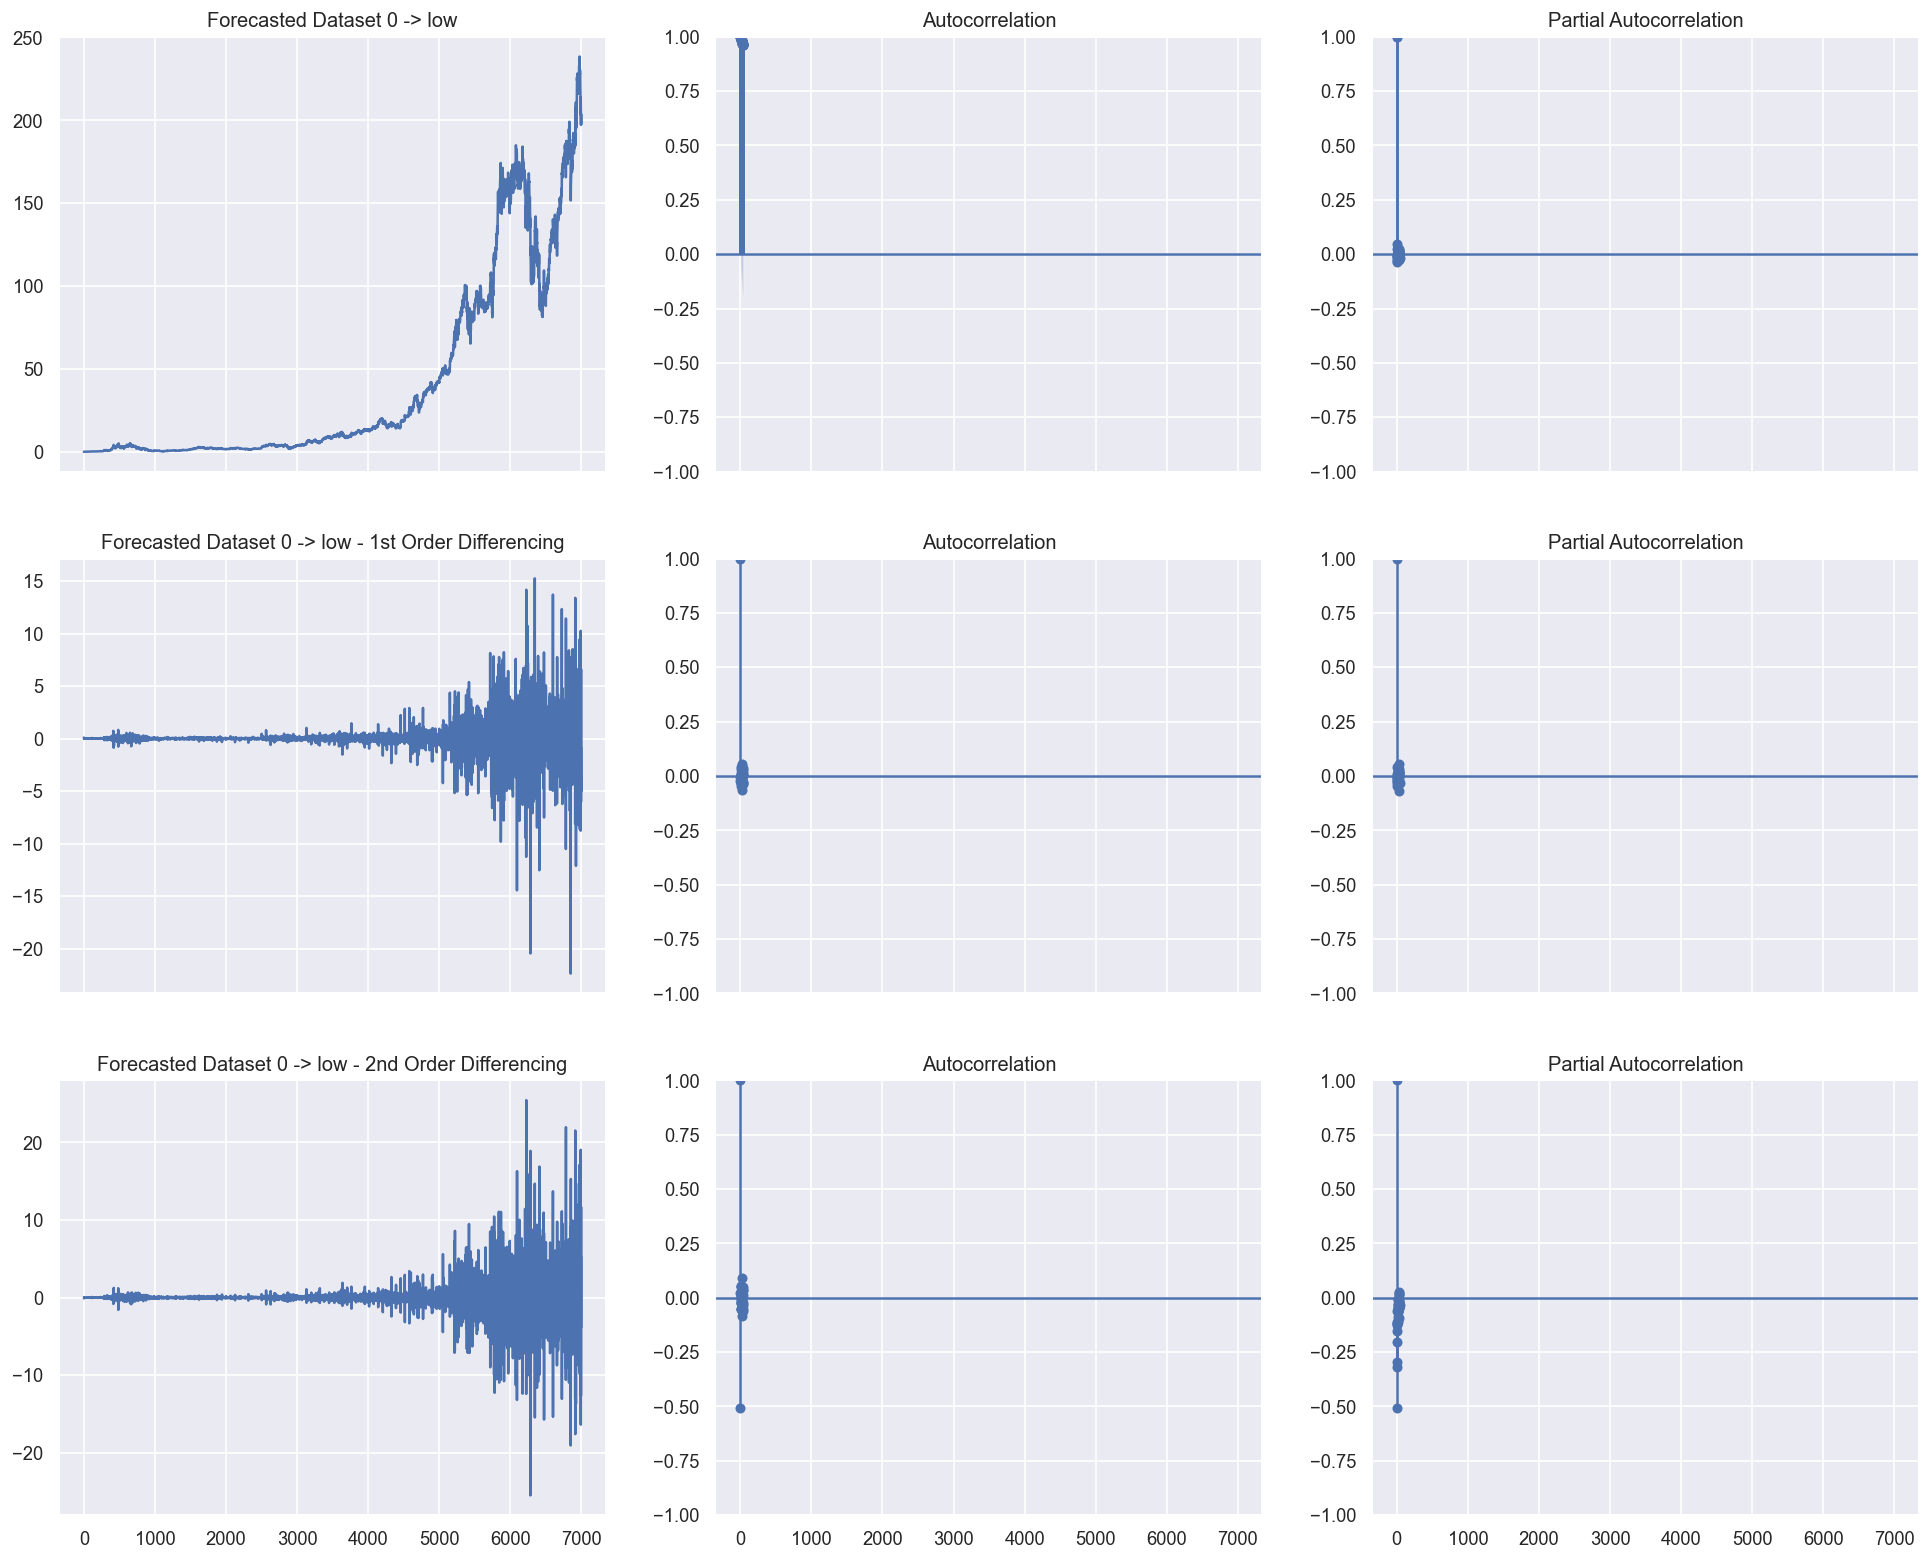

Training based on:
order -> (1, 1, 1)
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 6997
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -12114.039
Date:                Sat, 08 Mar 2025   AIC                          24234.078
Time:                        19:43:23   BIC                          24254.637
Sample:                             0   HQIC                         24241.163
                               - 6997                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1257      0.067     -1.878      0.060      -0.257       0.005
ma.L1          0.1955      0.066      2.953      0.003       0.066       0.325
sigma2        

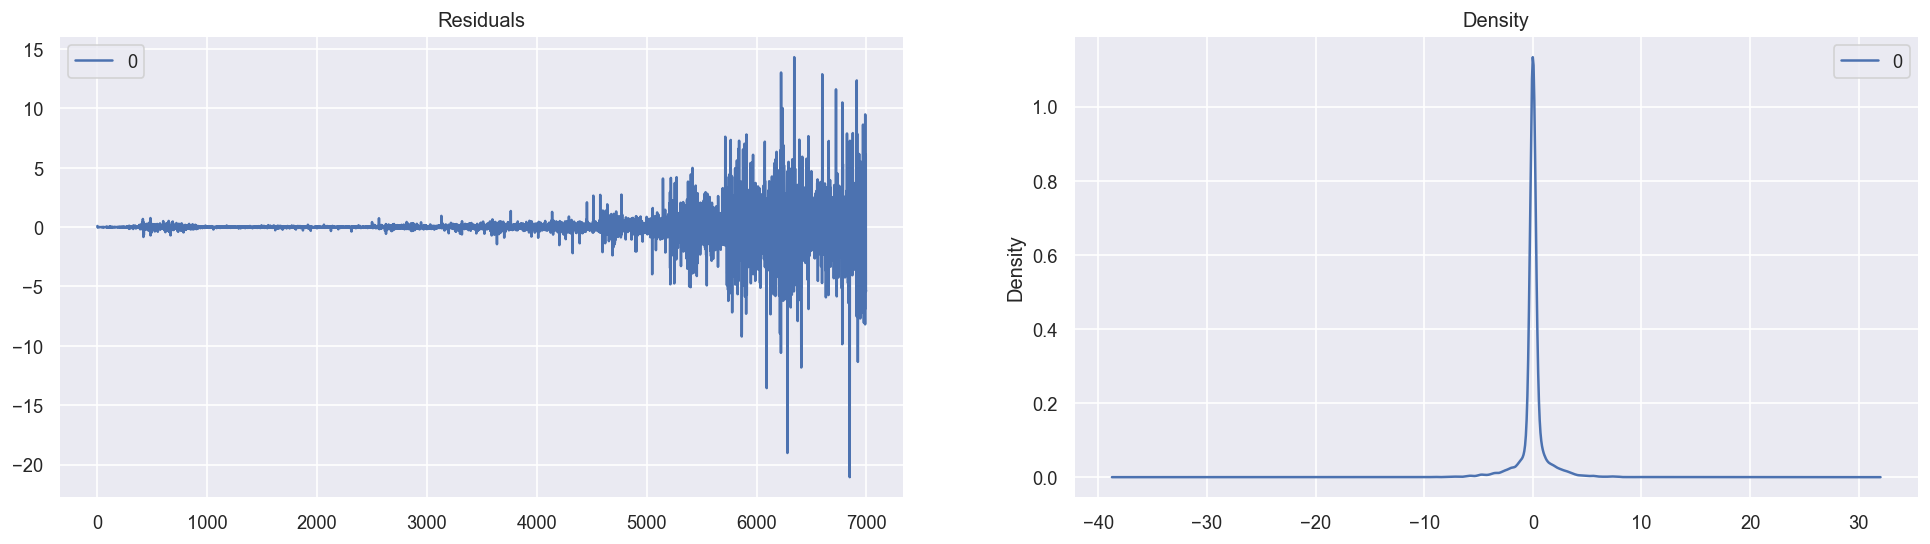

<class 'pandas.core.series.Series'>


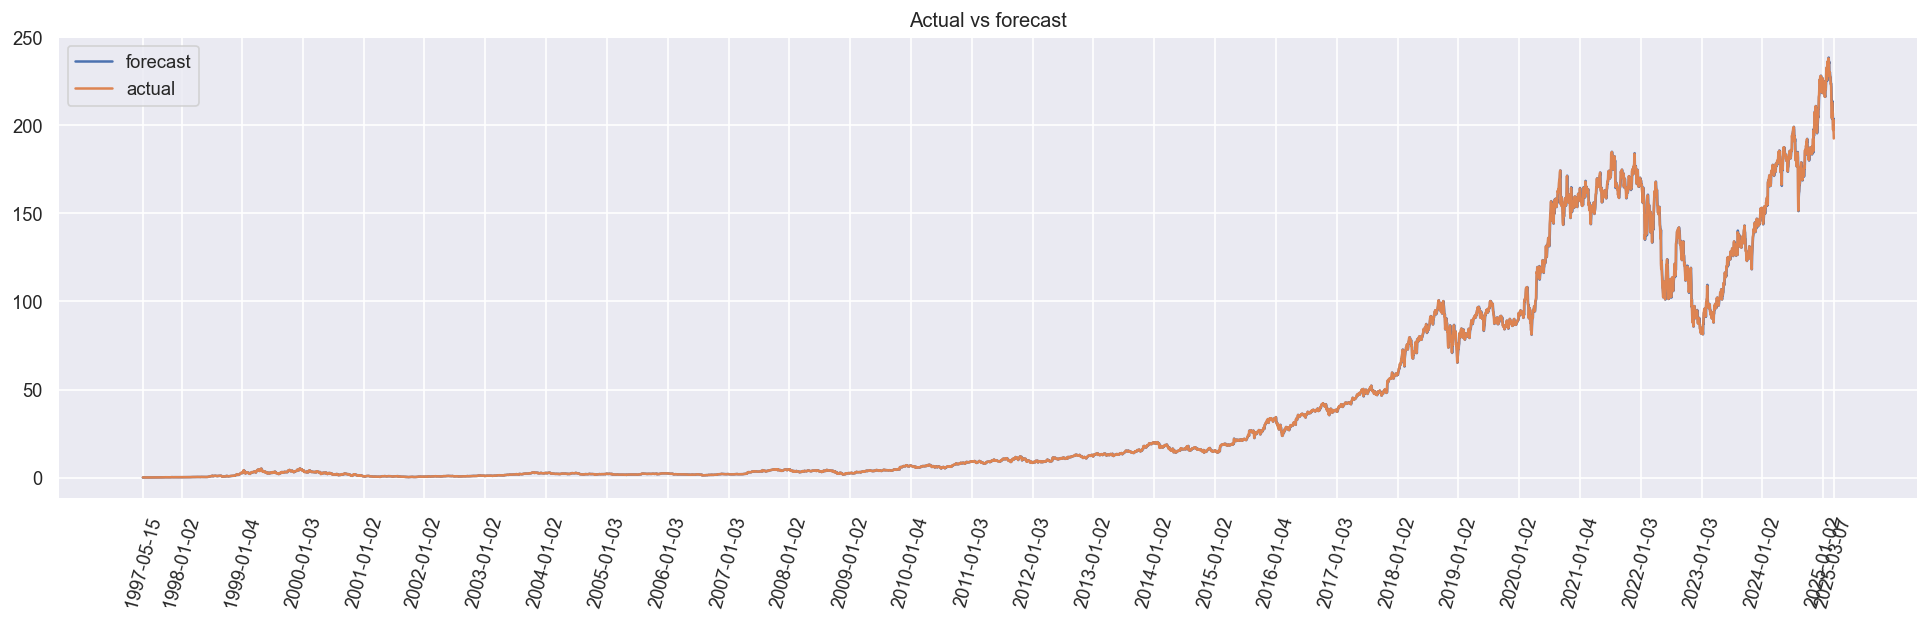

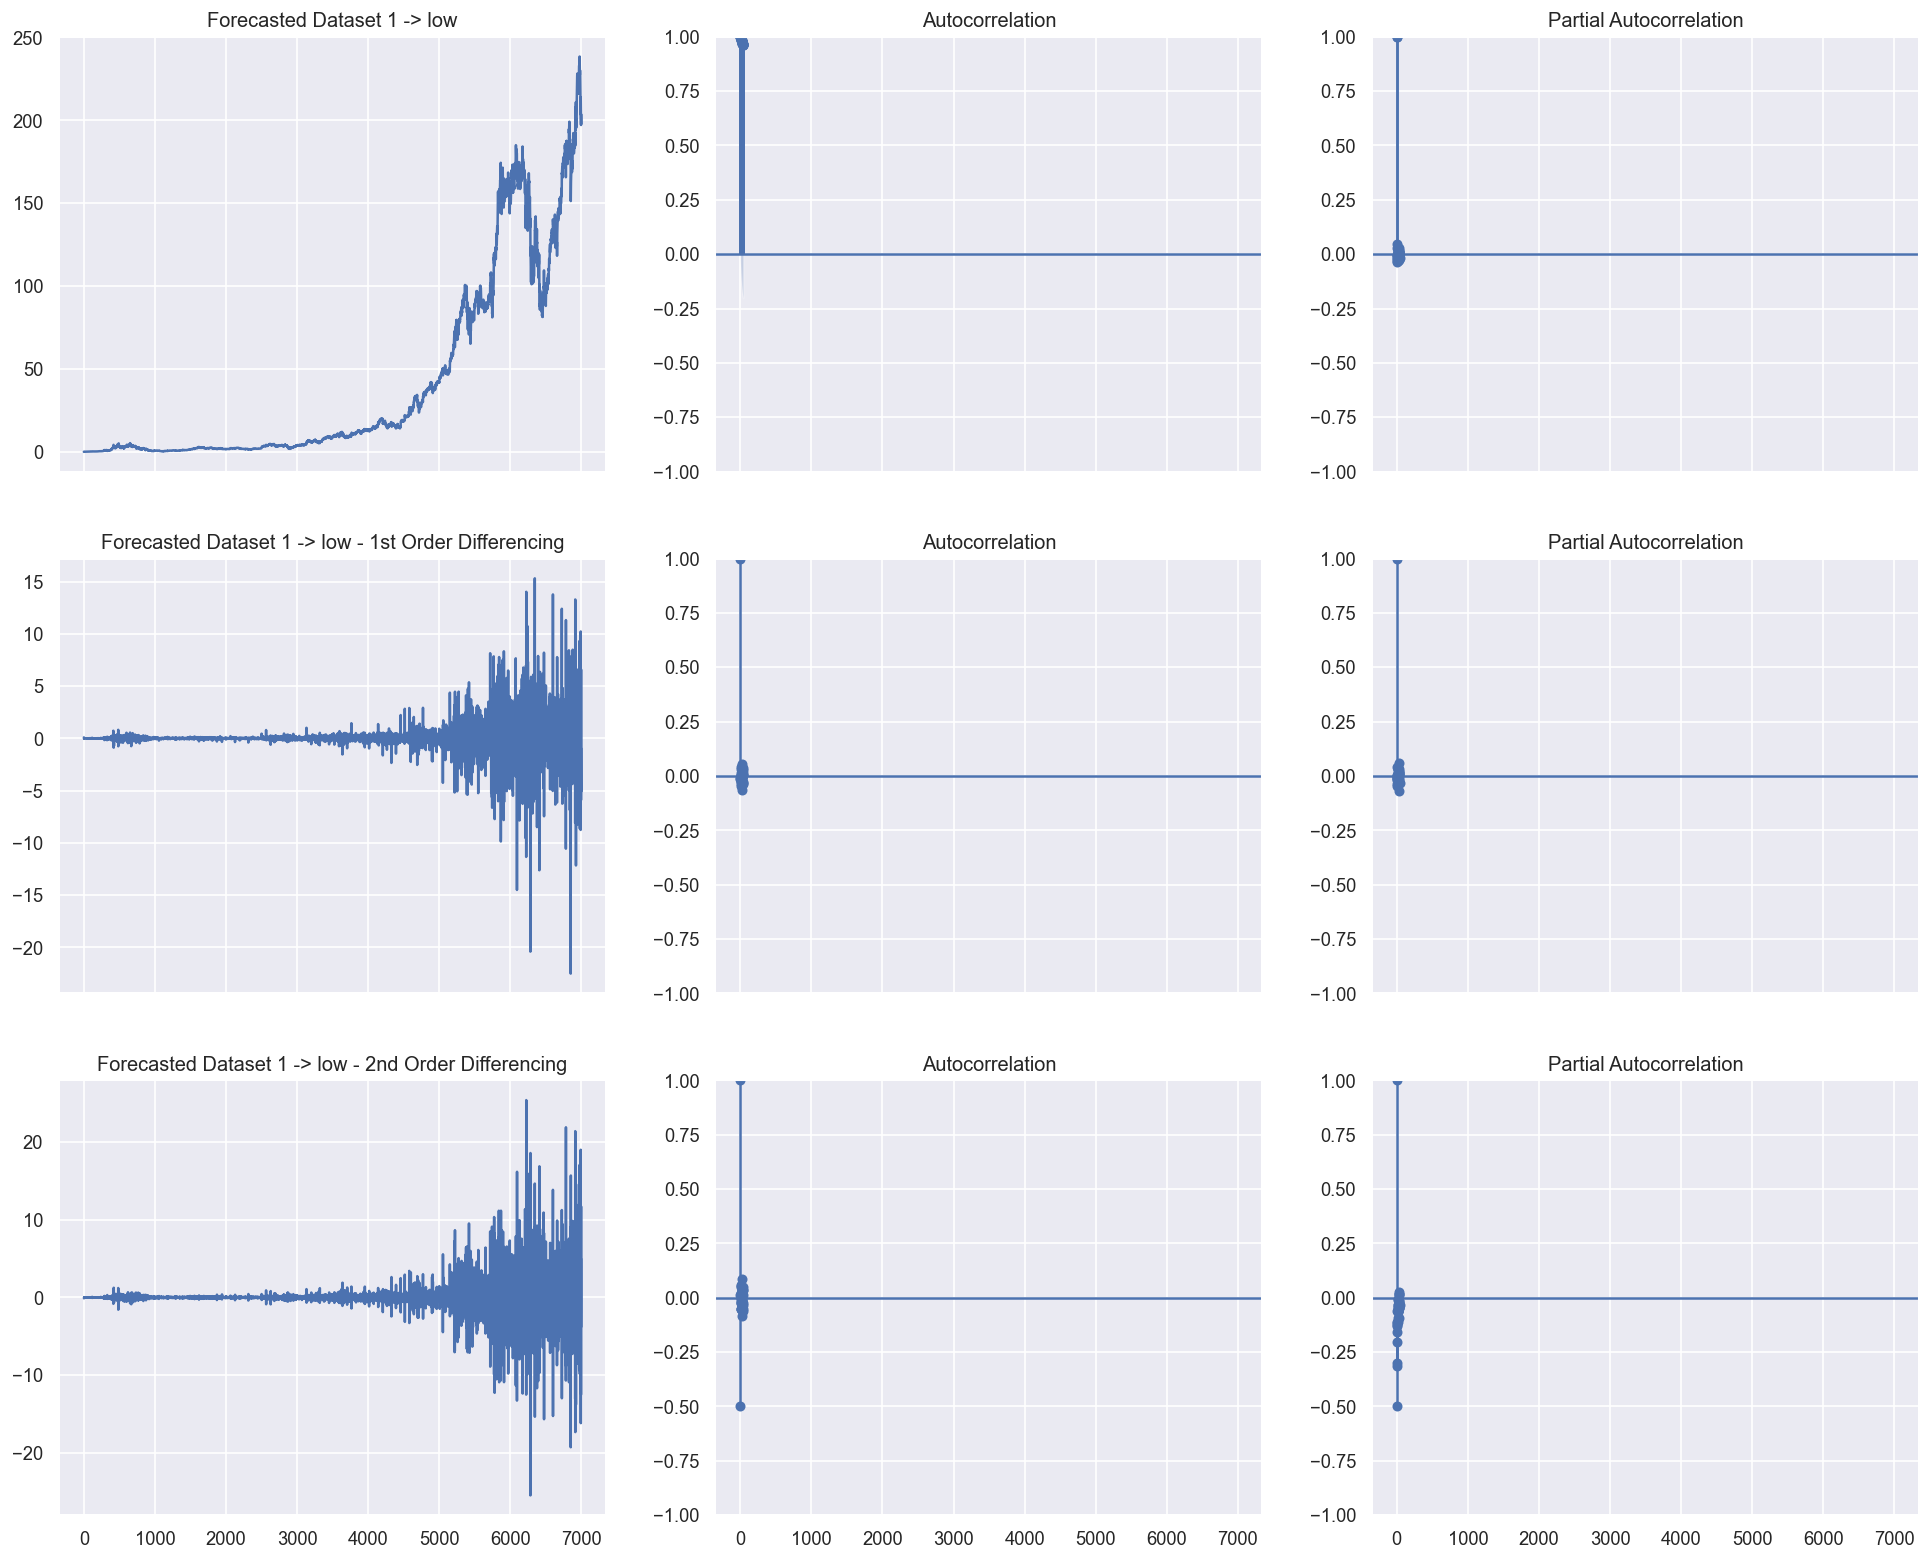

/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_filter['year'] = date_filter['date'].str.split('-').str[0]
/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_filter.loc[0] = dataset.iloc[0]
/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

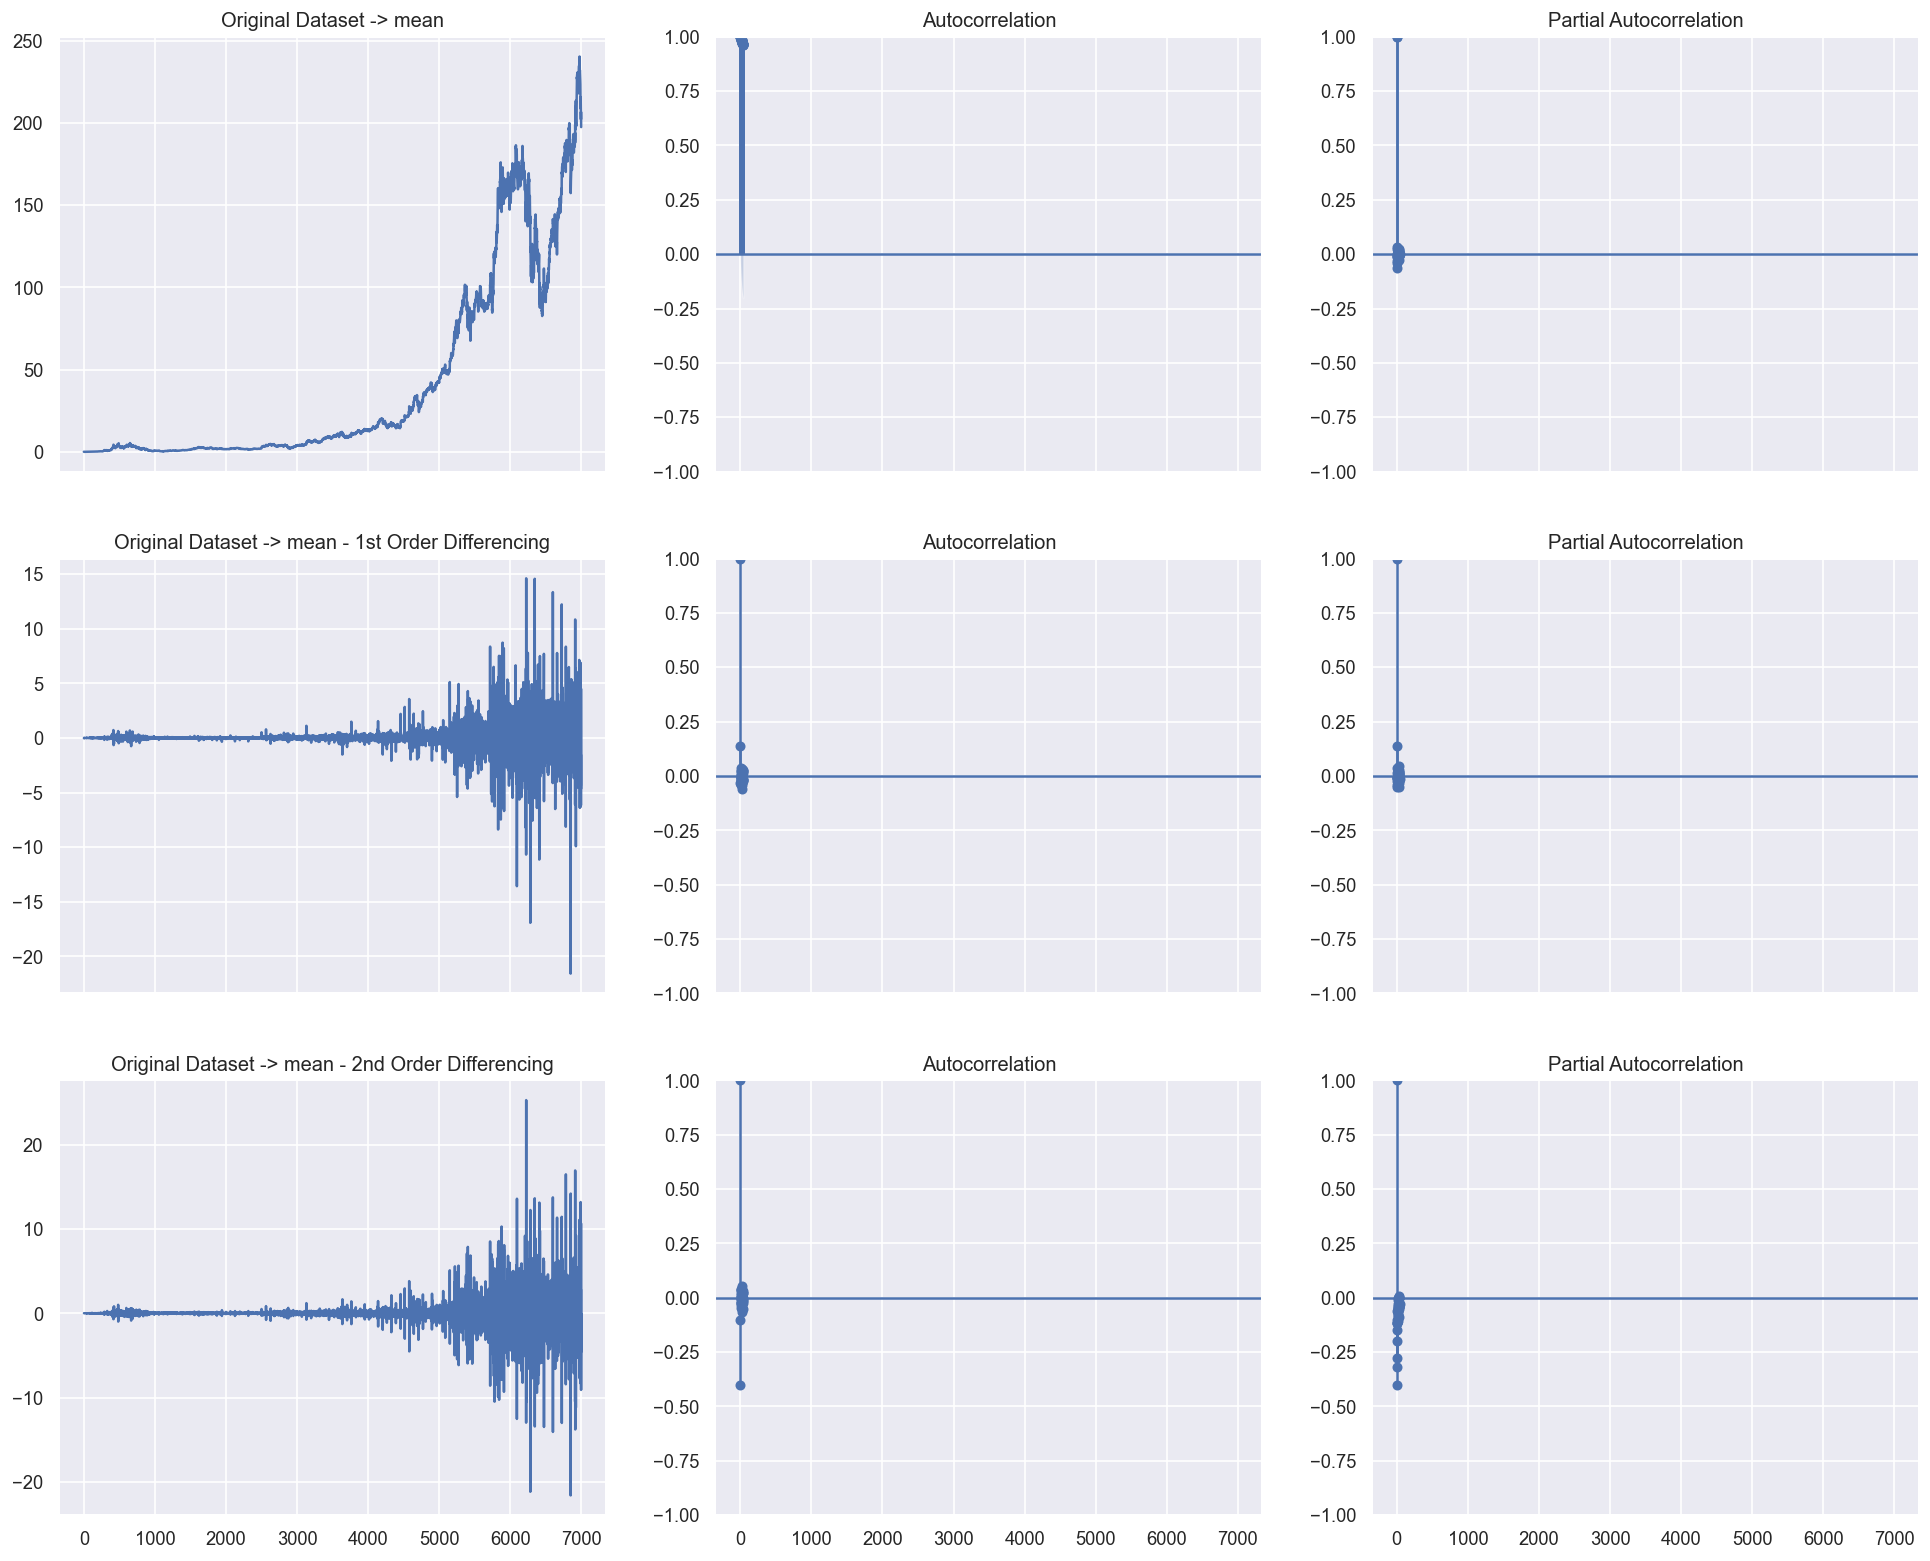

Training based on:
order -> (1, 1, 2)
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 6997
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -11490.357
Date:                Sat, 08 Mar 2025   AIC                          22988.714
Time:                        19:43:26   BIC                          23016.126
Sample:                             0   HQIC                         22998.160
                               - 6997                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2714      0.190      1.430      0.153      -0.101       0.644
ma.L1         -0.1268      0.190     -0.667      0.505      -0.499       0.246
ma.L2         

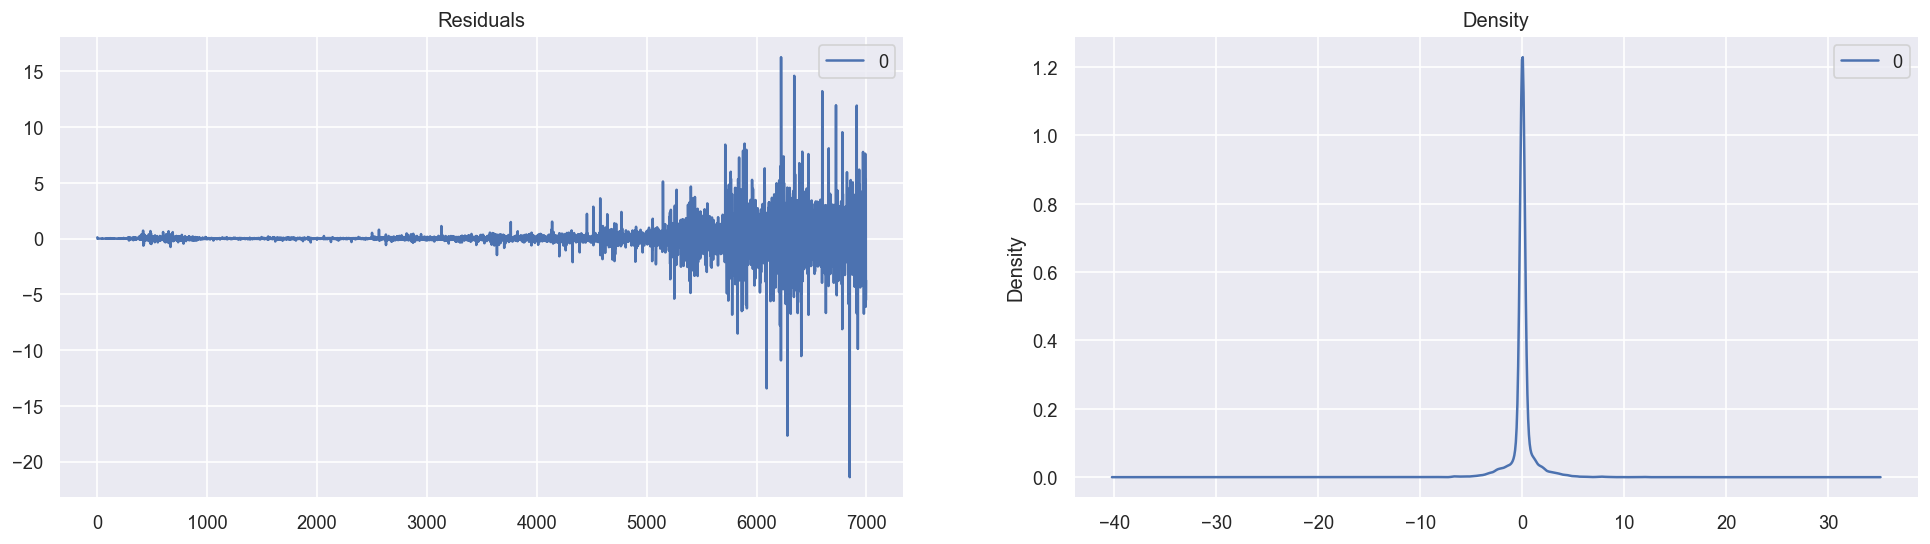

<class 'pandas.core.series.Series'>


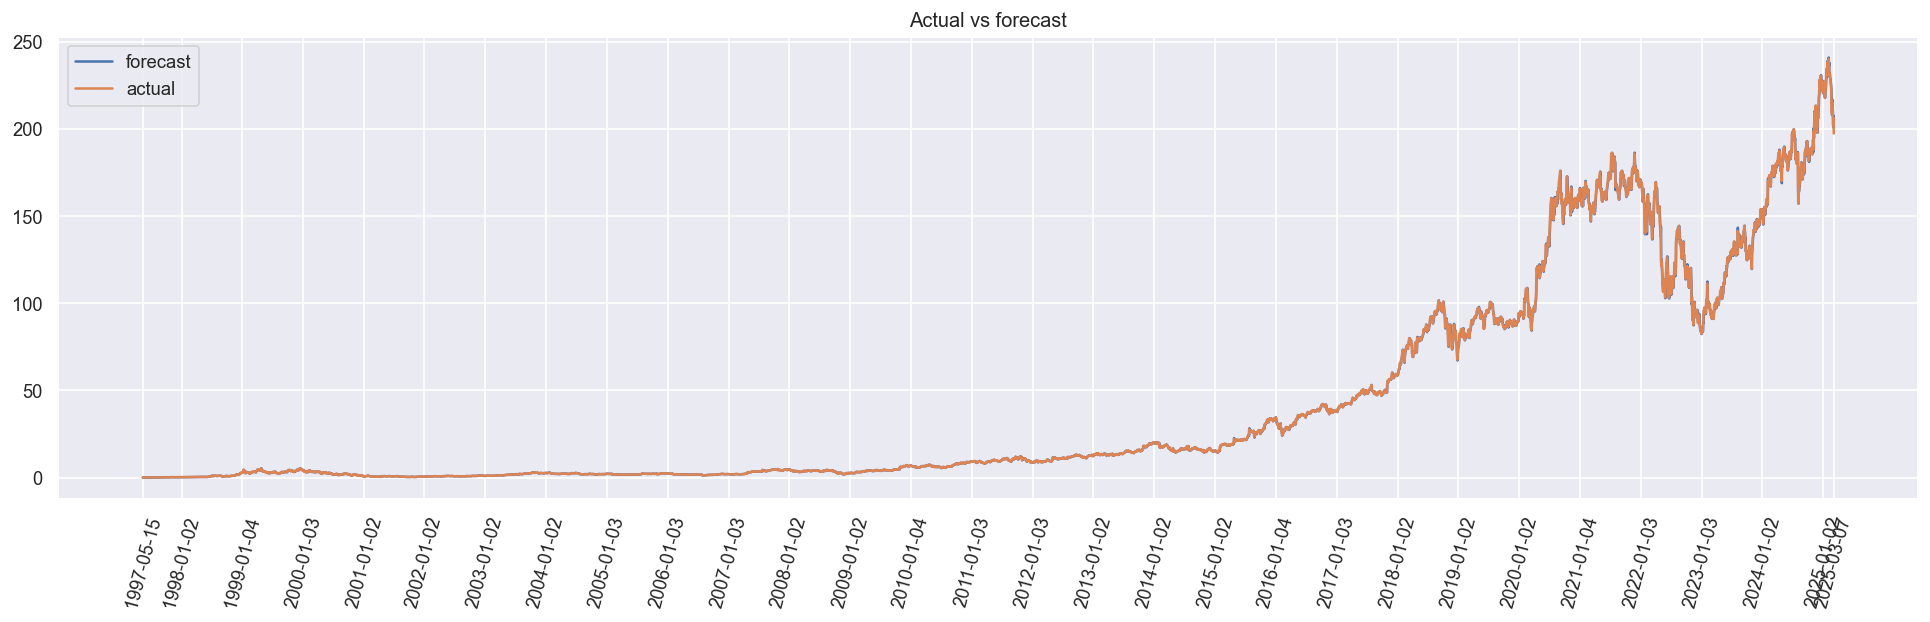

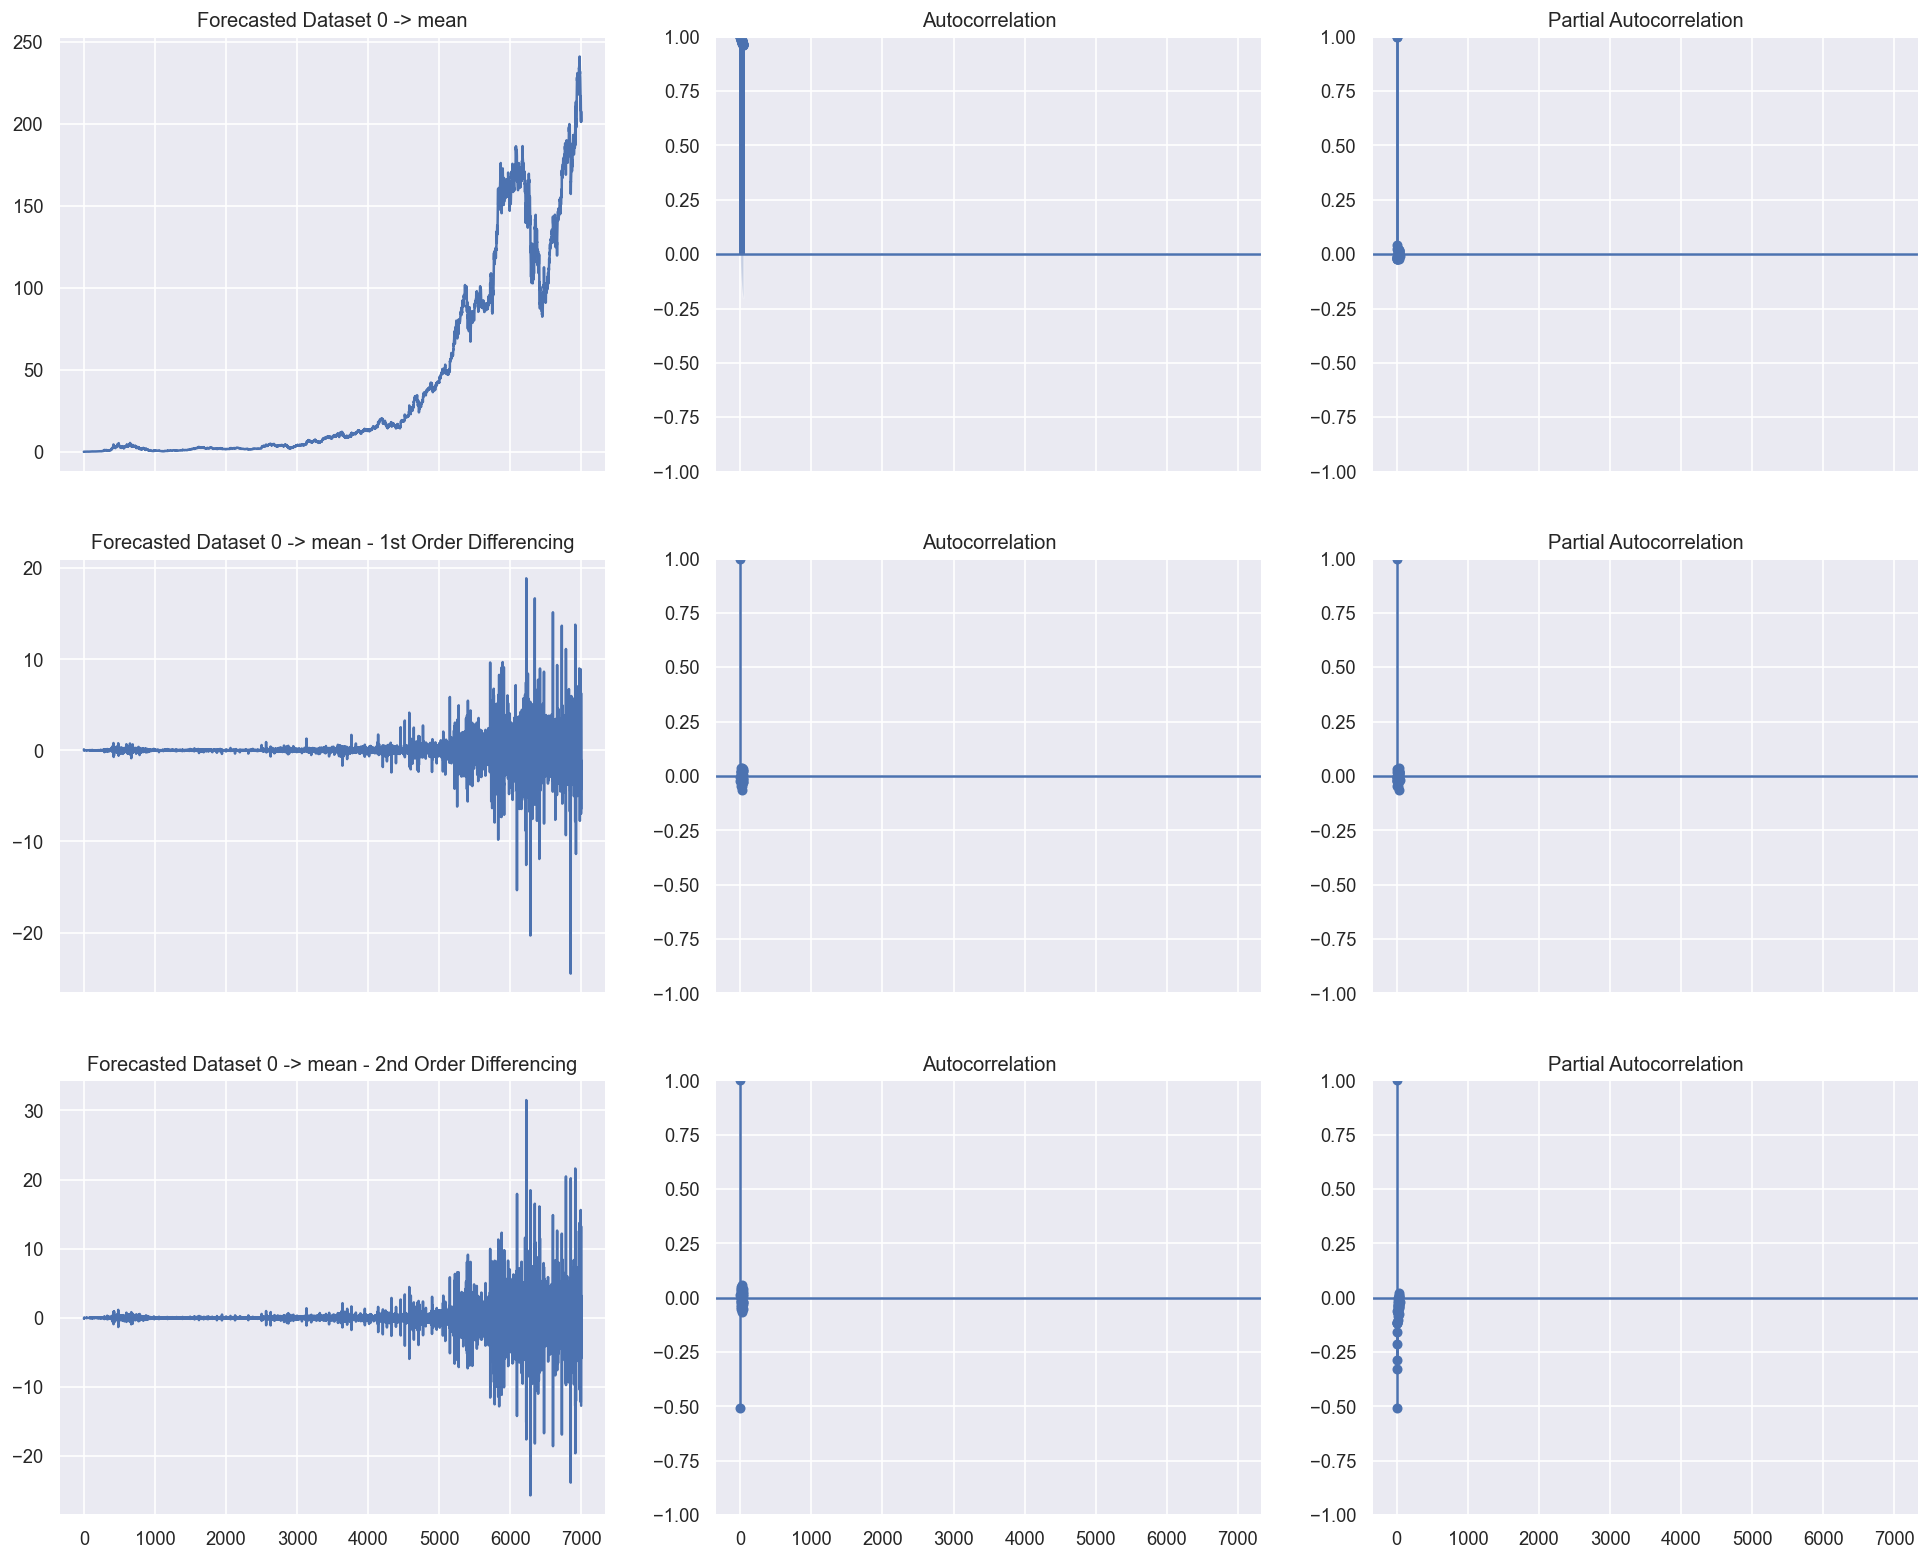

Training based on:
order -> (1, 1, 1)
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 6997
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11491.485
Date:                Sat, 08 Mar 2025   AIC                          22988.971
Time:                        19:43:28   BIC                          23009.530
Sample:                             0   HQIC                         22996.055
                               - 6997                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1072      0.035     -3.091      0.002      -0.175      -0.039
ma.L1          0.2535      0.034      7.533      0.000       0.188       0.319
sigma2        

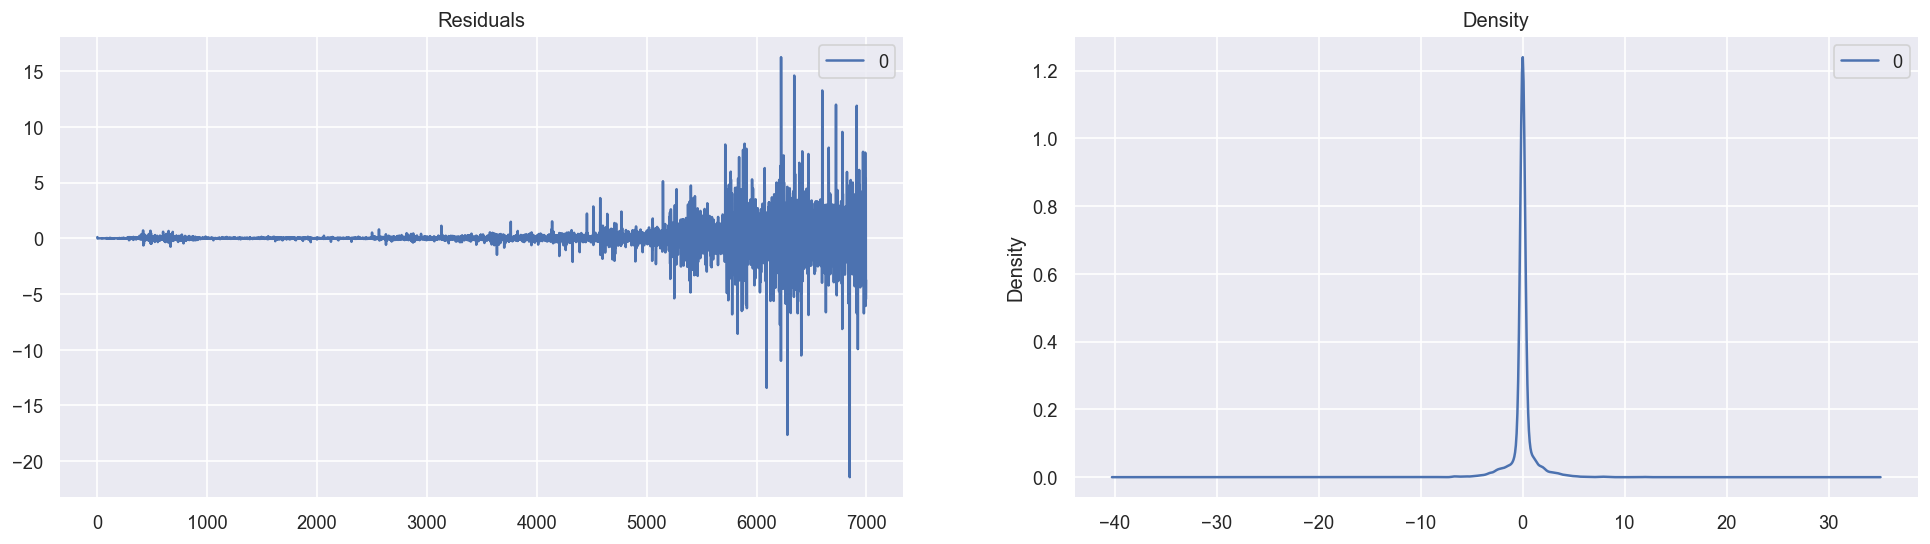

<class 'pandas.core.series.Series'>


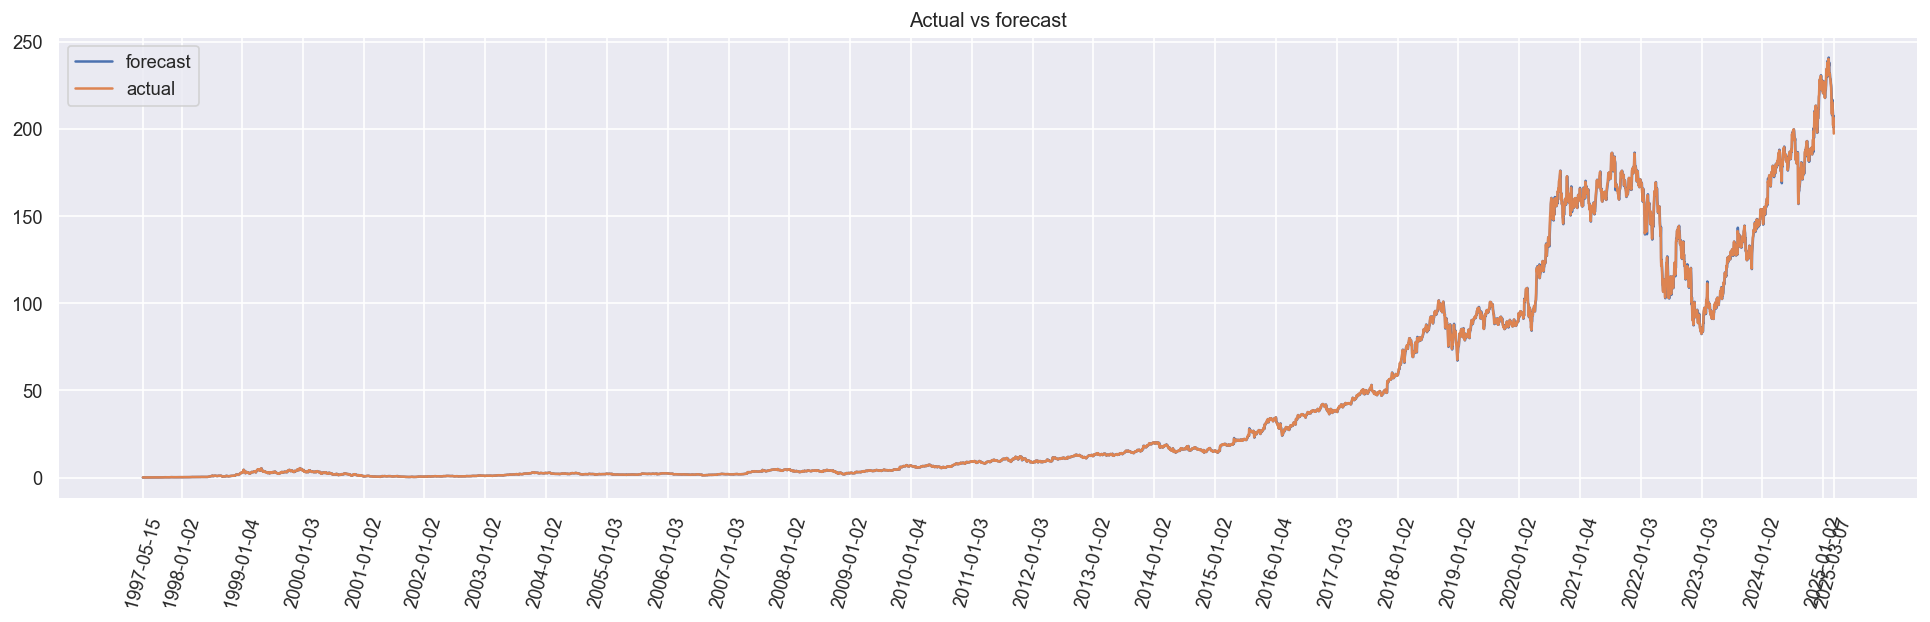

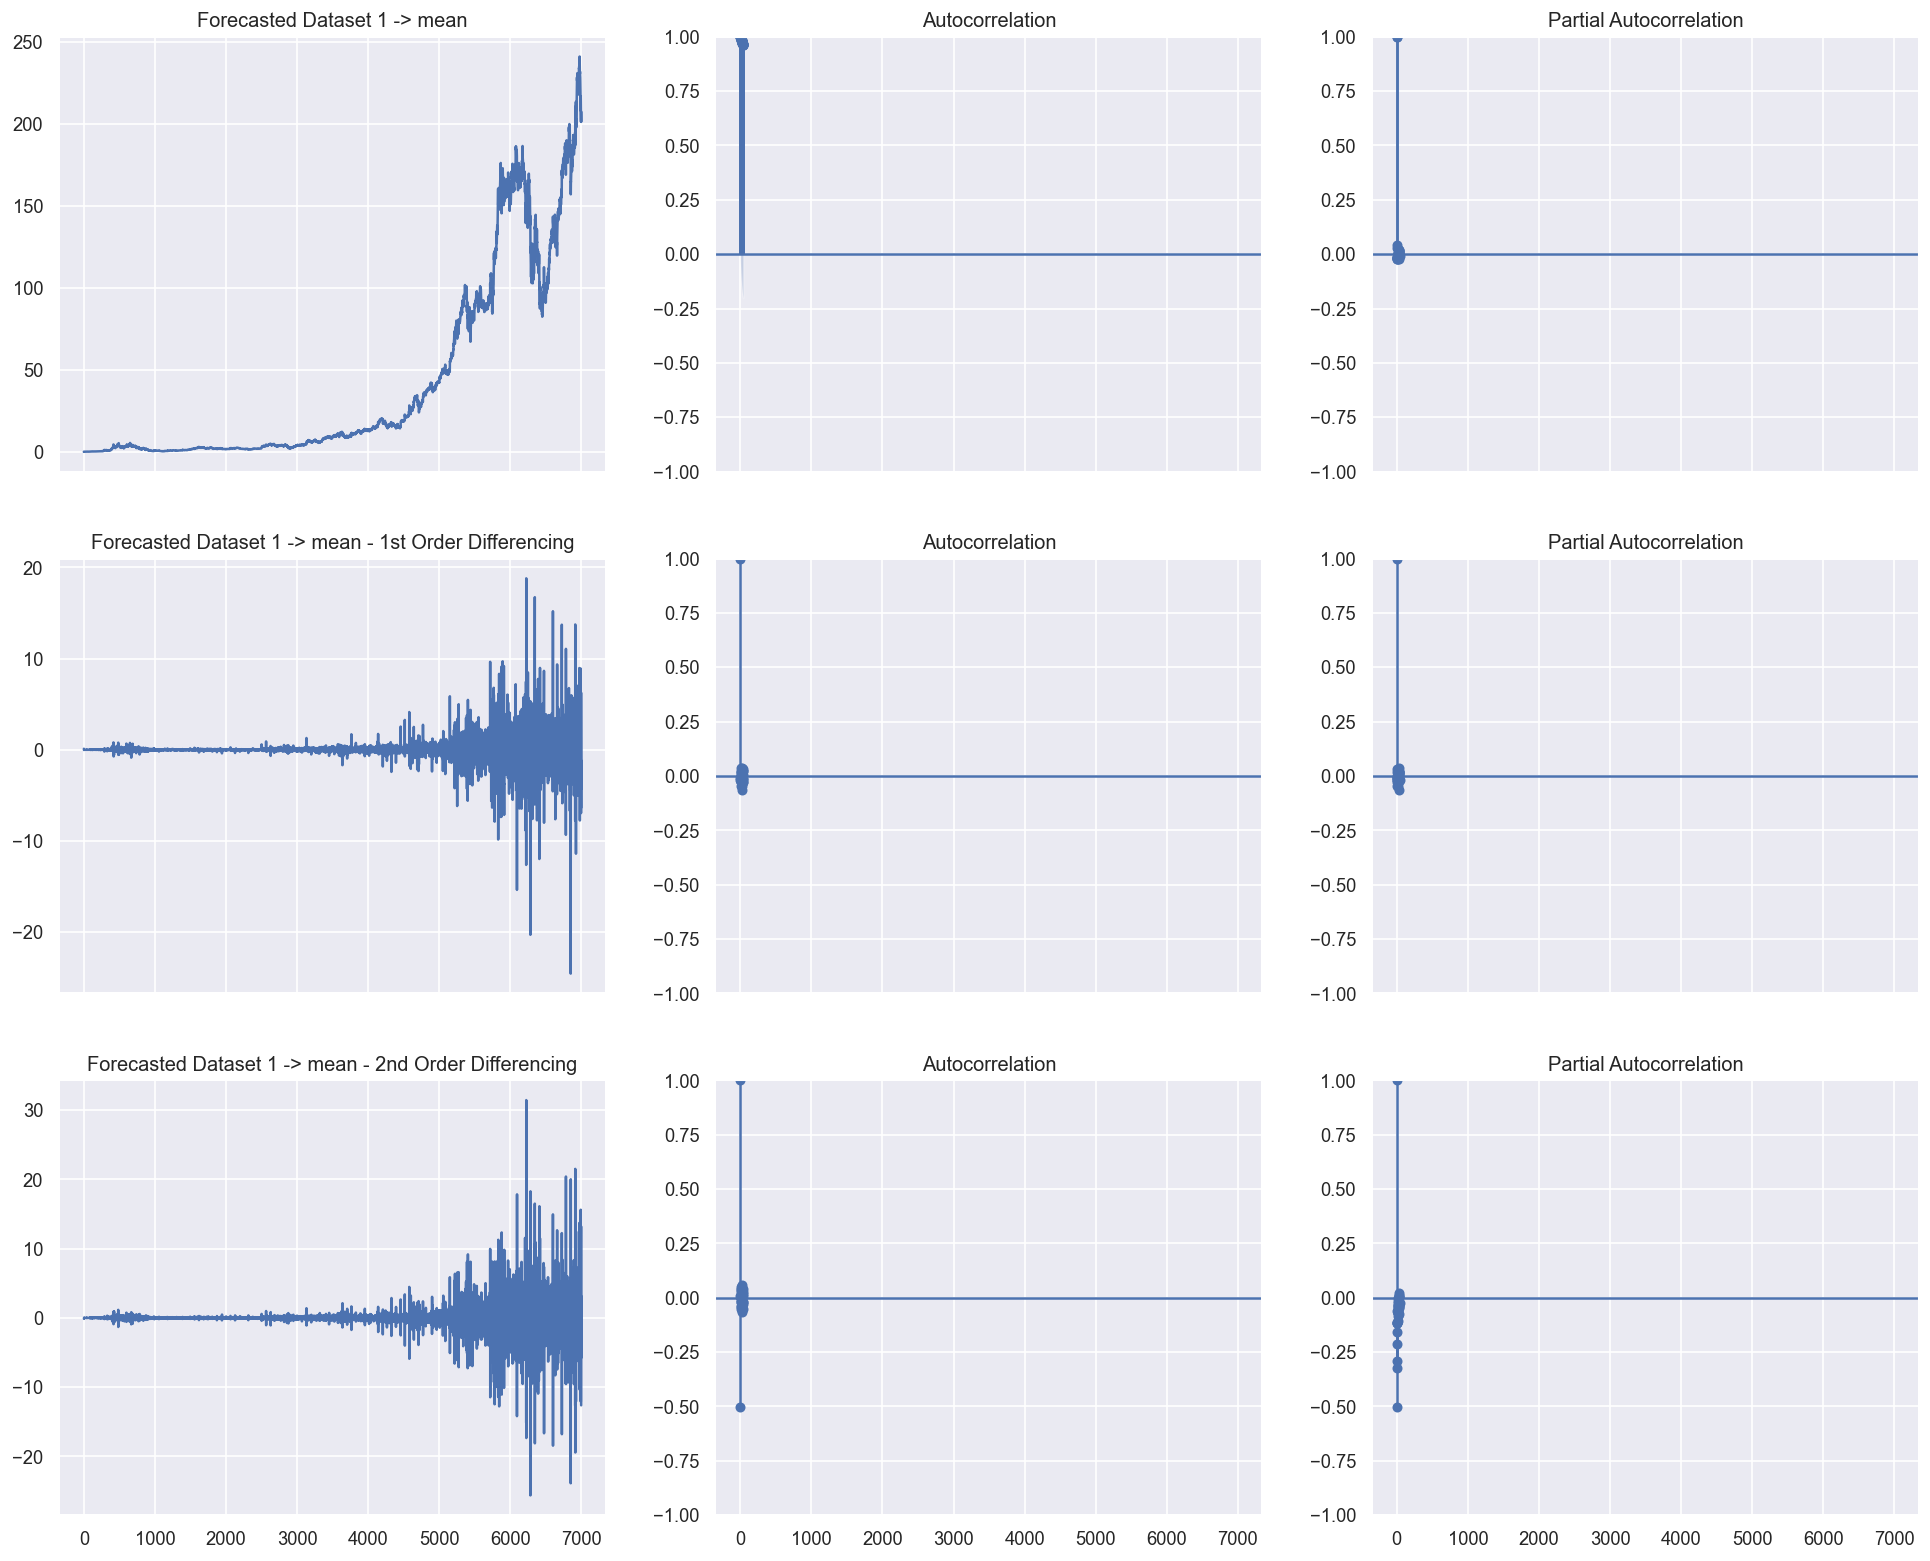

/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_filter['year'] = date_filter['date'].str.split('-').str[0]
/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_filter.loc[0] = dataset.iloc[0]
/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

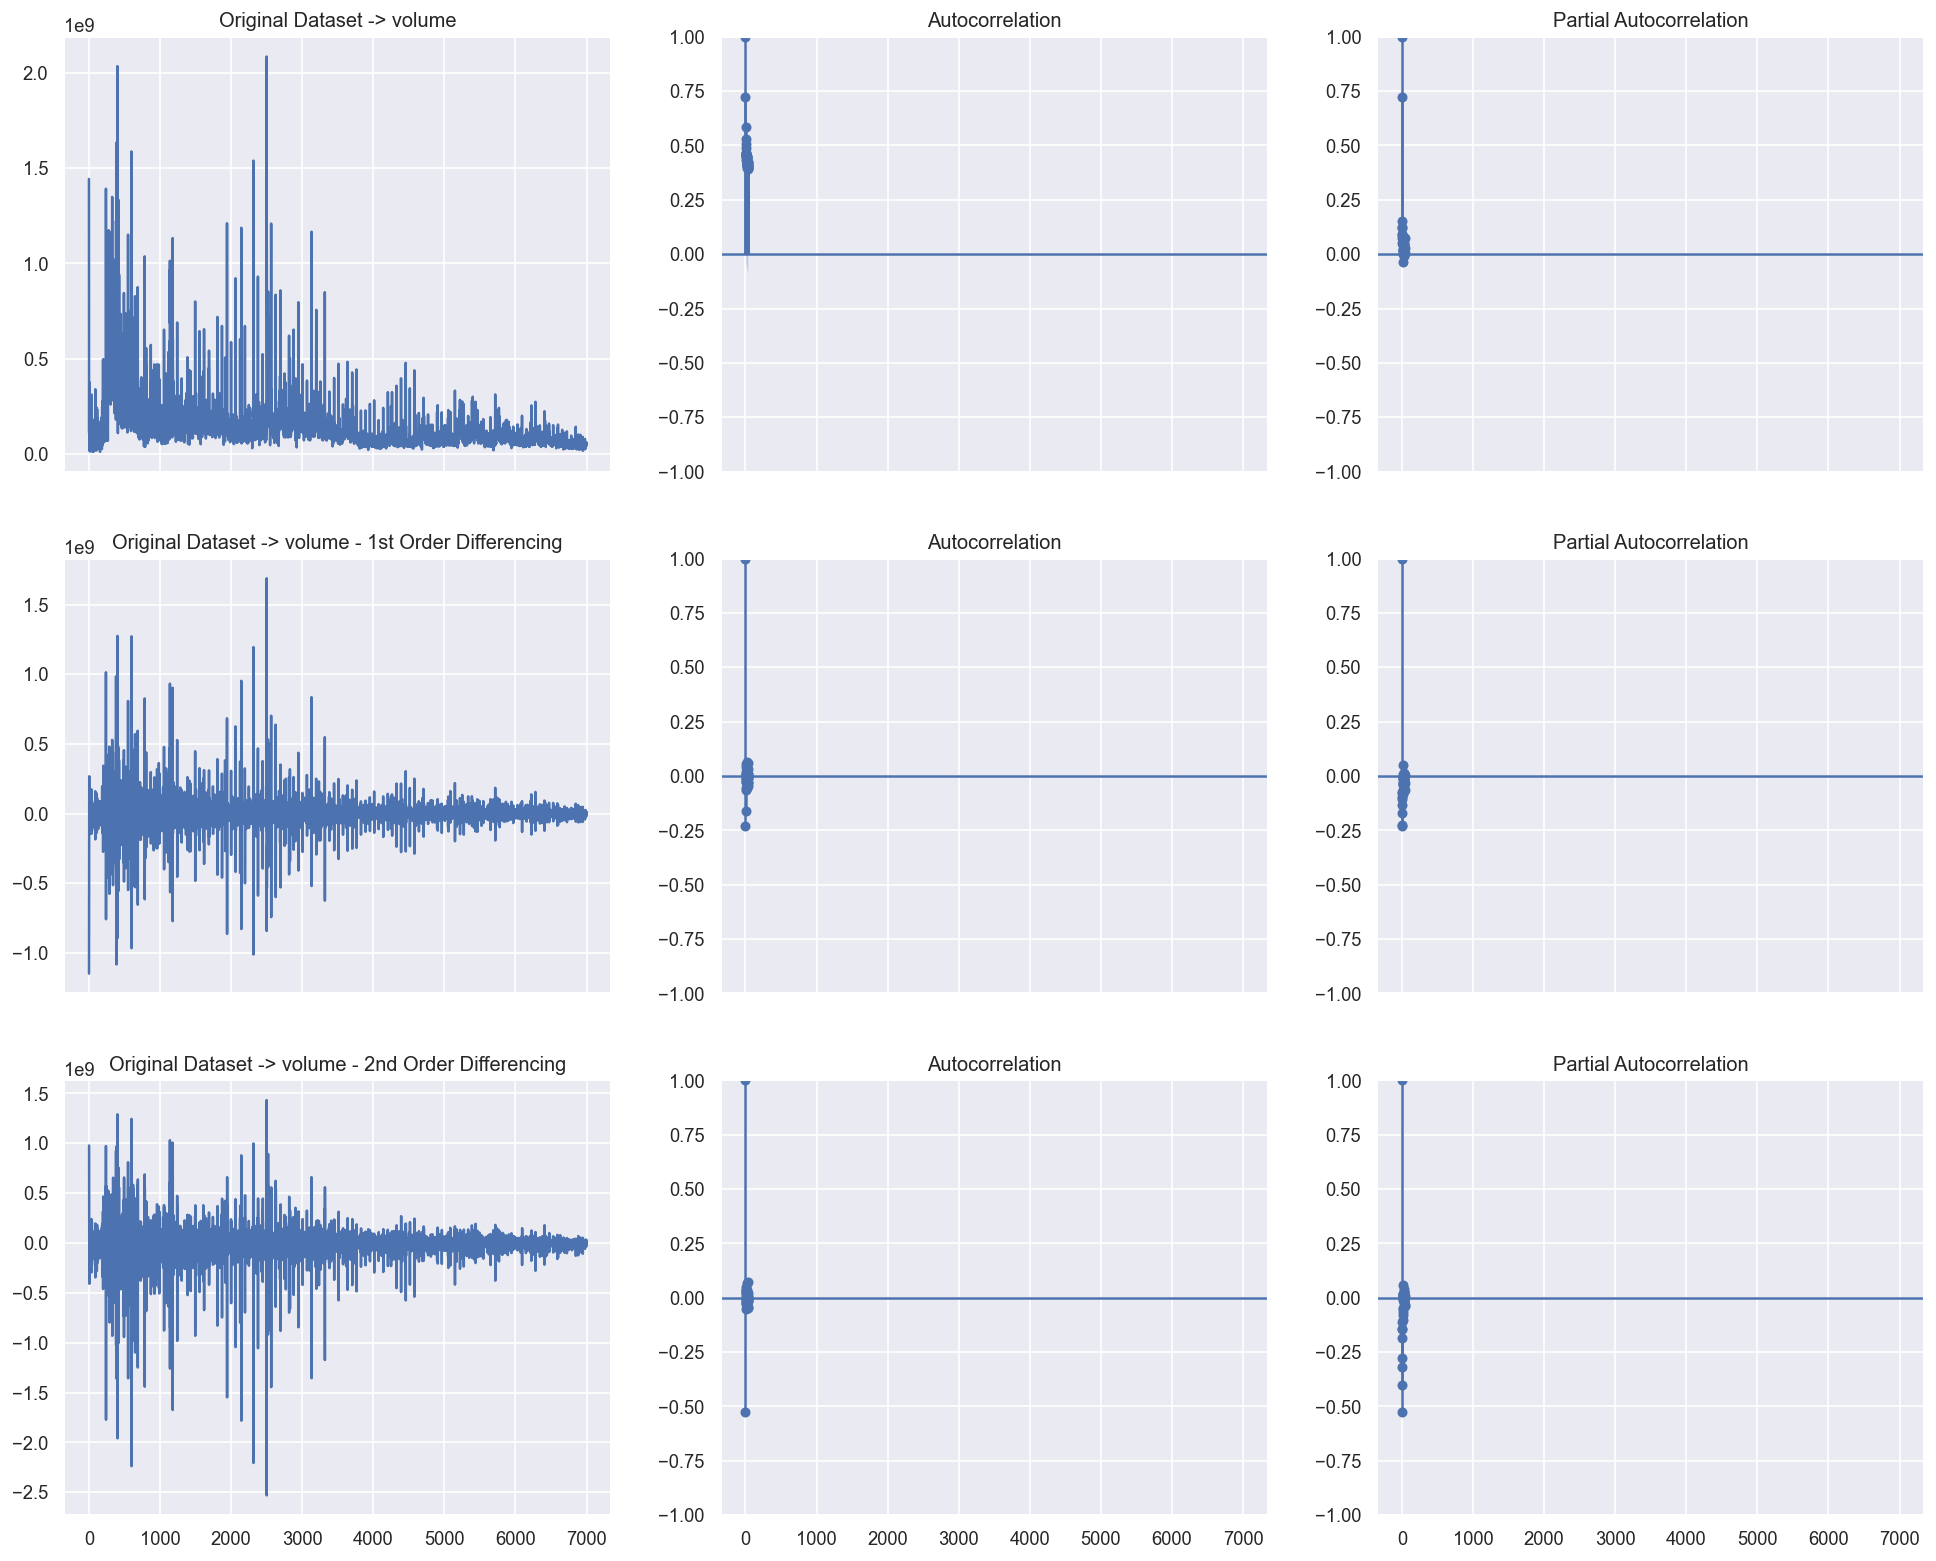

Training based on:
order -> (1, 1, 2)
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 6997
Model:                 ARIMA(1, 1, 2)   Log Likelihood             -137962.979
Date:                Sat, 08 Mar 2025   AIC                         275933.958
Time:                        19:43:31   BIC                         275961.370
Sample:                             0   HQIC                        275943.404
                               - 6997                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4649      0.011     41.003      0.000       0.443       0.487
ma.L1         -0.9246      0.012    -74.706      0.000      -0.949      -0.900
ma.L2         

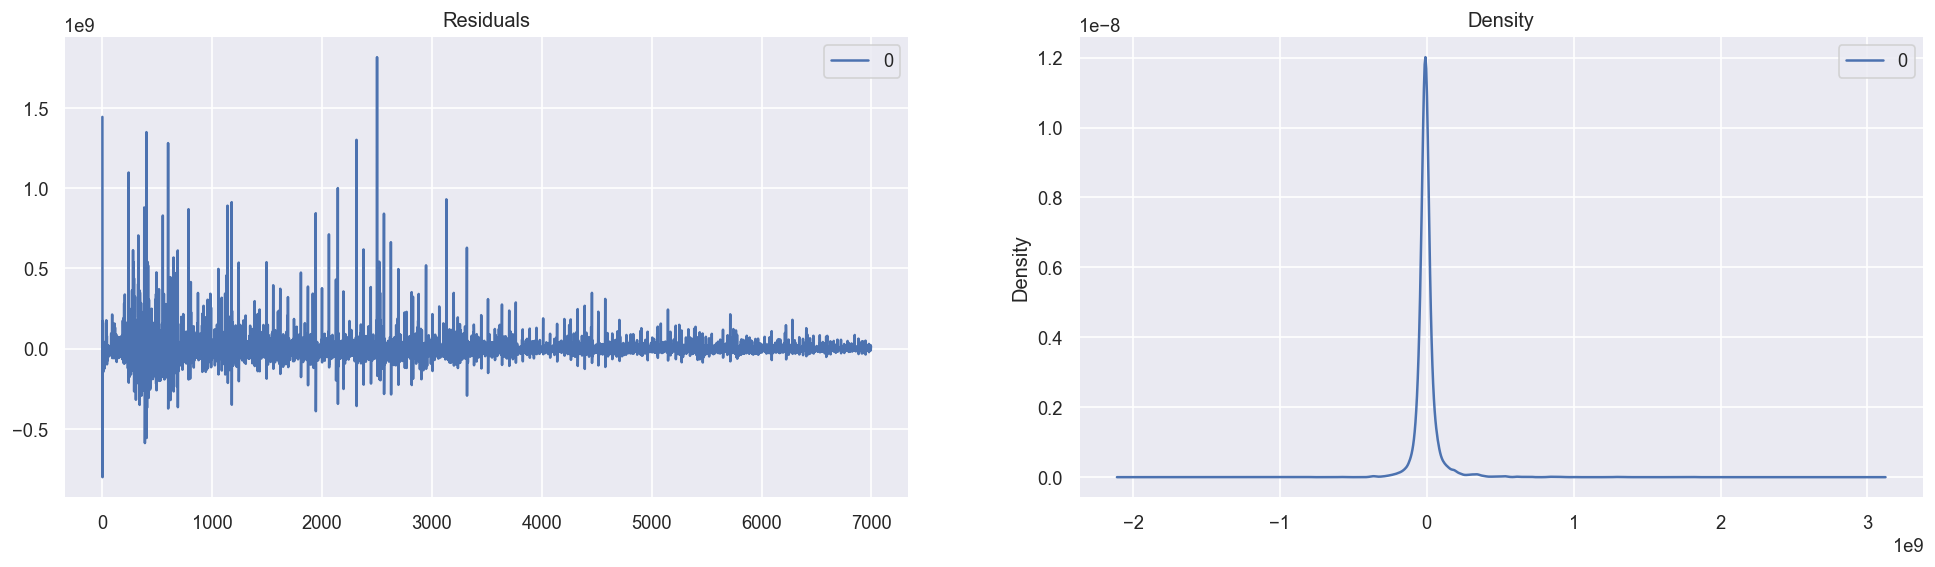

<class 'pandas.core.series.Series'>


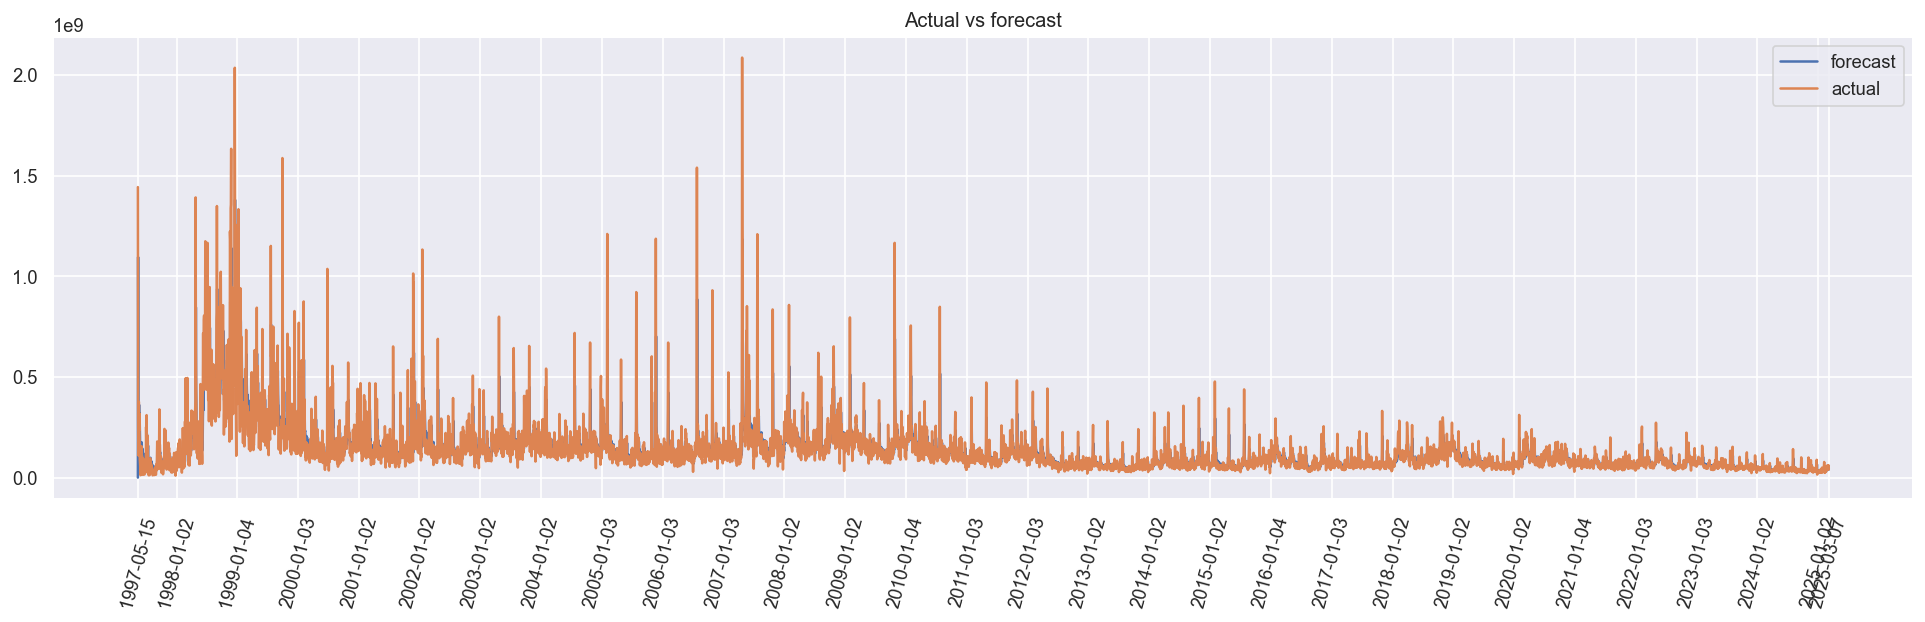

In [ ]:
hyperparams = [{
    "order": (1, 1, 2)
},{
    "order": (1, 1, 1)
}]

for dataset_type, dataset in datasets.items():
    date_labels = get_date_labels_amzn(dataset)

    #print(date_labels)
    
    plot_acf(dataset.value, f"Original Dataset -> {dataset_type}")
    for idx, hyperparam in enumerate(hyperparams):
        predicted_dataset = run_arima(dataset, hyperparam, date_labels)
        plot_acf(predicted_dataset.value, f"Forecasted Dataset {idx} -> {dataset_type}")
        print("==================================================================================================")

In [431]:
# Test and visualize

# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment. 